# Import Modules & Util Functions

In [21]:
import os
import sys
import glob
import re
import ast
import warnings
import time

import csv
import json
import pickle

import math
import random
import numpy as np
import scipy as sp
import datetime as dt
import pandas as pd
import swifter
from scipy.stats import gaussian_kde
from scipy.integrate import quad
from sklearn.metrics import mean_squared_error

import portion as P
import itertools as it
import copy
from tqdm.notebook import tqdm
from collections import namedtuple
from pprint import pprint
from pytictoc import TicToc

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from my_utils import *

# Configure display options
# pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
%config InlineBackend.figure_format = 'retina'

# Set plot style
# plt.style.use('ggplot')

# Single Radio Profiling

In [22]:
class Profile():
    def __init__(self, filepaths, model_name='Test', model_id=None, stage='first', save_path='./models',
                 scope_agg=None, scope=None, sp_columns=['type'], ts_column='Timestamp',
                 metrics=['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl']):
        
        # Initialize instance variables
        self.filepaths = copy.deepcopy(filepaths)
        if model_id is None:
            self.model_id = model_prefix()
        else:
            self.model_id = model_id
        self.save_path = save_path
        self.model_name = model_name
        print(self.model_name)
        self.stage = stage
        if scope_agg is None:
            if scope is None:
                scope = {
                    **{key: (-5.0, 5.0) for key in ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II']},
                    **{key: (-10.0, 10.0) for key in ['SCGF', 'MCGF', 'NASR']}, 
                    'Stable': (-1.0, 1.0)
                }
            self.scope_agg = { mode_mets: scope.copy() for mode_mets in metrics }   
        else:
            self.scope_agg = copy.deepcopy(scope_agg)
        self.sp_columns = sp_columns[:]
        self.ts_column = ts_column
        self.metrics = metrics[:]
        self.Container = { mode_mets: { tag: { 'dist_table': [],
                                               'relative_loex_timestamp': [],
                                               'relative_timestamp': [],
                                               'interruption_time': [],
                                               'trigger_loex': [],
                                               'event_count': [] } 
                                        for tag in self.scope_agg[mode_mets].keys() }
                                        for mode_mets in metrics }
        self.Profile = { mode_mets: { tag: { 'dist_table': None,
                                             'relative_loex_timestamp': [],
                                             'relative_timestamp': [],
                                             'interruption_time': [],
                                             'trigger_loex': [],
                                             'event_count': 0 } 
                                        for tag in self.scope_agg[mode_mets].keys() }
                                        for mode_mets in metrics }
        self.scope_models = copy.deepcopy(self.scope_agg)
        self.hist_models = { mode_mets: { tag: None for tag in self.scope_agg[mode_mets].keys() } for mode_mets in metrics }
        self.kde_models = { mode_mets: { tag: (None, None, None) for tag in self.scope_agg[mode_mets].keys() } for mode_mets in metrics }
        self.plr_models = { mode_mets: { tag: 0.00 for tag in self.scope_agg[mode_mets].keys() } for mode_mets in metrics }
        self.prob_models = { mode_mets: { tag: None for tag in self.scope_agg[mode_mets].keys() } for mode_mets in metrics }
        
        # Construct profiles
        self.construct_profile()
        self.modeling()
    
    
    @staticmethod
    def interpolate(x, y, ratio=0.5):
        """
        Args:
            x, y (datetime.datetime): x < y
            ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
        Returns:
            (datetime.datetime): breakpoint of interpolation
        """
        return x + (y - x) * ratio
    
    
    def create_instance(self, df, center, interval, mets='lost', w_size=0.01):
        df = df[(df[self.ts_column] >= interval.lower) & (df[self.ts_column] < interval.upper)].copy().reset_index(drop=True)
        
        # Relative window converted from timestamp
        df['relative_time'] = (df['Timestamp'] - center).dt.total_seconds()
        df['window_id'] = ((df['relative_time'] + w_size / 2) // w_size) * w_size  # 四捨五入
        
        if mets == 'lost':
            RATE_TYPE = 'PLR'
            loex_df = df[df['lost']].copy()
            ts_group = df.groupby(['window_id'])
            table = ts_group.agg({'lost': ['count','sum'], 'Timestamp': ['first']}).reset_index()
        elif mets == 'excl':
            RATE_TYPE = 'ELR'
            df['excl_exact'] = df['excl'] & ~df['lost']
            loex_df = df[df['excl_exact']].copy()
            ts_group = df.groupby(['window_id'])
            table = ts_group.agg({'excl_exact': ['count','sum'], 'Timestamp': ['first']}).reset_index()
        
        table.columns = ['window_id','tx_count',mets,'Timestamp']
        
        return table, loex_df['relative_time'].to_list(), df['relative_time'].to_list()
    
    
    def setup_profile(self, df, ho_df, mode, mets, scope):
        # Initialize "Register"
        Register = { tag: { 'dist_table': [],
                            'relative_loex_timestamp': [],
                            'relative_timestamp': [],
                            'interruption_time': [],
                            'trigger_loex': [] } for tag in scope.keys() }
        this_df = df.copy()
        
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                # print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    left_bound = min(max(current_left_bound, Profile.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    left_bound = min(max(current_left_bound, Profile.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    right_bound = max(min(current_right_bound, Profile.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    right_bound = max(min(current_right_bound, Profile.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                right_bound = current_right_bound
            
            interval = P.closed(left_bound, right_bound)

            # Consider the stable duration before an event starts
            stable_df = this_df[this_df[self.ts_column] < interval.lower].copy()
            stable_df['Timestamp_to_second'] = stable_df['Timestamp'].dt.floor('S')
            
            if not stable_df.empty:
                unique_timestamps = stable_df['Timestamp_to_second'].unique()
                
                tmp_df = stable_df.copy()
                for ts in unique_timestamps:
                    stable_center = ts + pd.Timedelta(seconds=0.5)
                    stable_interval = P.closed(ts, min(ts + pd.Timedelta(seconds=1), interval.lower))
                    
                    # Create an instance of stable profile
                    dist_table, relative_loex_timestamp, relative_timestamp = self.create_instance(tmp_df.copy(), stable_center, stable_interval, mets=mets)
                    
                    # if len(relative_loex_timestamp):
                    #     display(dist_table)
                    #     print('Stable', len(relative_loex_timestamp), relative_loex_timestamp)
                    
                    # Feed into "Register"
                    if len(relative_loex_timestamp):
                        Register['Stable']['trigger_loex'].append(1)
                        Register['Stable']['dist_table'].append(dist_table)
                        Register['Stable']['relative_loex_timestamp'] += relative_loex_timestamp
                    else:
                        Register['Stable']['trigger_loex'].append(0)
                    Register['Stable']['interruption_time'].append((stable_interval.upper - stable_interval.lower).total_seconds())
                    Register['Stable']['relative_timestamp'] += relative_timestamp
                    
                    # Update dataframe to accelerate
                    tmp_df = tmp_df[tmp_df[self.ts_column] >= ts + pd.Timedelta(seconds=1)]
            
            # Create an instance of handover profile
            dist_table, relative_loex_timestamp, relative_timestamp = self.create_instance(this_df.copy(), start_ts, interval, mets=mets)
            
            # if len(relative_loex_timestamp):
            #     display(dist_table)
            #     print(tag, len(relative_loex_timestamp), relative_loex_timestamp)
            
            # Feed into "Register"
            if len(relative_loex_timestamp):
                Register[tag]['trigger_loex'].append(1)
                Register[tag]['dist_table'].append(dist_table)
                Register[tag]['relative_loex_timestamp'] += relative_loex_timestamp
            else:
                Register[tag]['trigger_loex'].append(0)
            Register[tag]['interruption_time'].append(interruption_time)
            Register[tag]['relative_timestamp'] += relative_timestamp
            
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()

        # Consider the stable duration after the last event ends
        stable_df = this_df.copy()
        stable_df['Timestamp_to_second'] = stable_df['Timestamp'].dt.floor('S')

        if not stable_df.empty:
            unique_timestamps = stable_df['Timestamp_to_second'].unique()
            
            tmp_df = stable_df.copy()
            for ts in unique_timestamps:
                stable_center = ts + pd.Timedelta(seconds=0.5)
                stable_interval = P.closed(ts, ts + pd.Timedelta(seconds=1))
                
                # Create an instance of stable profile
                dist_table, relative_loex_timestamp, relative_timestamp = self.create_instance(tmp_df.copy(), stable_center, stable_interval, mets=mets)
                
                # if len(relative_loex_timestamp):
                #     display(dist_table)
                #     print('Stable', len(relative_loex_timestamp), relative_loex_timestamp)
                
                # Feed into "Register"
                if len(relative_loex_timestamp):
                    Register['Stable']['trigger_loex'].append(1)
                    Register['Stable']['dist_table'].append(dist_table)
                    Register['Stable']['relative_loex_timestamp'] += relative_loex_timestamp
                else:
                    Register['Stable']['trigger_loex'].append(0)
                Register['Stable']['interruption_time'].append((stable_interval.upper - stable_interval.lower).total_seconds())
                Register['Stable']['relative_timestamp'] += relative_timestamp
                
                # Update dataframe to accelerate
                tmp_df = tmp_df[tmp_df[self.ts_column] >= ts + pd.Timedelta(seconds=1)]
        
        return Register
    
    
    @staticmethod
    def dist_aggregate(tables, mode, mets):
        if mets == 'lost':
            RATE_TYPE = 'PLR'
        elif mets == 'excl':
            RATE_TYPE = 'ELR'
        
        table = pd.DataFrame(columns=['window_id','tx_count',mets])
        table[mets] = table[mets].astype('Int32')
        table['window_id'] = table['window_id'].astype('float32')
        table['tx_count'] = table['tx_count'].astype('Int32')
        
        tables = [t for t in tables if t is not None]
        for this_table in tables:
            table = table.merge(this_table, on=['window_id'], how='outer').fillna(0)
            table['tx_count'] = table['tx_count_x'] + table['tx_count_y']
            table[mets] = table[f'{mets}_x'] + table[f'{mets}_y']
            table = table[['window_id','tx_count',mets]]
        
        table[RATE_TYPE] = table[mets] / (table['tx_count'] + 1e-9) * 100
        table[RATE_TYPE] = table[RATE_TYPE].astype('float32')
        
        table = table[['window_id','tx_count',mets,RATE_TYPE]].copy().sort_values(by=['window_id']).reset_index(drop=True)
        return table
    
    
    @staticmethod
    def mean_downsample(data, sample_size=100000):
        """
        平均下採樣函數
        
        Args:
        data: 原始數據的列表
        sample_size: 下採樣後的樣本大小
        
        Returns:
        downsampled_data: 下採樣後的數據列表
        """
        chunk_size = len(data) // sample_size
        if chunk_size == 0:
            return data
        downsampled_data = [sum(data[i:i+chunk_size]) / chunk_size for i in range(0, len(data), chunk_size)]
        return downsampled_data
    
    
    @staticmethod
    def median_downsample(data, sample_size=100000):
        """
        中位數下採樣函數
        
        Args:
        data: 原始數據的列表
        sample_size: 下採樣後的樣本大小
        
        Returns:
        downsampled_data: 下採樣後的數據列表
        """
        chunk_size = len(data) // sample_size
        if chunk_size == 0:
            return data
        downsampled_data = []
        for i in range(0, len(data), chunk_size):
            chunk = data[i:i+chunk_size]
            median_index = len(chunk) // 2
            median_value = np.median(chunk)
            downsampled_data.append(median_value)
        return downsampled_data
    
    
    def construct_profile(self):
        n = len(self.filepaths)
        
        for i, filepath in enumerate(self.filepaths):
            
            # if i > 0:
            #     break
            
            for s in filepath[:3]:
                print(f'{i+1}/{n}', s)
            
            dl_df, ul_df = None, None
            ho_df = pd.read_csv(filepath[0], parse_dates=['start', 'end'])
            if ho_df.empty:
                print('******** Empty RRC Data ********')
                continue
            
            for mode_mets in self.metrics:
                mode, mets = mode_mets[:2], mode_mets[-4:]
                scope = self.scope_agg[mode_mets]
                
                if mode == 'dl':
                    if dl_df is None:
                        dl_df = pd.read_csv(filepath[1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
                    df = dl_df.copy()
                elif mode == 'ul':
                    if ul_df is None:
                        ul_df = pd.read_csv(filepath[2], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
                    df = ul_df.copy()
                
                ho_df = pd.read_csv(filepath[0], parse_dates=['start', 'end'])
                df, ho_df, empty_data = data_aligner(df, ho_df)
                
                
                if empty_data:
                    print('******** Empty Data:', mode_mets, '********')
                    continue
                
                Register = self.setup_profile(df, ho_df, mode, mets, scope)
                
                # Append "Register" for each trace
                for tag in scope.keys():
                    table = Profile.dist_aggregate(Register[tag]['dist_table'], mode, mets)
                    self.Container[mode_mets][tag]['dist_table'].append(table)
                    self.Container[mode_mets][tag]['relative_loex_timestamp'].append(Register[tag]['relative_loex_timestamp'])
                    self.Container[mode_mets][tag]['relative_timestamp'].append(Register[tag]['relative_timestamp'])
                    self.Container[mode_mets][tag]['trigger_loex'].append(Register[tag]['trigger_loex'])
                    self.Container[mode_mets][tag]['interruption_time'].append(Register[tag]['interruption_time'])
                    self.Container[mode_mets][tag]['event_count'].append(len(Register[tag]['interruption_time']))
        
        for mode_mets in self.metrics:
            mode, mets = mode_mets[:2], mode_mets[-4:]
            scope = self.scope_agg[mode_mets]
            
            for tag in scope.keys():
                self.Profile[mode_mets][tag]['dist_table'] = Profile.dist_aggregate(self.Container[mode_mets][tag]['dist_table'], mode, mets)
                self.Container[mode_mets][tag]['dist_table'] = []
                
                data = []
                for lst in self.Container[mode_mets][tag]['relative_loex_timestamp']:
                    data += lst
                self.Profile[mode_mets][tag]['relative_loex_timestamp'] = Profile.mean_downsample(sorted(data))
                self.Container[mode_mets][tag]['relative_loex_timestamp'] = []
                
                data = []
                for lst in self.Container[mode_mets][tag]['relative_timestamp']:
                    data += lst
                self.Profile[mode_mets][tag]['relative_timestamp'] = Profile.mean_downsample(sorted(data))
                self.Container[mode_mets][tag]['relative_timestamp'] = []
                
                del data
                
                for lst in self.Container[mode_mets][tag]['trigger_loex']:
                    self.Profile[mode_mets][tag]['trigger_loex'] += lst
                self.Container[mode_mets][tag]['trigger_loex'] = []
                
                for lst in self.Container[mode_mets][tag]['interruption_time']:
                    self.Profile[mode_mets][tag]['interruption_time'] += lst
                self.Container[mode_mets][tag]['interruption_time'] = []
                
                self.Profile[mode_mets][tag]['event_count'] += sum(self.Container[mode_mets][tag]['event_count'])
                self.Container[mode_mets][tag]['event_count'] = []
    
    
    @staticmethod
    def total_area_kde(kde, lower_bound=-np.inf, upper_bound=np.inf):
        # 定義積分函數
        def integrand(x):
            return kde(x)
        total_area, _ = quad(integrand, lower_bound, upper_bound)
        return total_area

    
    @staticmethod
    def total_area_histogram_with_centers(x_centers, heights, bin_width):
        # 計算每個 bin 的面積並相加
        total_area = bin_width * sum(heights)
        return total_area
    
    
    def modeling(self, sd_factor=3, w_size=0.01):
        for i, mode_mets in enumerate(self.metrics):
            mode, mets = mode_mets[:2], mode_mets[-4:]
            if mets == 'lost':
                RATE_TYPE = 'PLR'
            elif mets == 'excl':
                RATE_TYPE = 'ELR'
            
            # if i > 0:
            #     break
            
            scope = self.scope_agg[mode_mets]
            for tag in scope.keys():
                # print(tag)
                left_bound, right_bound = scope[tag]
                table = self.Profile[mode_mets][tag]['dist_table']
                loex_data = self.Profile[mode_mets][tag]['relative_loex_timestamp']
                xmit_data = self.Profile[mode_mets][tag]['relative_timestamp']
                trigger_lst = self.Profile[mode_mets][tag]['trigger_loex']
                
                self.hist_models[mode_mets][tag] = table.copy()
                
                if len(trigger_lst) == 0:
                    continue
                
                estimated_p = sum(trigger_lst) / len(trigger_lst)
                self.prob_models[mode_mets][tag] = estimated_p
                
                PLR = sum(table[mets]) / (sum(table['tx_count']) + 1e-9) * 100
                self.plr_models[mode_mets][tag] = PLR
                
                # if loex_data == 1, then kde function bump error: ValueError: `dataset` input should have multiple elements.
                if len(loex_data) < 2:
                    continue
                
                if self.stage == 'last':
                    left_bound, right_bound = self.scope_agg[mode_mets][tag]
                else:
                    if tag == 'Stable':
                        mean = 0
                        left_bound, right_bound = -0.5, 0.5
                    else:
                        loex_table = table[table[mets] > 0].reset_index(drop=True)
                        mean, std_dev = np.mean(loex_data), np.std(loex_data)
                        left_bound = math.floor(max(left_bound, mean - sd_factor * std_dev, loex_table.iloc[0]['window_id']) * 10) / 10
                        right_bound = math.ceil(min(right_bound, mean + sd_factor * std_dev, loex_table.iloc[-1]['window_id']) * 10) / 10
                    
                    self.scope_models[mode_mets][tag] = (left_bound, right_bound)
                
                x = np.asarray(table['window_id'], dtype=np.float64)
                y = np.asarray(table[RATE_TYPE], dtype=np.float64)
                
                # # 計算直方圖的面積
                hist_area = Profile.total_area_histogram_with_centers(x, y, w_size)
                # print("Total area of histogram:", hist_area)
                
                kde1 = gaussian_kde(loex_data)
                kde2 = gaussian_kde(xmit_data)
                def kde(x):
                    kde2_values = kde2(x)
                    # 檢查 kde2 是否為零，如果是則返回一個超大值，把 loss rate 壓成 0
                    kde2_values[kde2_values == 0] = 1e9
                    return kde1(x) / kde2_values
                
                # 計算 KDE 下的總面積（無窮積分）
                # kde_area = Profile.total_area_kde(kde)
                # 計算 KDE 下的總面積（只計算正負3個標準差內的點，理論上 scalar 會稍微高估，但不會太多）
                kde_area = Profile.total_area_kde(kde, left_bound, right_bound)
                # print("Total area under KDE:", kde_area)
                
                scalar = hist_area / kde_area
                # print("Scalar:", scalar)
                
                self.kde_models[mode_mets][tag] = (scalar, kde1, kde2)
    
    
    def plot(self, sd_factor=3):
        for i, mode_mets in enumerate(self.metrics):
            mode, mets = mode_mets[:2], mode_mets[-4:]
            if mets == 'lost':
                RATE_TYPE = 'PLR'
            elif mets == 'excl':
                RATE_TYPE = 'ELR'
            
            # if i > 0:
            #     break
            
            scope = self.scope_agg[mode_mets]
            for tag in scope.keys():
                # print('===================================================================================')
                # print(tag)
                
                loex_data = self.Profile[mode_mets][tag]['relative_loex_timestamp']
                xmit_data = self.Profile[mode_mets][tag]['relative_timestamp']
                trigger_lst = self.Profile[mode_mets][tag]['trigger_loex']
                
                left_bound, right_bound = self.scope_models[mode_mets][tag]
                table = self.hist_models[mode_mets][tag]
                scalar, kde1, kde2 = self.kde_models[mode_mets][tag]
                
                if len(loex_data) == 0:
                    continue
                
                fig, ax = plt.subplots(figsize=(6, 4))
                
                x = np.asarray(table['window_id'], dtype=np.float64)
                y1 = np.asarray(table['tx_count'], dtype=np.float64)
                y2 = np.asarray(table[RATE_TYPE], dtype=np.float64)
                
                ax_twin = ax.twinx()
                ax_twin.bar(x, y1, label='tx_packet', color='tab:blue', width=0.01, alpha=0.15)
                ax.bar(x, y2, label='loss_rate', color='tab:blue', width=0.01, alpha=0.97)
                
                # ax = ax.twinx()
                
                if kde1 is not None and kde2 is not None:
                    x = np.linspace(min(xmit_data), max(xmit_data), 1000)
                    
                    def kde(x):
                        kde2_values = kde2(x)
                        # 檢查 kde2 是否為零，如果是則返回一個超大值，把 loss rate 壓成 0
                        kde2_values[kde2_values == 0] = 1e9
                        return kde1(x) / kde2_values
                
                    density = scalar * kde(x)
                    ax.fill_between(x, density, label='KDE', color='tab:orange', alpha=0.45, linewidth=0)
        
                # find the scope and boundaries
                ax.axvline(x=0, color='red', linestyle='-', alpha=0.5)
                ax.axvline(x=left_bound, color='blue', linestyle='--', label=f'-{sd_factor} Std')
                ax.axvline(x=right_bound, color='blue', linestyle='--', label=f'+{sd_factor} Std')
                
                bottom, top = ax.get_ylim()
                ax.text(left_bound, bottom-0.05*(top-bottom), '{:.1f}'.format(left_bound), ha='center', fontweight='bold', fontsize=10, color='blue')
                ax.text(right_bound, bottom-0.05*(top-bottom), '{:.1f}'.format(right_bound), ha='center', fontweight='bold', fontsize=10, color='blue')
                
                left, right = ax.get_xlim()
                count = self.Profile[mode_mets][tag]['event_count']
                intr = round(np.mean(self.Profile[mode_mets][tag]['interruption_time']), 3)
                trigger = sum(self.Profile[mode_mets][tag]['trigger_loex'])
                trigger_rate = round(self.prob_models[mode_mets][tag] * 100, 1)
                PLR = round(sum(table[mets]) / (sum(table['tx_count']) + 1e-9) * 100, 2)
                ax.text(left+0.06*(right-left), bottom+0.73*(top-bottom), f'Event Count: {count}\nTrigger Loss: {trigger} ({trigger_rate}%)\nAvg {RATE_TYPE}: {PLR}%\nAvg INTR: {intr} (sec)', ha='left', fontweight='bold', fontsize=10)
                
                if mode == 'dl':
                    if mets == 'lost':
                        ax.set_title(f'Downlink PLR: {tag}')
                    elif mets == 'excl':
                        ax.set_title(f'Downlink ELR: {tag}')
                elif mode == 'ul':
                    if mets == 'lost':
                        ax.set_title(f'Uplink PLR: {tag}')
                    elif mets == 'excl':
                        ax.set_title(f'Uplink ELR: {tag}')
                
                if mets == 'lost':
                    ax.set_ylabel('Packet Loss Rate (%)')
                elif mets == 'excl':
                    ax.set_ylabel('Excessive Latency Rate (%)')
                ax.set_xlabel('Relative Timestamp (sec)')
                ax_twin.set_ylabel('Number of Packets Transmit')
                
                # 合併兩個圖的legend
                lines, labels = ax.get_legend_handles_labels()
                lines2, labels2 = ax_twin.get_legend_handles_labels()
                # ax.legend(lines + lines2, labels + labels2, loc='best')
                ax.legend(lines + lines2, labels + labels2, loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=5)
                
                save_path = os.path.join(self.save_path, self.model_id, 'plot')
                if not os.path.isdir(save_path):
                    os.makedirs(save_path)
                
                # save_path = os.path.join(save_path, model_add_prefix(self.model_name, self.model_id))
                save_path = os.path.join(save_path, f'{tag}_{self.model_name}.png')
                print(save_path)
                fig.savefig(save_path, dpi=300)
                
                plt.gcf().autofmt_xdate()
                plt.show()
    
    
    def save_models(self):
        save_path = os.path.join(self.save_path, self.model_id)
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        
        # save_path = os.path.join(save_path, model_add_prefix(self.model_name, self.model_id))
        save_path = os.path.join(save_path, self.model_name)
        print(save_path)
        print()
        
        with open(f'{save_path}_kde_models.pkl', 'wb') as f:
            pickle.dump(self.kde_models, f)
        with open(f'{save_path}_hist_models.pkl', 'wb') as f:
            pickle.dump(self.hist_models, f, protocol=pickle.HIGHEST_PROTOCOL)
        with open(f'{save_path}_scope_models.pkl', 'wb') as f:
            pickle.dump(self.scope_models, f)
        with open(f'{save_path}_plr_models.pkl', 'wb') as f:
            pickle.dump(self.plr_models, f)
        with open(f'{save_path}_sr_prob_models.pkl', 'wb') as f:
            pickle.dump(self.prob_models, f)

# Generate Model ID

In [23]:
model_id = model_prefix()
print(model_id)

20240312_150032342e


# BR Models

In [24]:
# Single Radio Example
dates = data_loader(query_dates=True)

selected_dates = [s for s in dates if s >= '2023-09-12']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['BR']
# excluded_routes = []
filepaths = data_loader(mode='sr', selected_dates=selected_dates, selected_routes=selected_routes)

# print(len(filepaths))
# pprint(filepaths)

BR_prior
1/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv
1/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv
1/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_uplk_loss_latency.csv
2/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv
2/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_dnlk_loss_latency.csv
2/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_uplk_loss_latency.csv
3/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/handover_info_log.csv
3/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/udp_dnlk_loss_latency.csv
3/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown

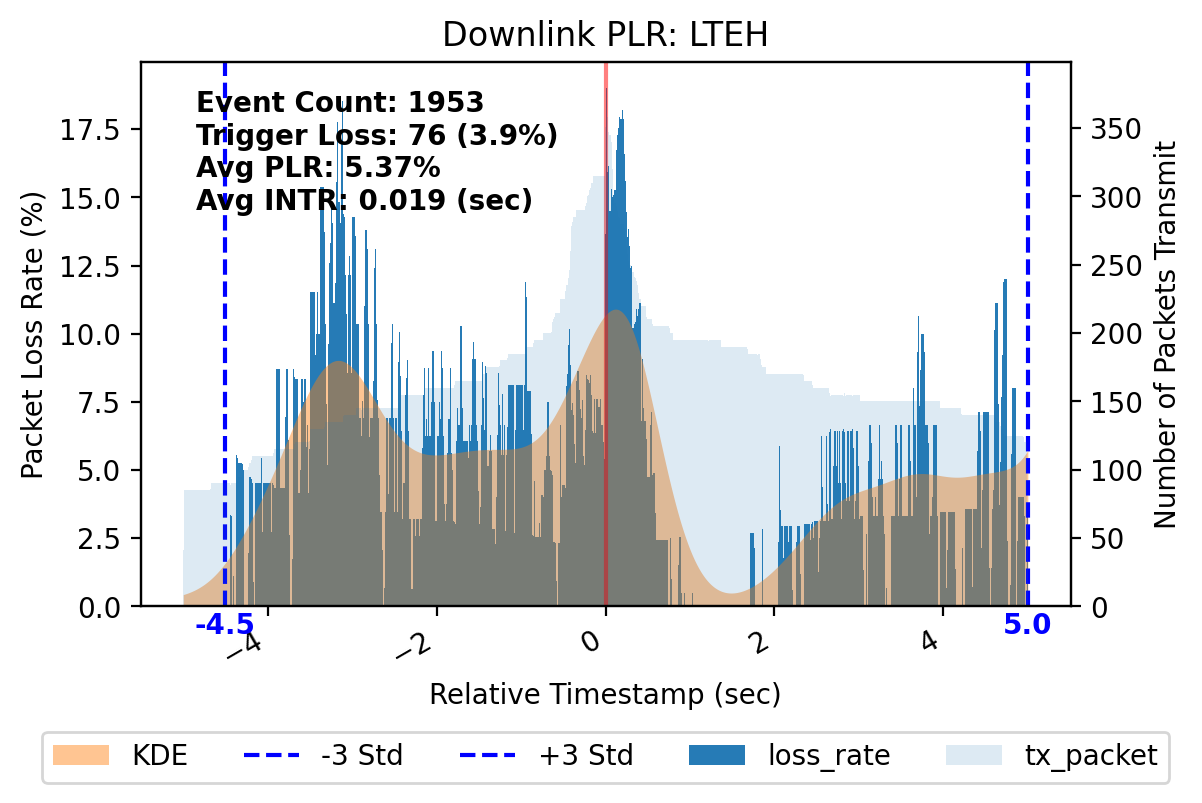

./models/20240312_150032342e/plot/ENBH_BR_prior.png


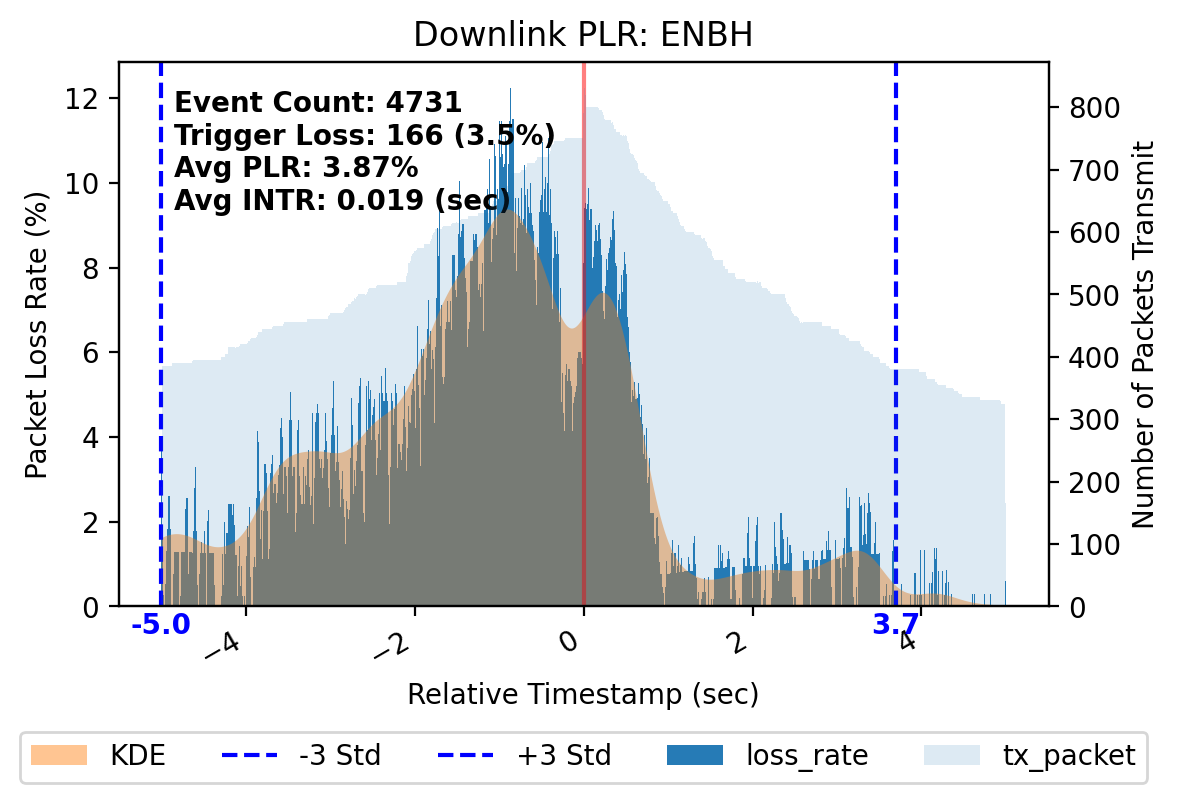

./models/20240312_150032342e/plot/MCGH_BR_prior.png


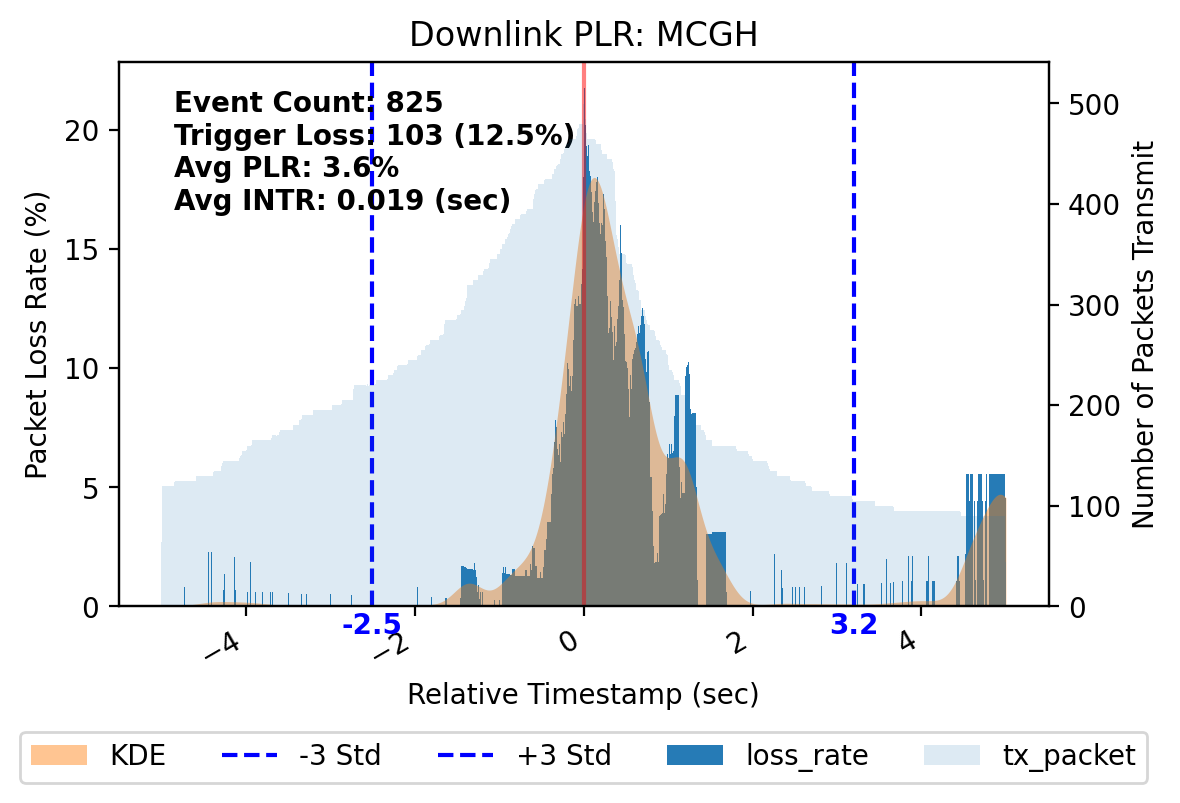

./models/20240312_150032342e/plot/MNBH_BR_prior.png


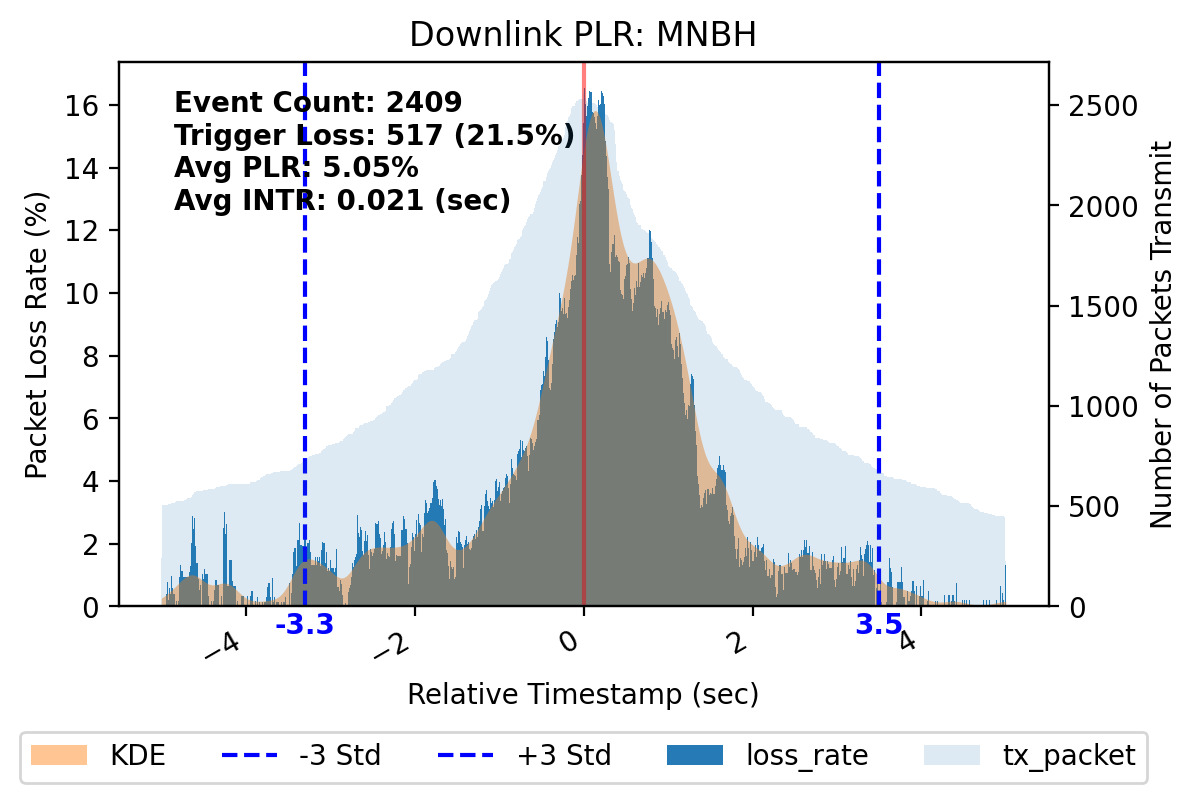

./models/20240312_150032342e/plot/SCGM_BR_prior.png


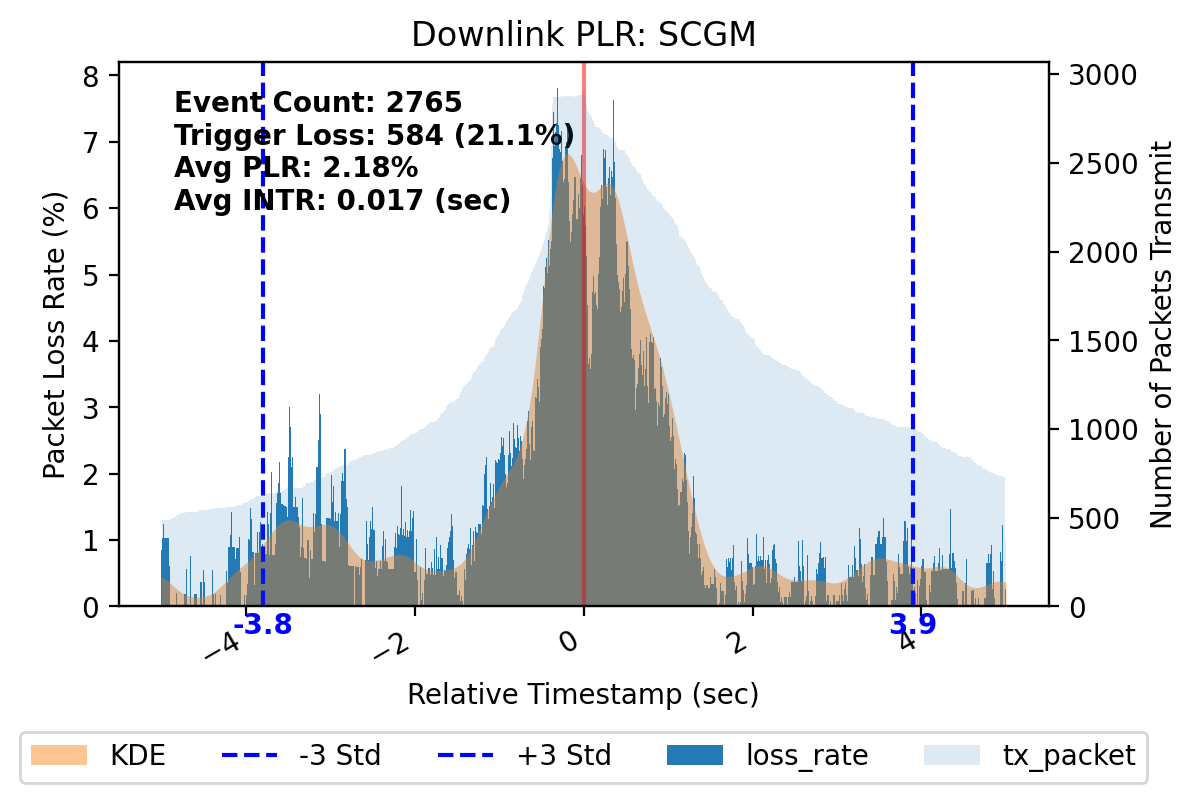

./models/20240312_150032342e/plot/SCGA_BR_prior.png


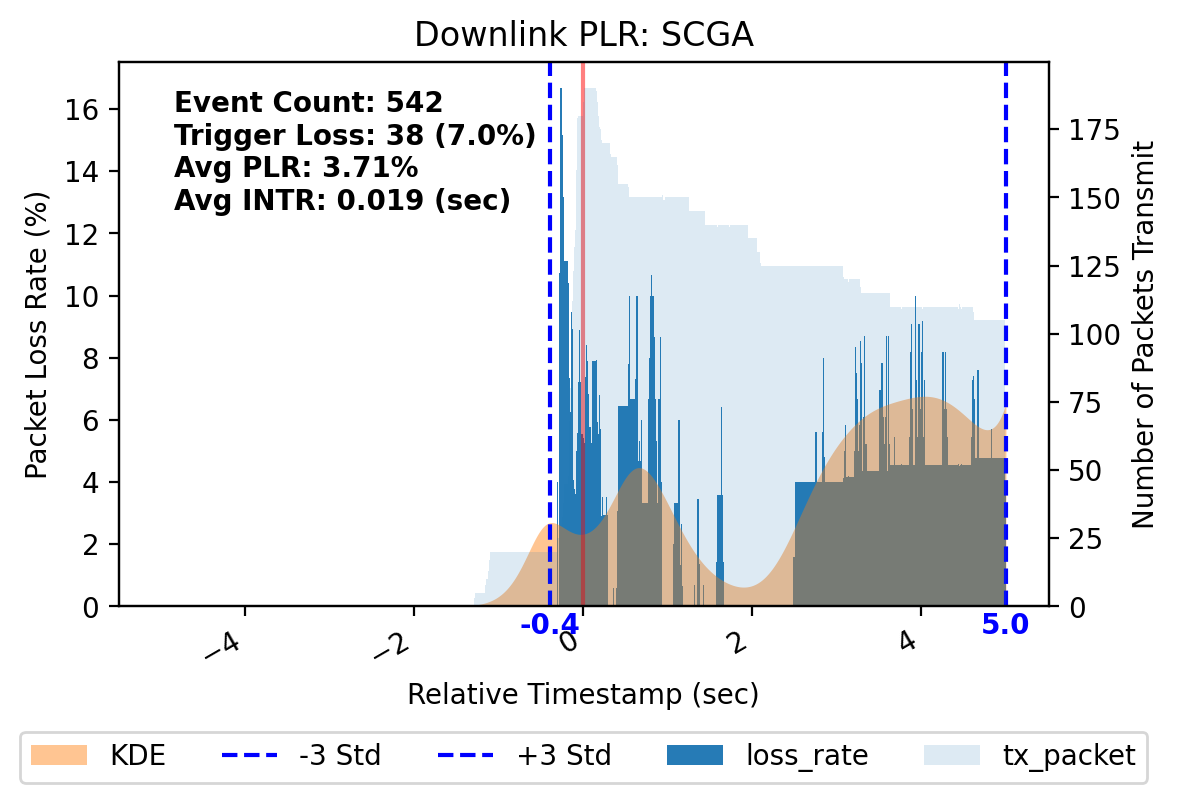

./models/20240312_150032342e/plot/SCGR-I_BR_prior.png


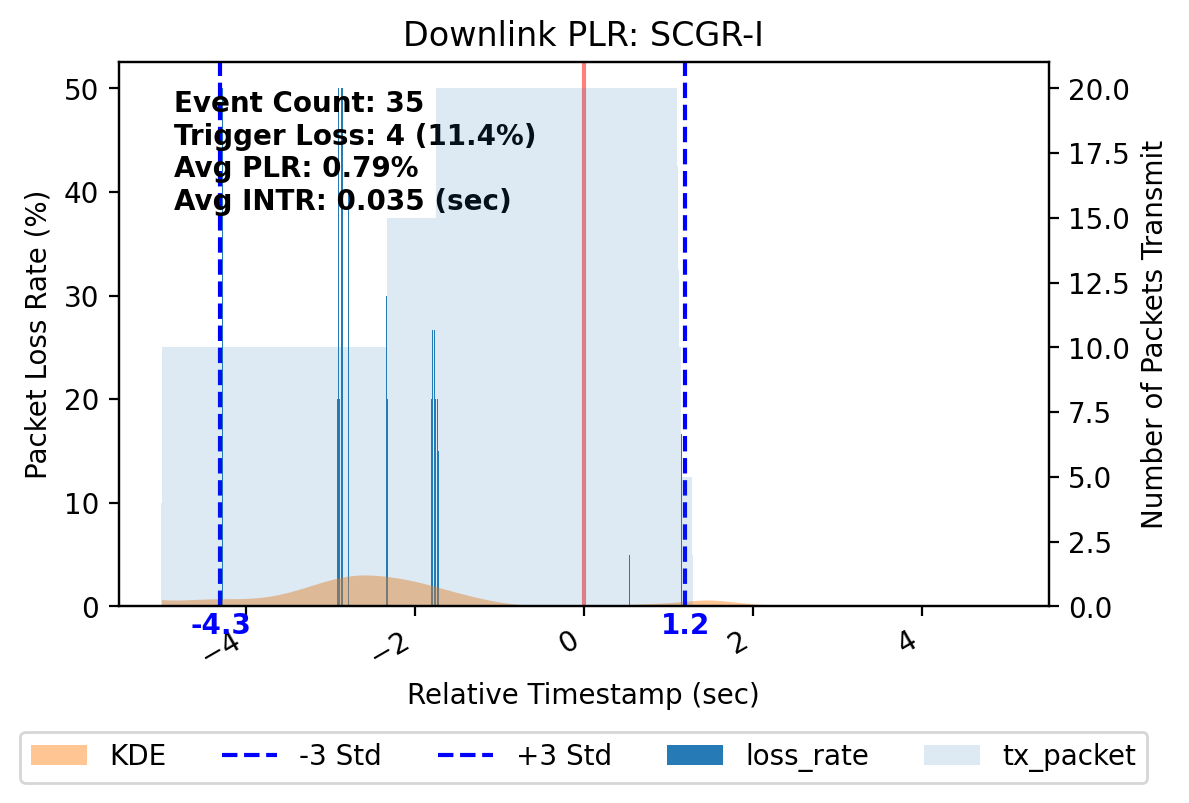

./models/20240312_150032342e/plot/SCGR-II_BR_prior.png


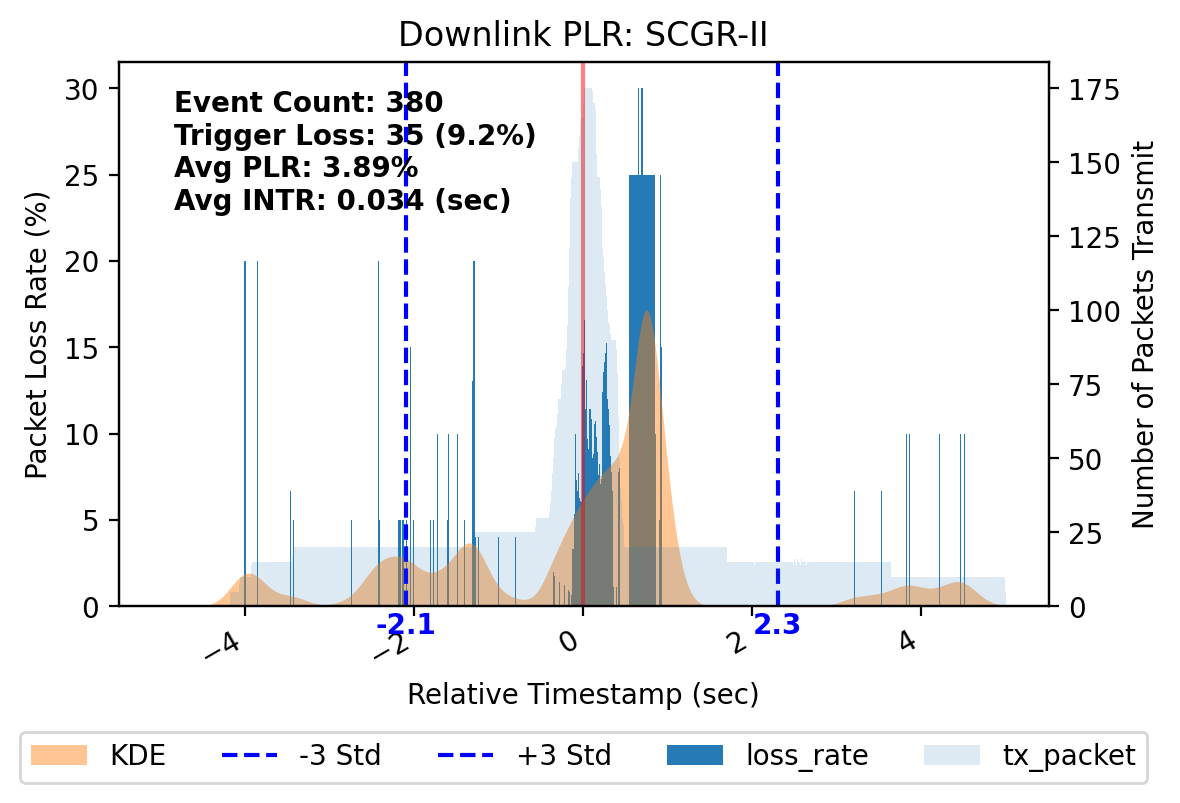

./models/20240312_150032342e/plot/SCGC-I_BR_prior.png


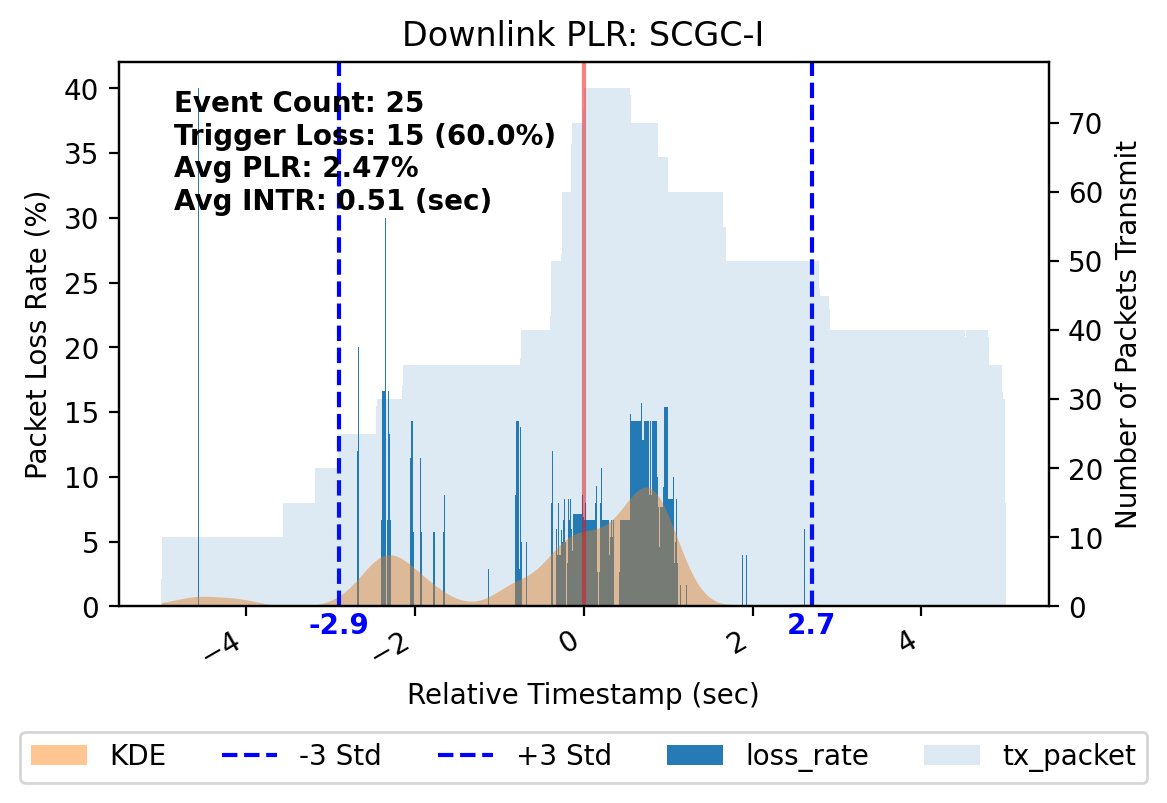

./models/20240312_150032342e/plot/SCGC-II_BR_prior.png


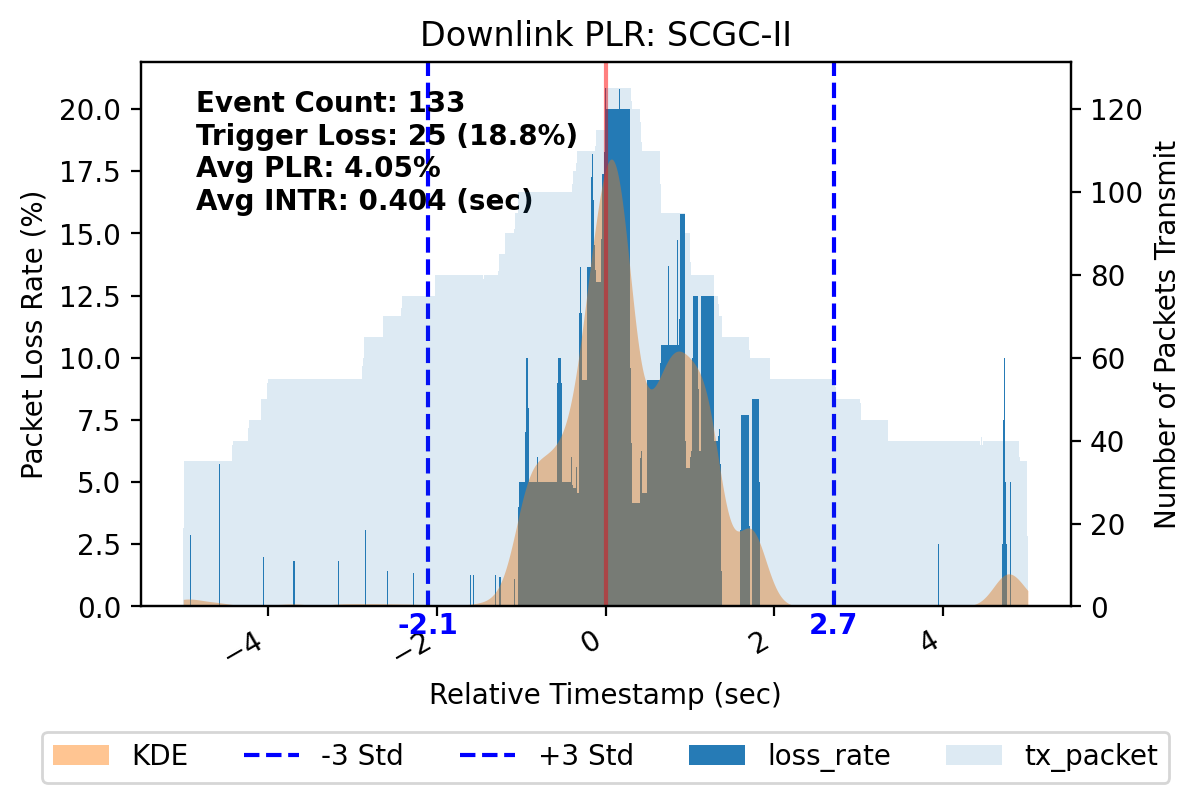

./models/20240312_150032342e/plot/SCGF_BR_prior.png


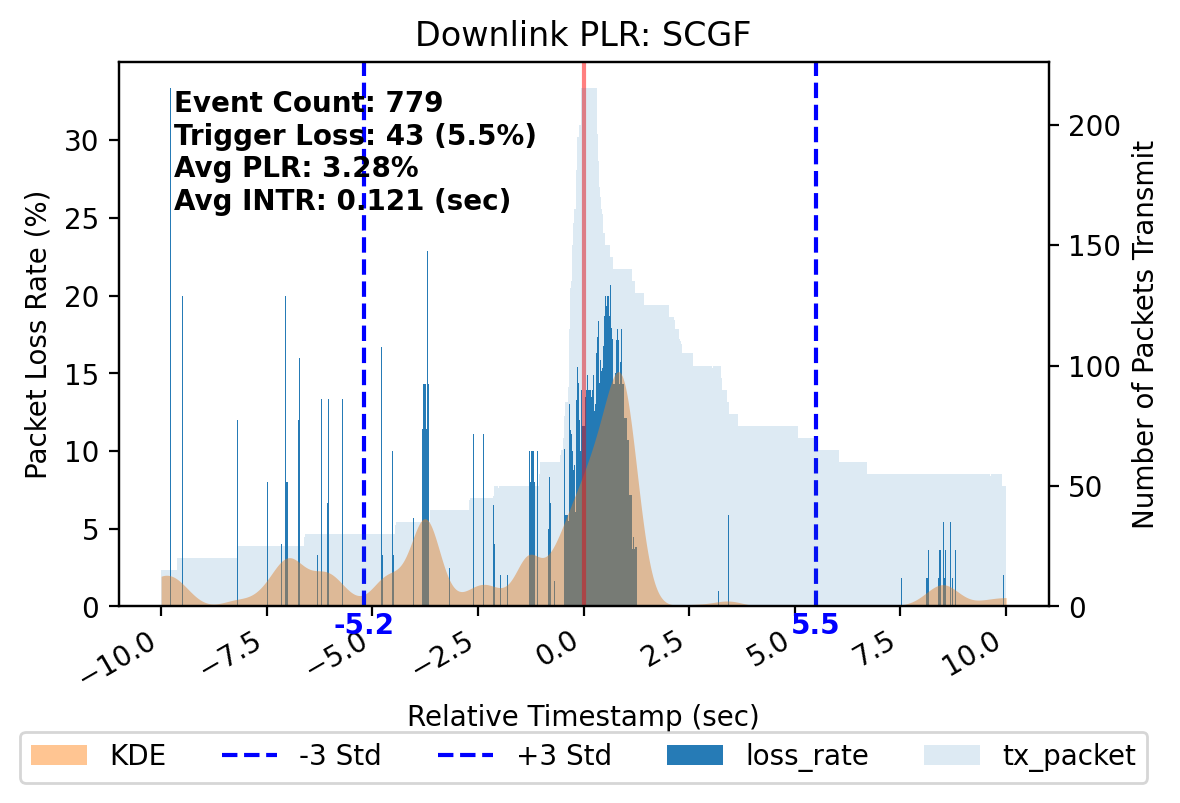

./models/20240312_150032342e/plot/MCGF_BR_prior.png


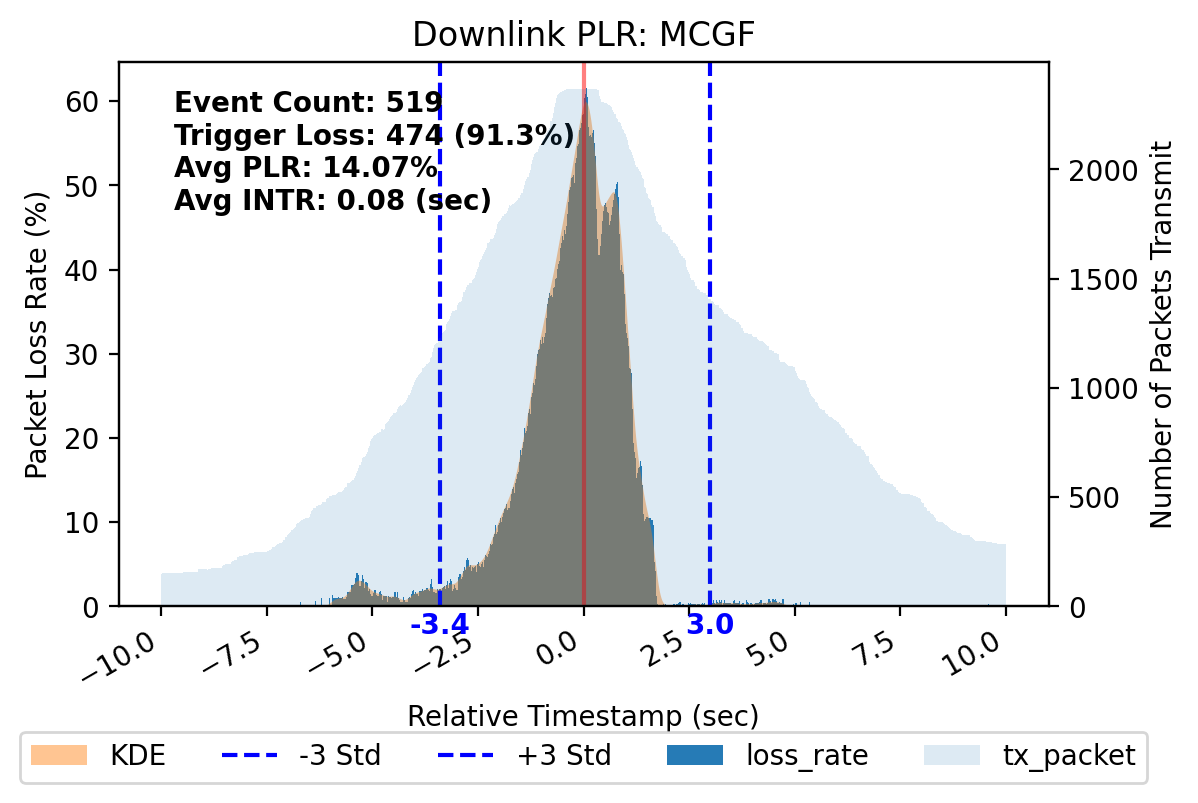

./models/20240312_150032342e/plot/NASR_BR_prior.png


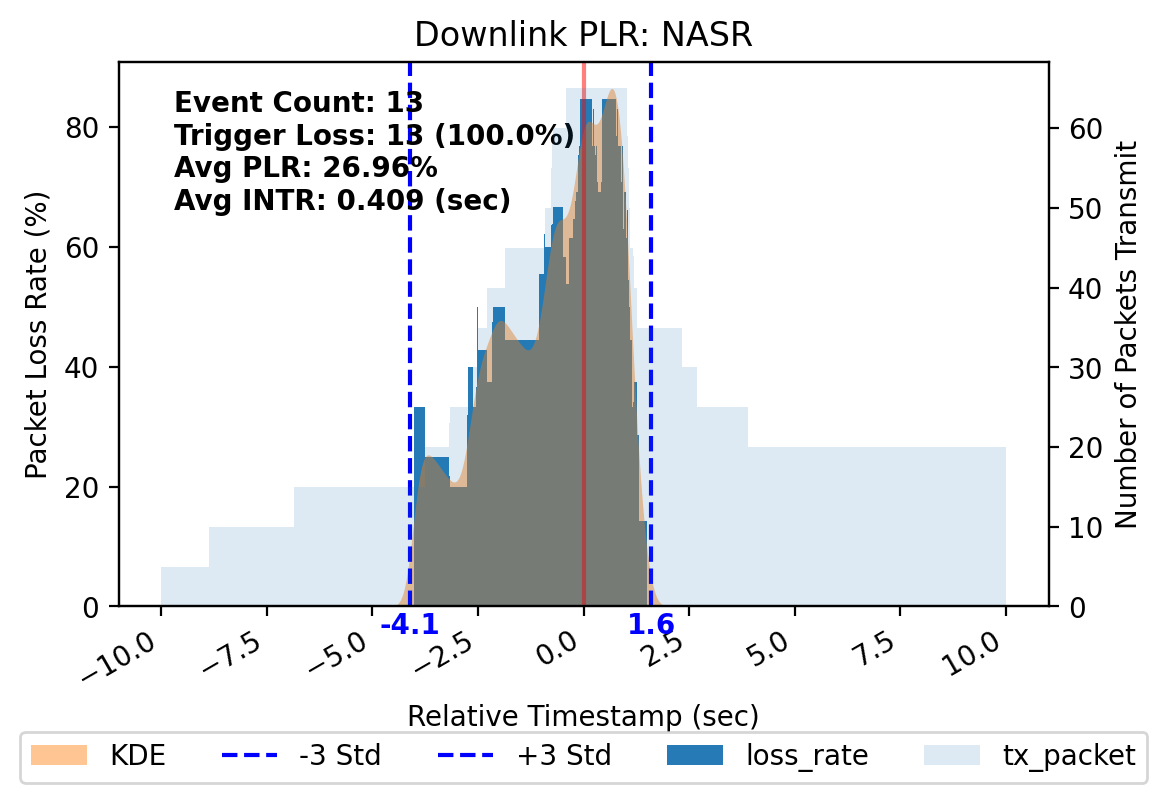

./models/20240312_150032342e/plot/Stable_BR_prior.png


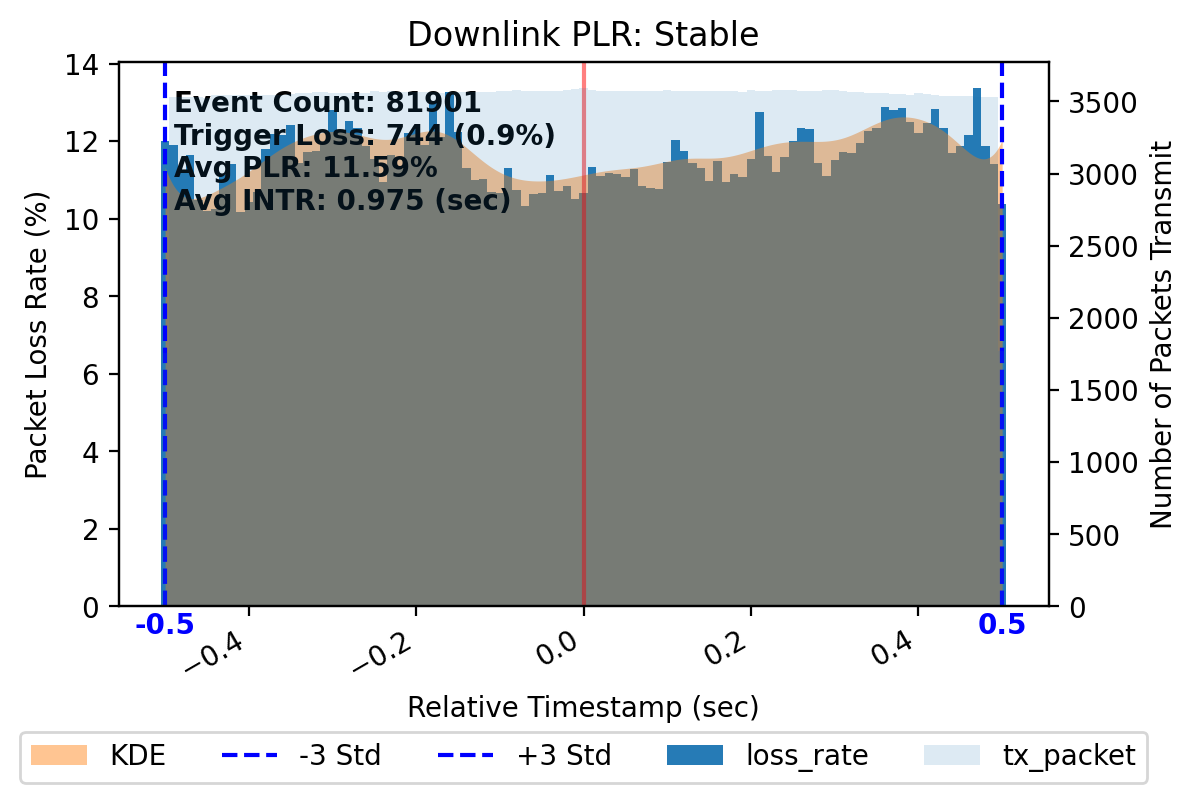

BR
1/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv
1/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv
1/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_uplk_loss_latency.csv
2/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv
2/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_dnlk_loss_latency.csv
2/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_uplk_loss_latency.csv
3/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/handover_info_log.csv
3/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/udp_dnlk_loss_latency.csv
3/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/

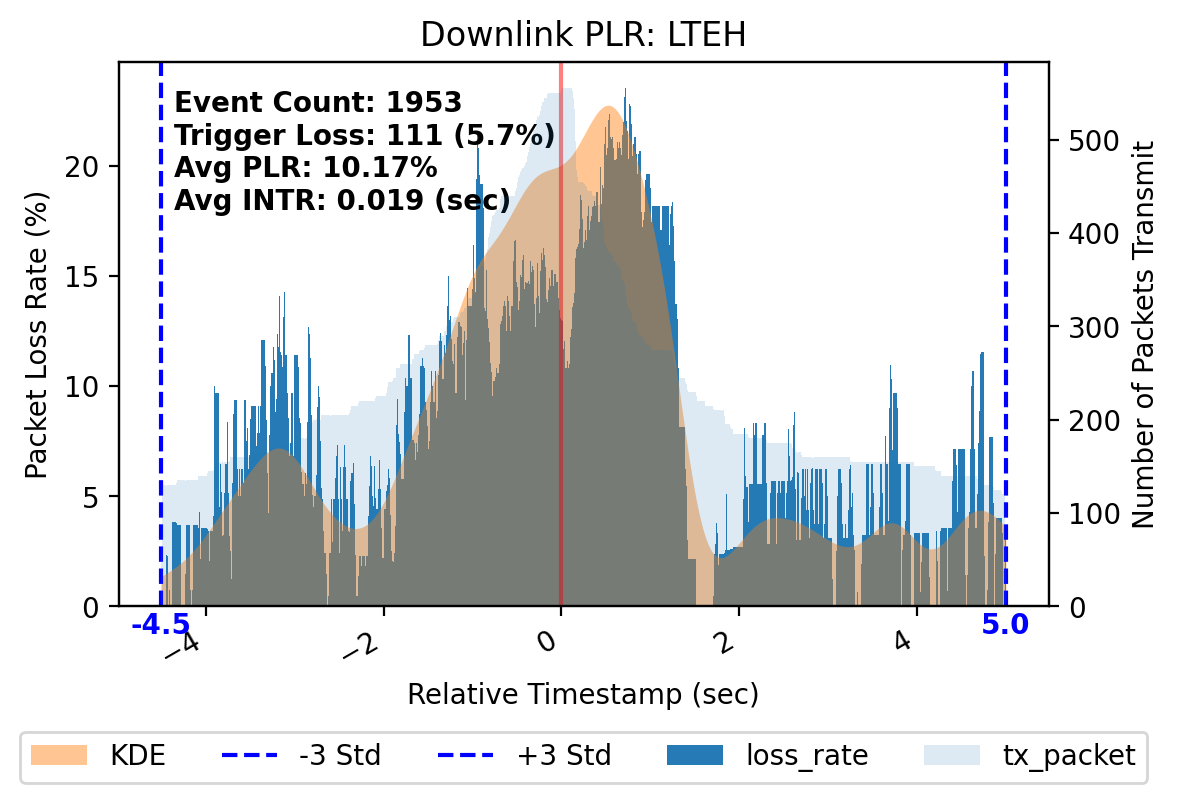

./models/20240312_150032342e/plot/ENBH_BR.png


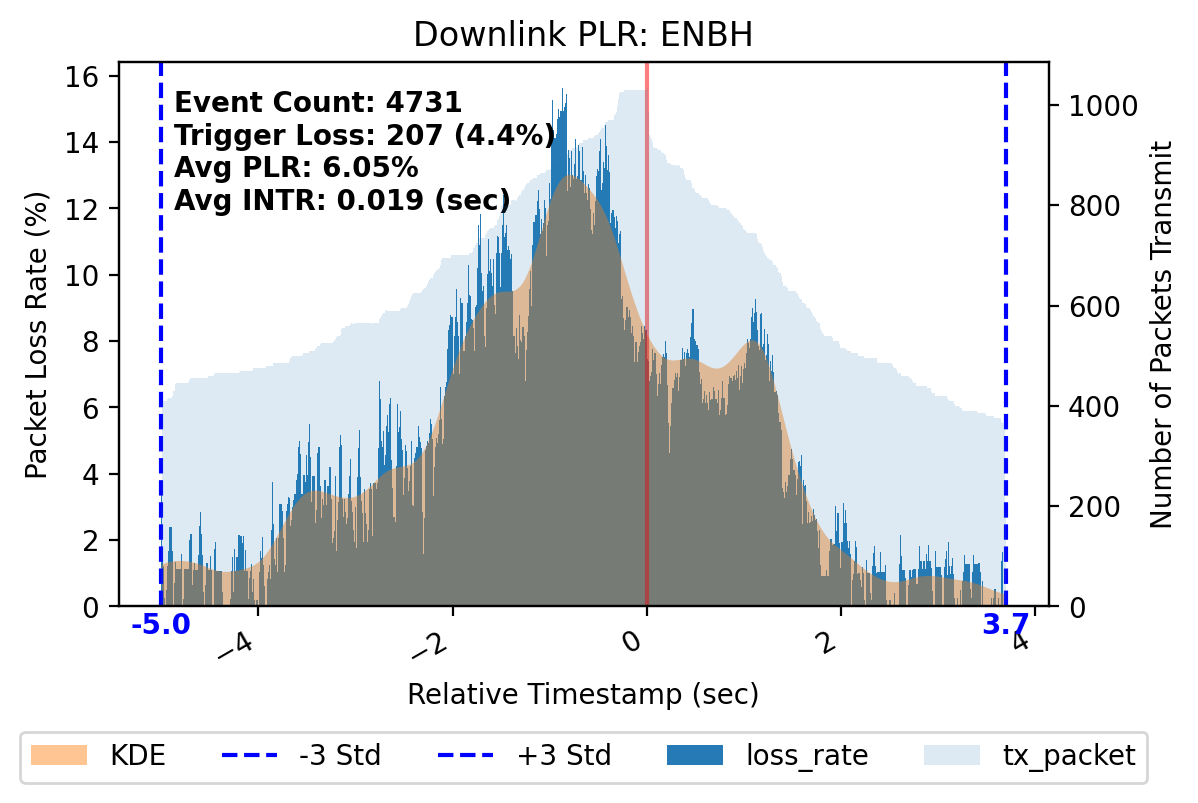

./models/20240312_150032342e/plot/MCGH_BR.png


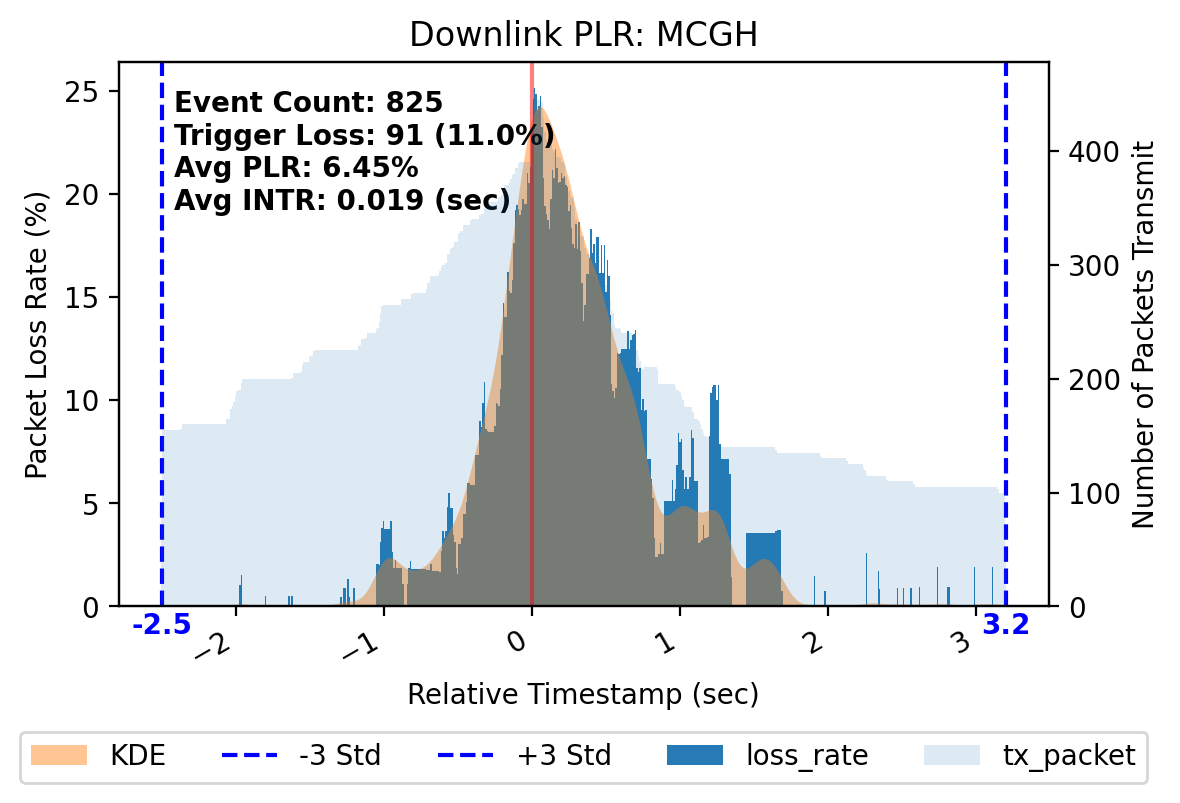

./models/20240312_150032342e/plot/MNBH_BR.png


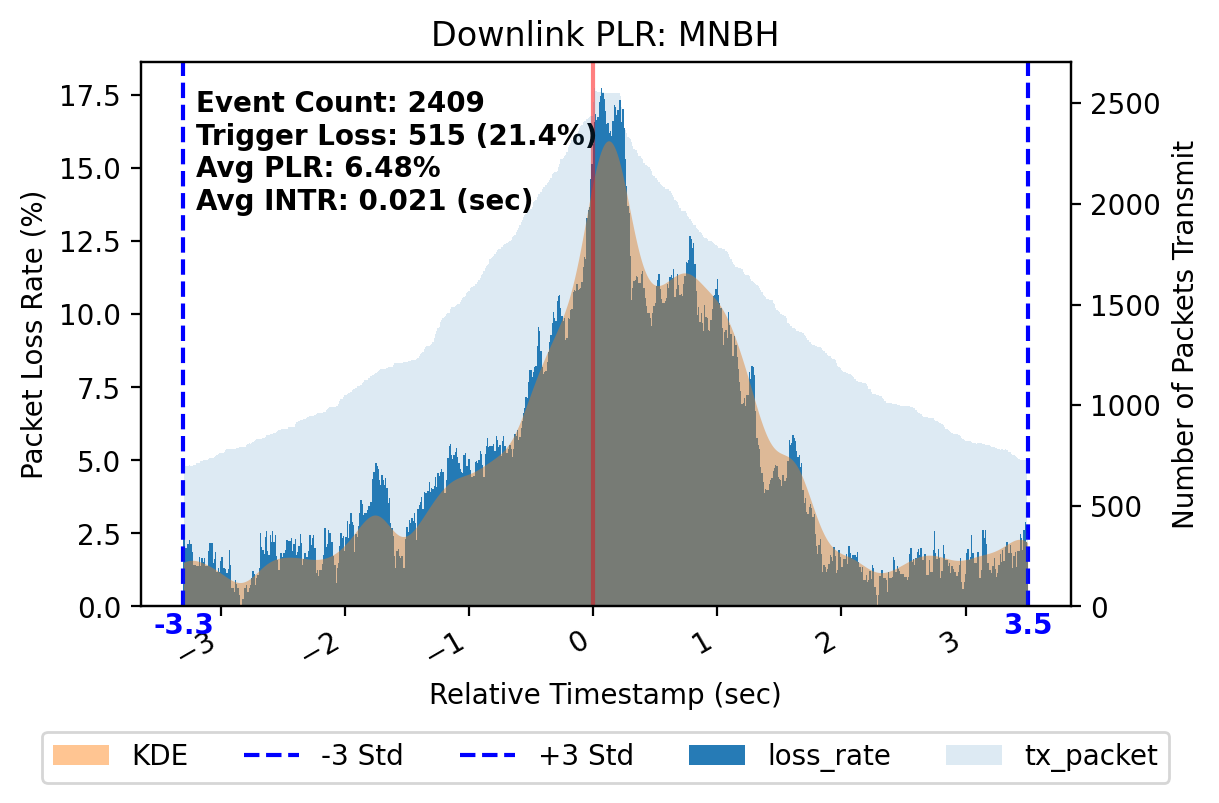

./models/20240312_150032342e/plot/SCGM_BR.png


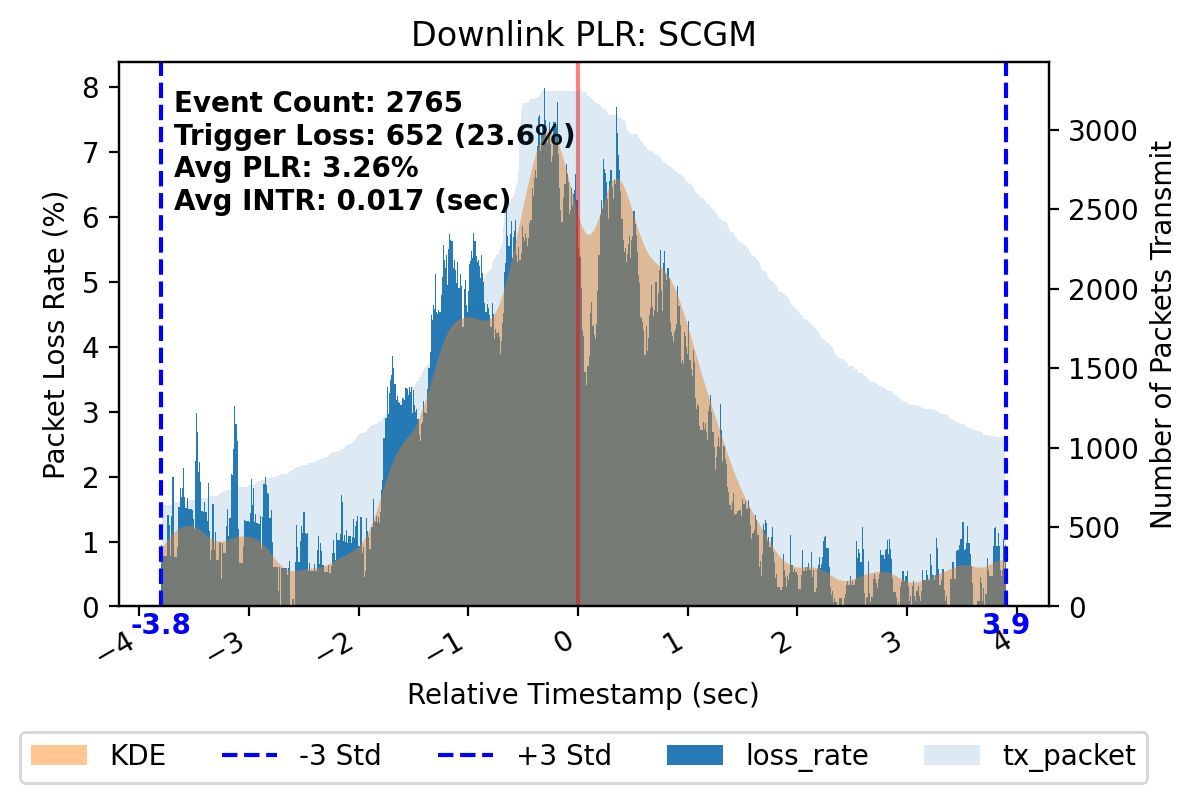

./models/20240312_150032342e/plot/SCGA_BR.png


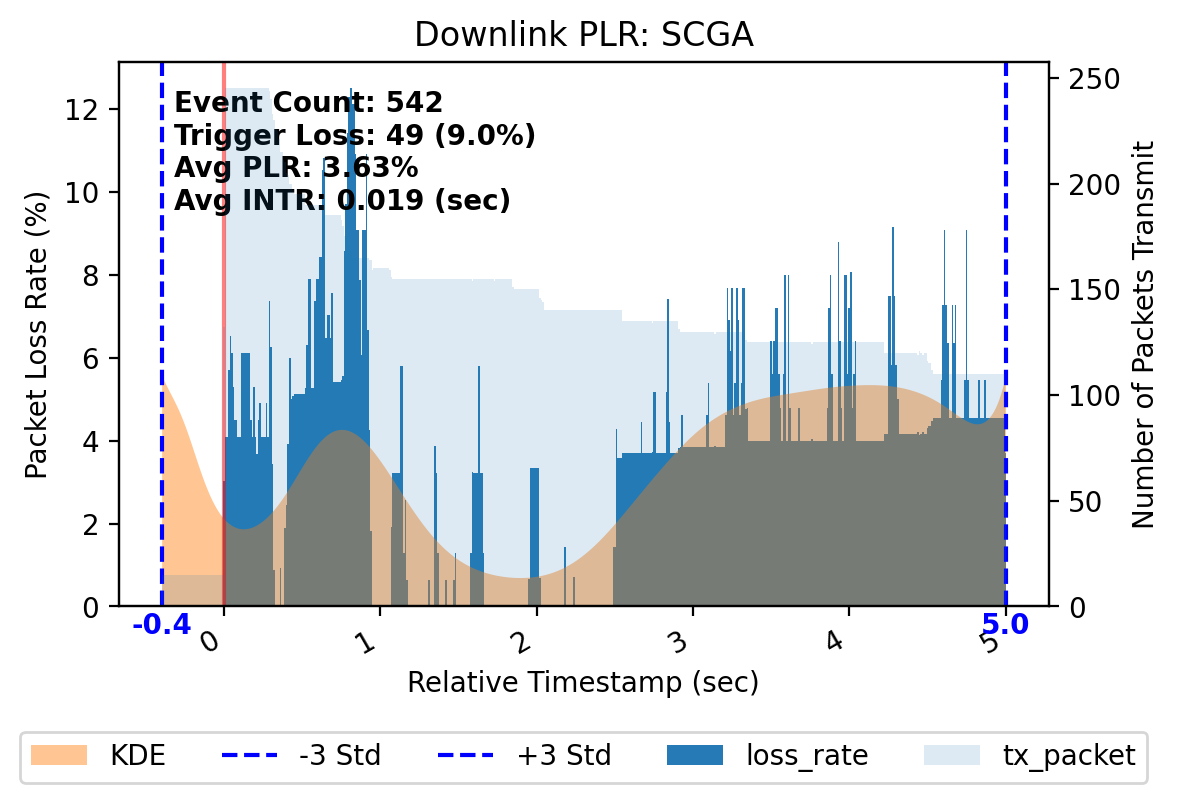

./models/20240312_150032342e/plot/SCGR-I_BR.png


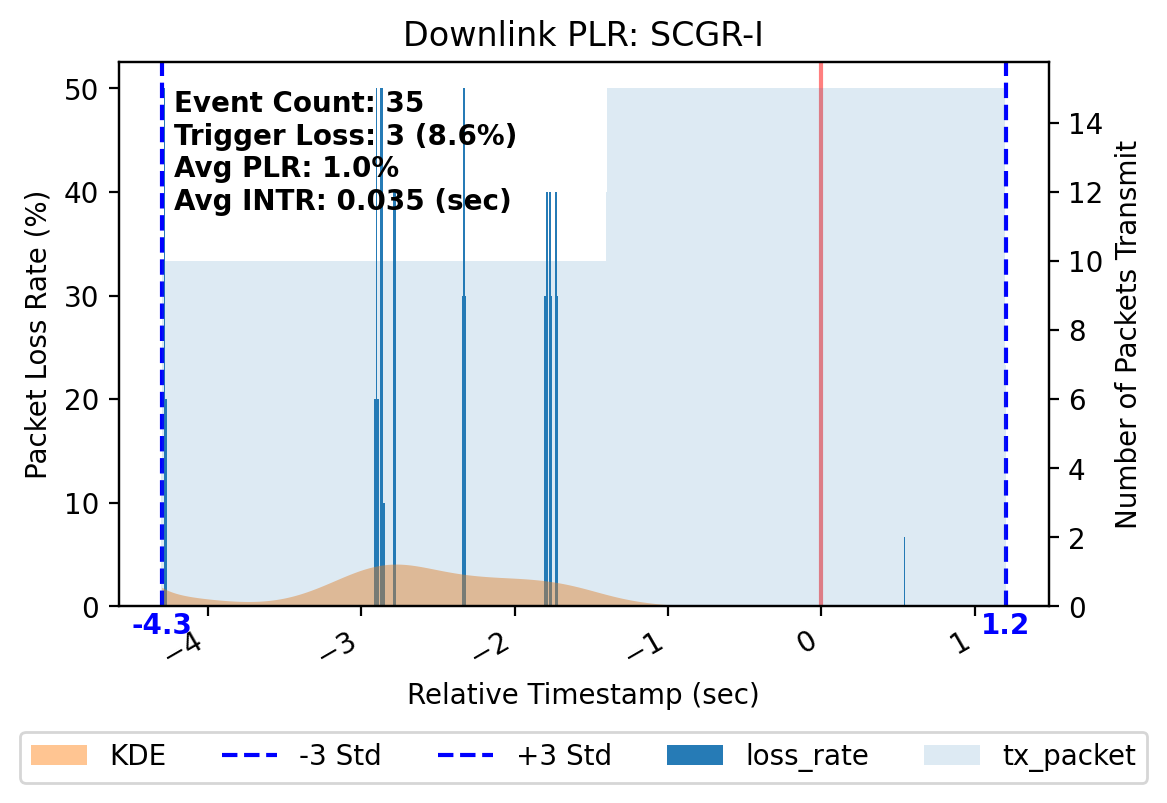

./models/20240312_150032342e/plot/SCGR-II_BR.png


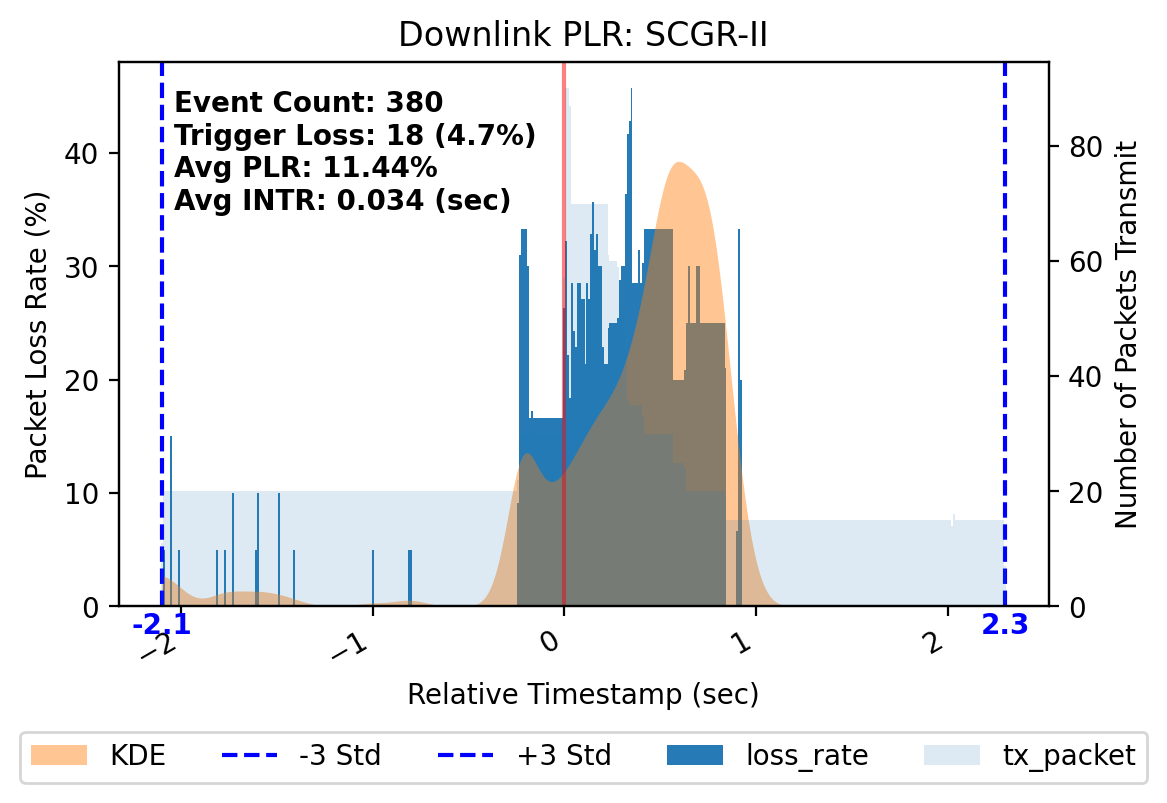

./models/20240312_150032342e/plot/SCGC-I_BR.png


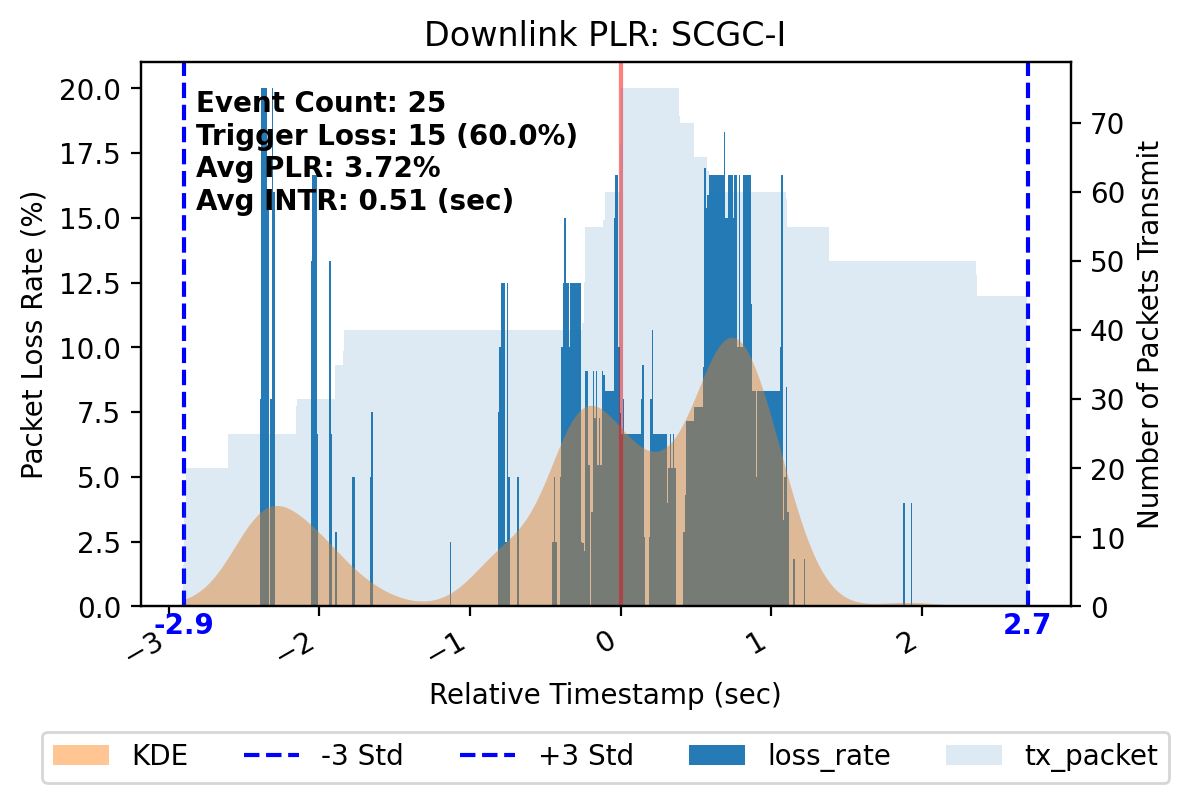

./models/20240312_150032342e/plot/SCGC-II_BR.png


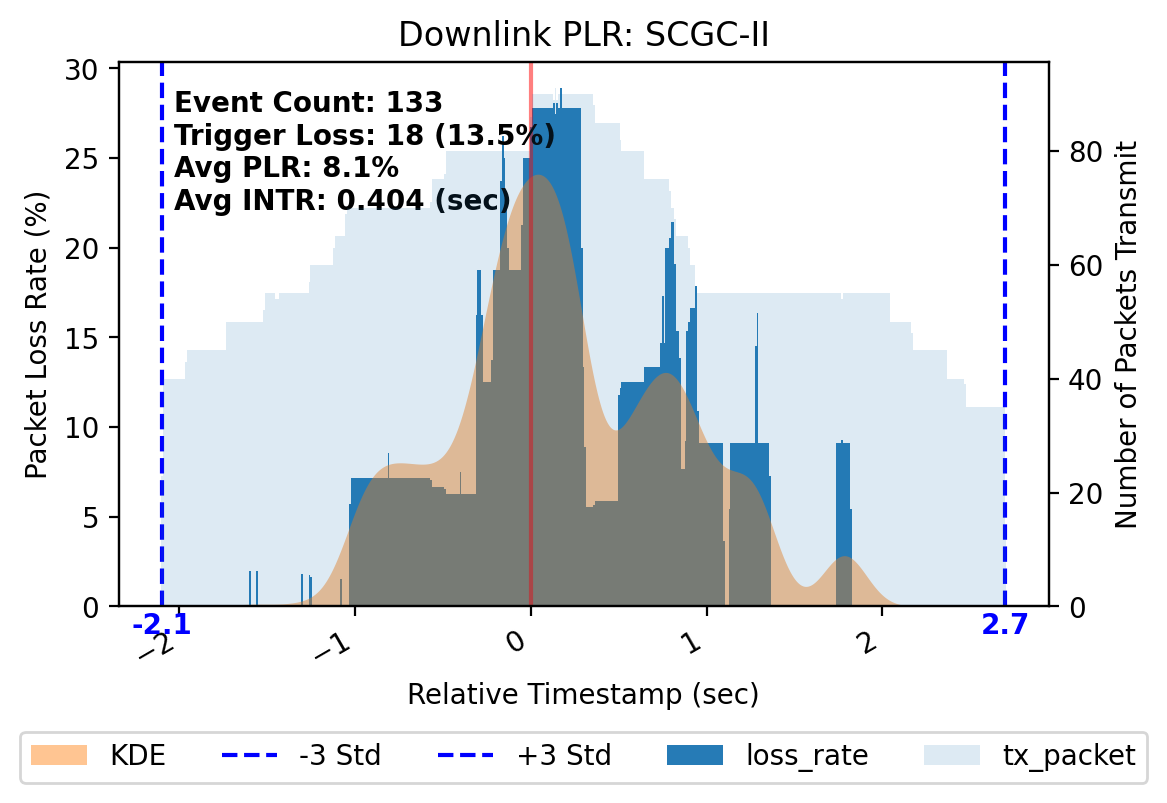

./models/20240312_150032342e/plot/SCGF_BR.png


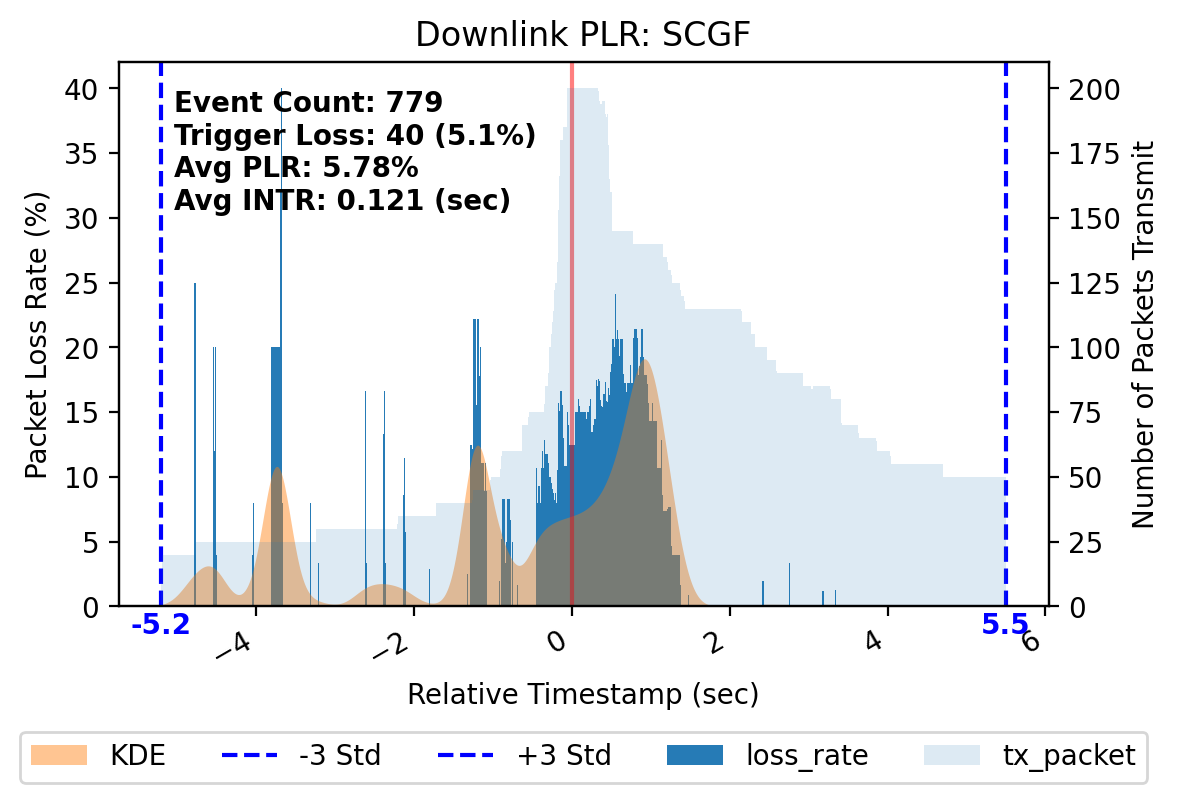

./models/20240312_150032342e/plot/MCGF_BR.png


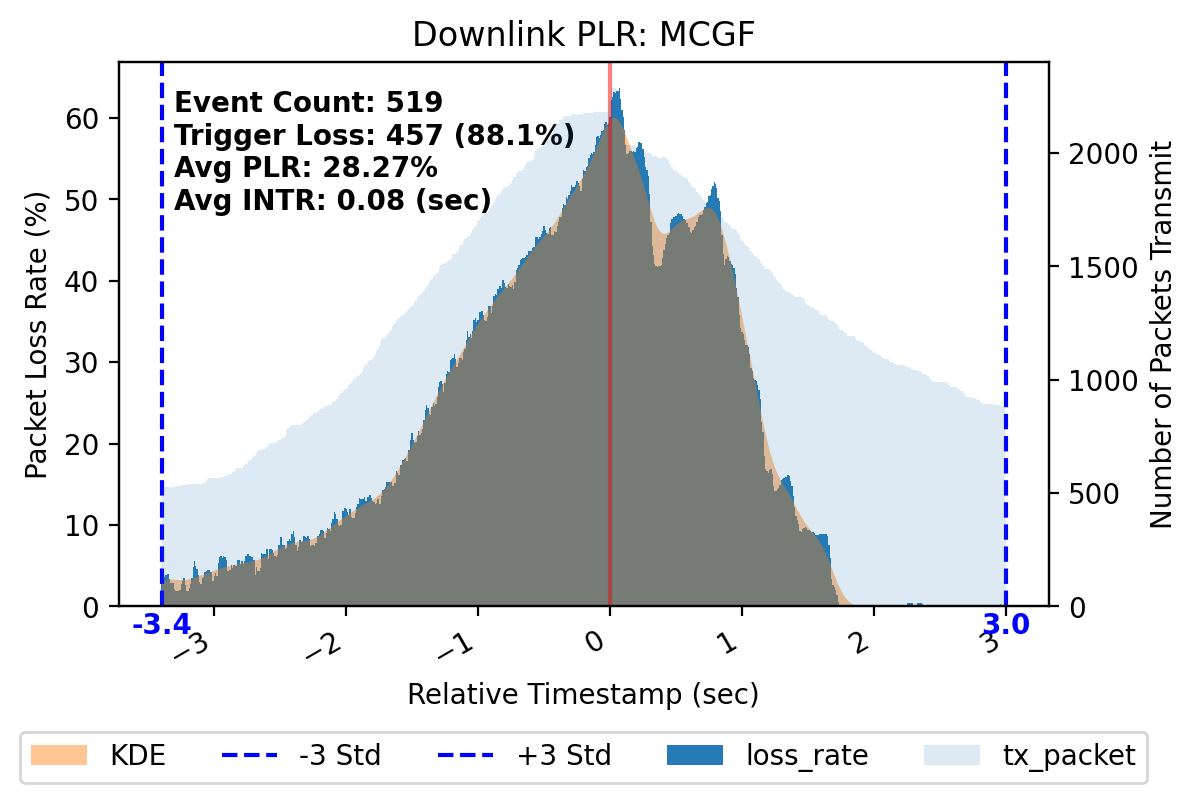

./models/20240312_150032342e/plot/NASR_BR.png


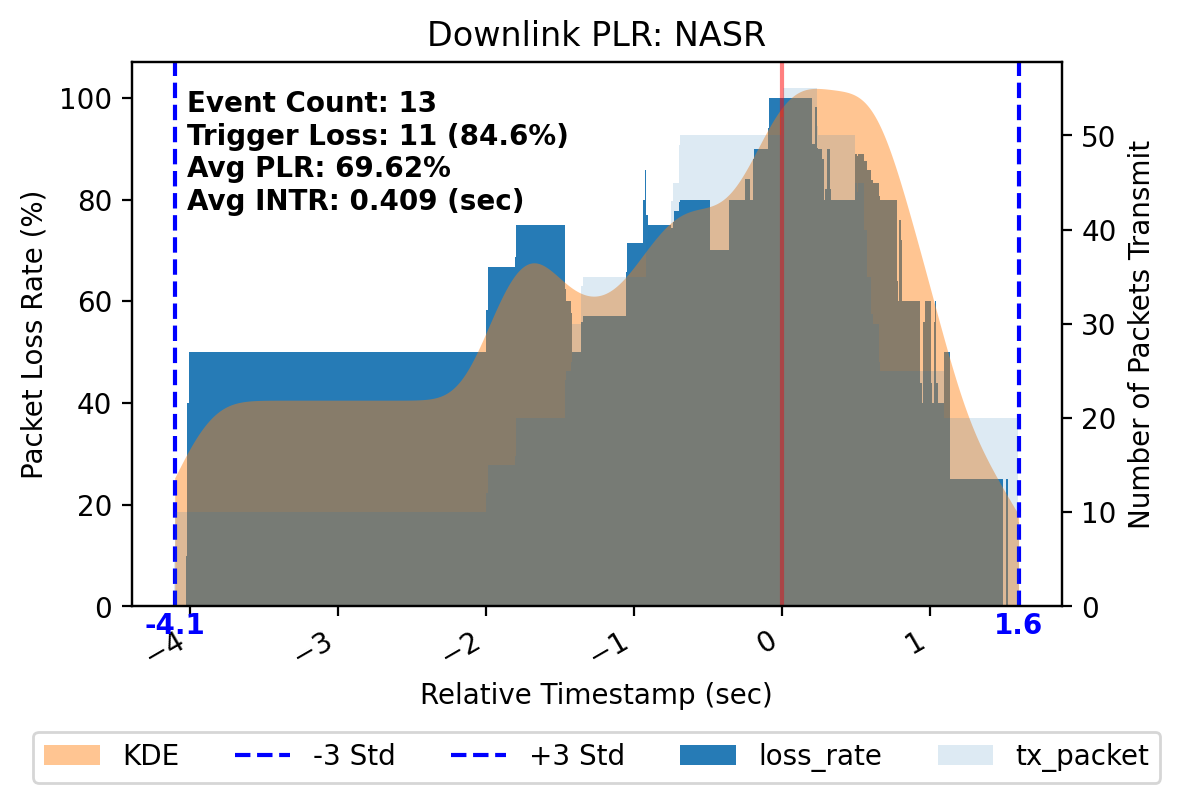

./models/20240312_150032342e/plot/Stable_BR.png


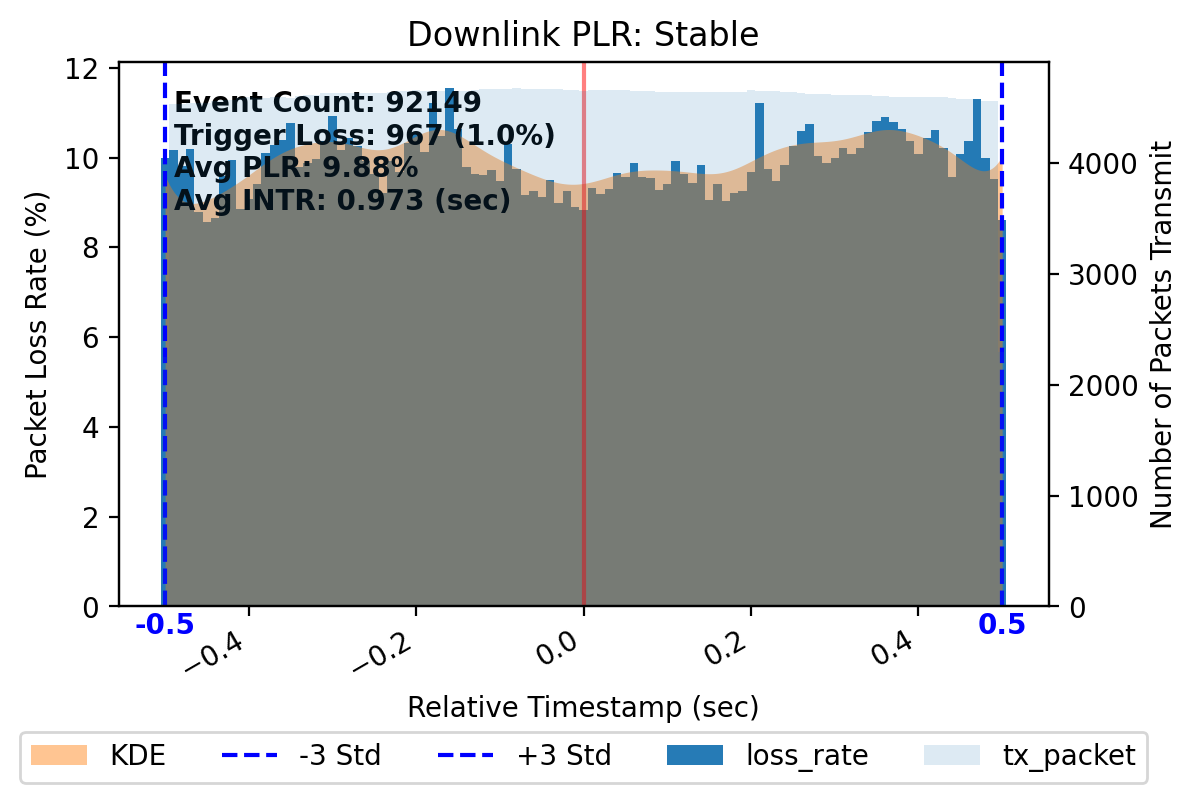

./models/20240312_150032342e/BR



In [25]:
model = Profile(filepaths, 'BR_prior', model_id, metrics=['dl_lost'])
model.plot()
model = Profile(filepaths, 'BR', model_id, 'last', metrics=['dl_lost'], scope_agg=model.scope_models)
model.plot()
model.save_models()

# A Models

In [26]:
# Single Radio Example
dates = data_loader(query_dates=True)

selected_dates = [s for s in dates if s >= '2023-09-12']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['A']
# excluded_routes = []
filepaths = data_loader(mode='sr', selected_dates=selected_dates, selected_routes=selected_routes)

# print(len(filepaths))
# pprint(filepaths)

A_prior
1/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
1/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
1/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv


2/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
2/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
2/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
3/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
3/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
3/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_uplk_loss_latency.csv
4/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
4/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv
4/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#01

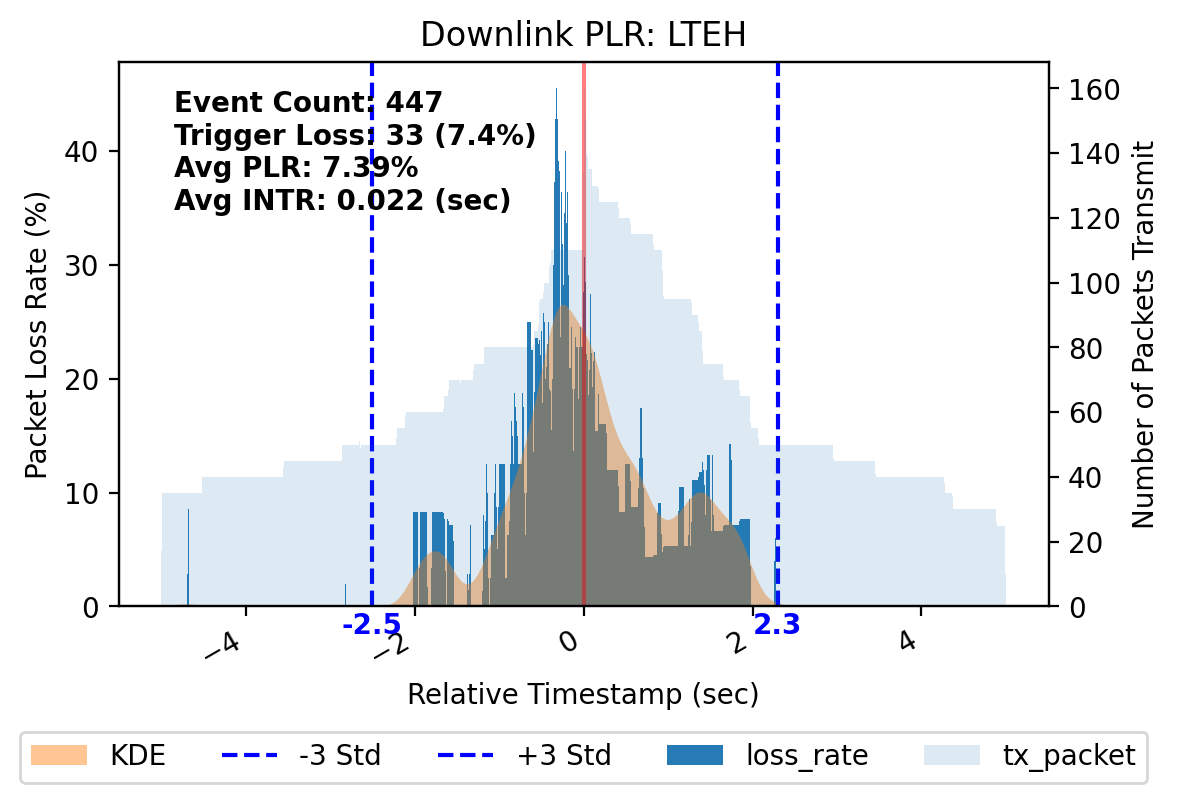

./models/20240312_150032342e/plot/ENBH_A_prior.png


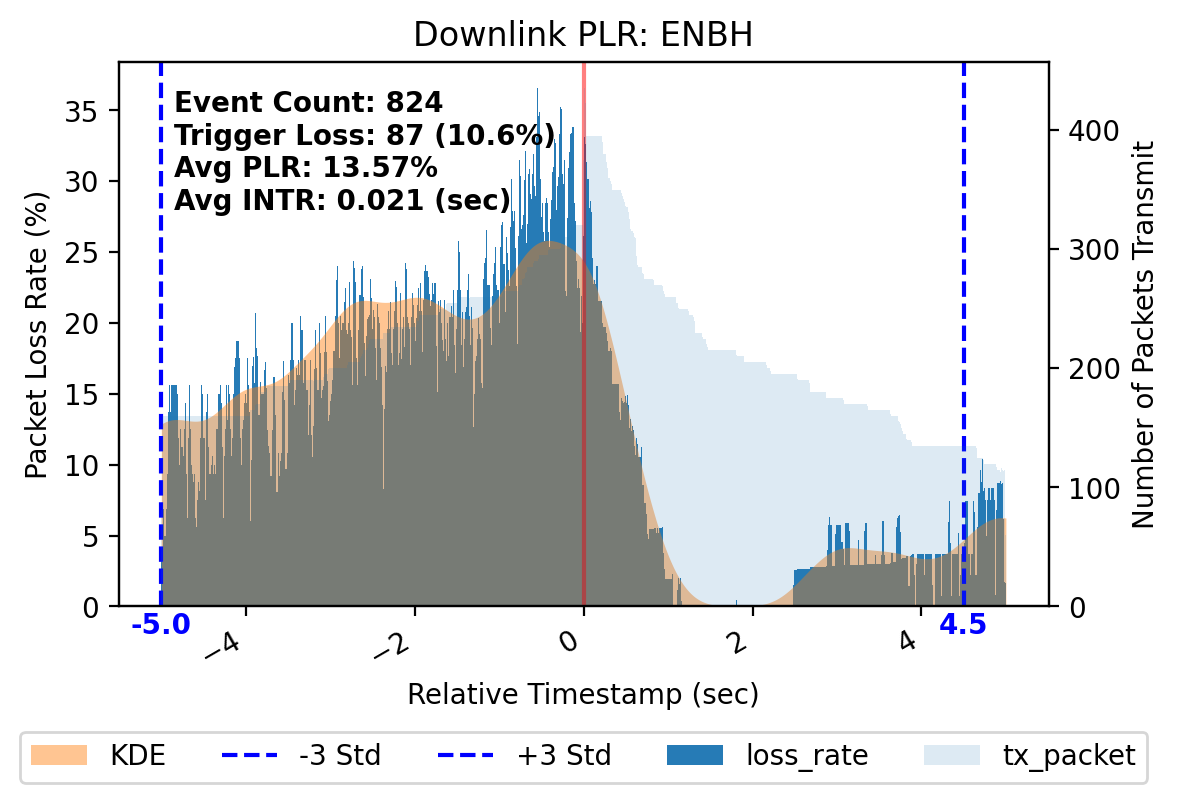

./models/20240312_150032342e/plot/MCGH_A_prior.png


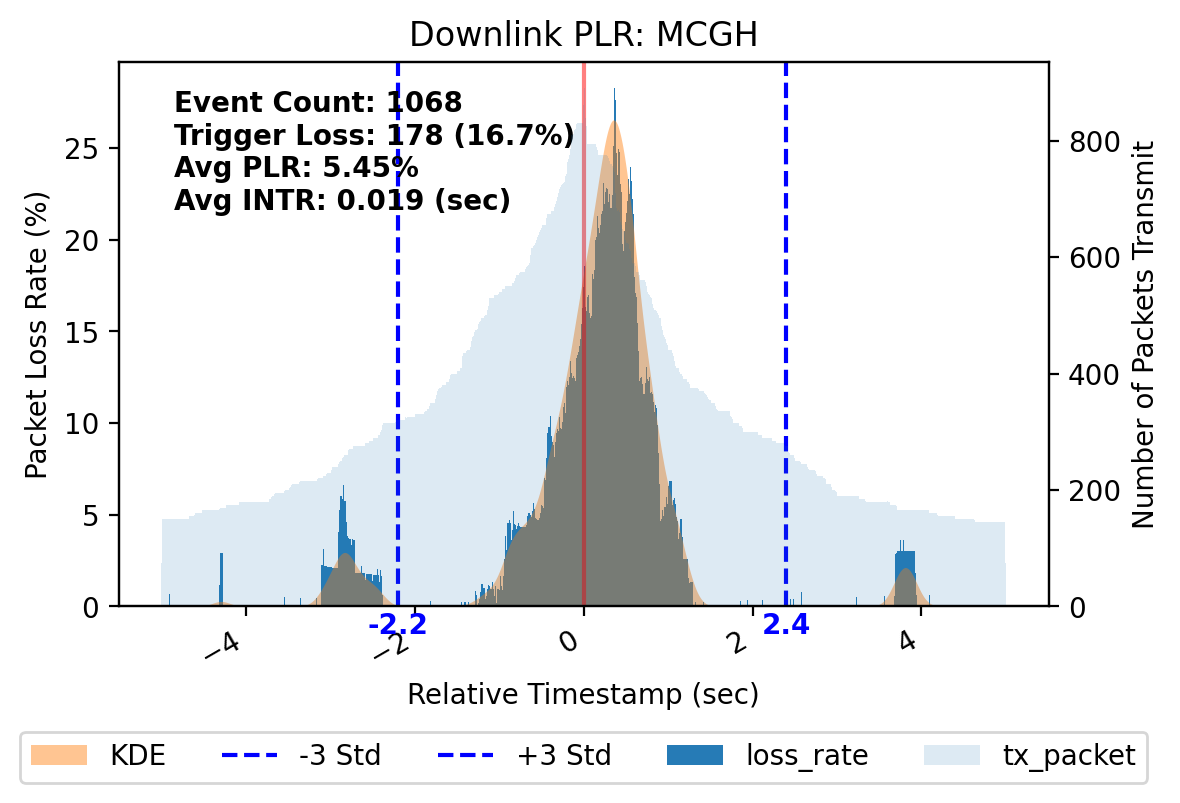

./models/20240312_150032342e/plot/MNBH_A_prior.png


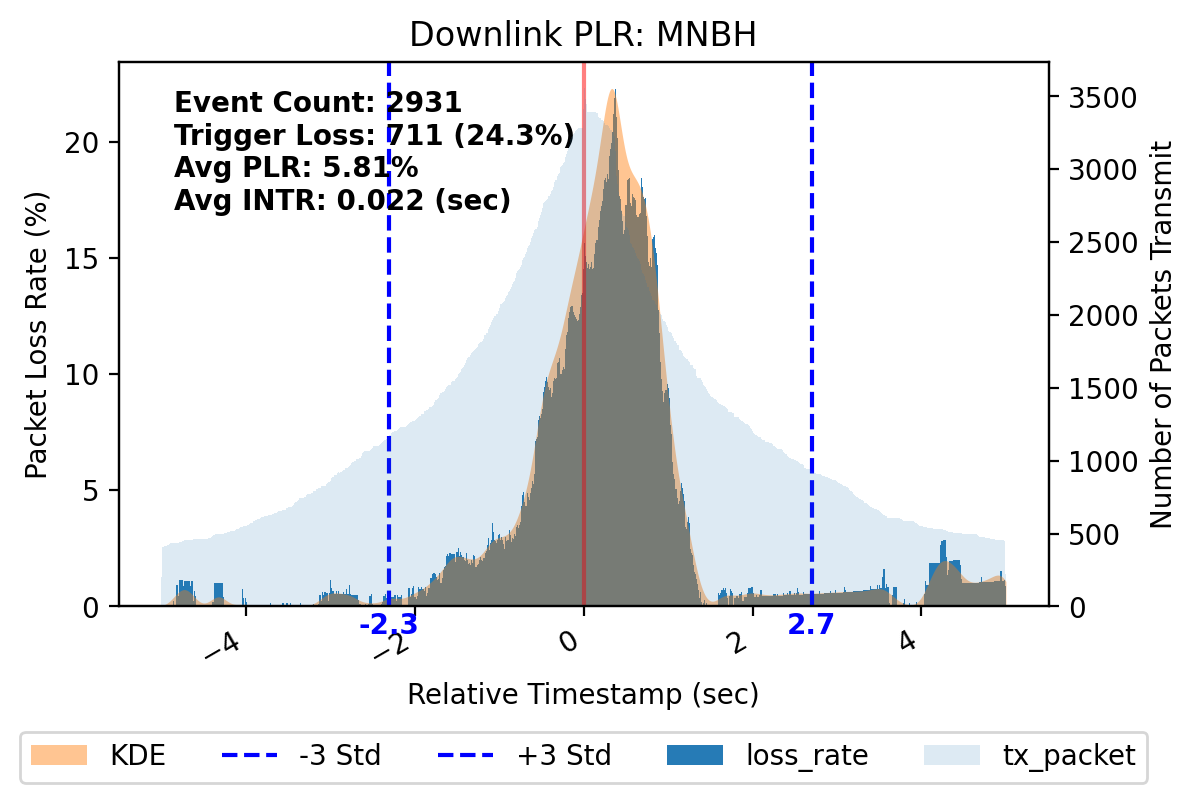

./models/20240312_150032342e/plot/SCGM_A_prior.png


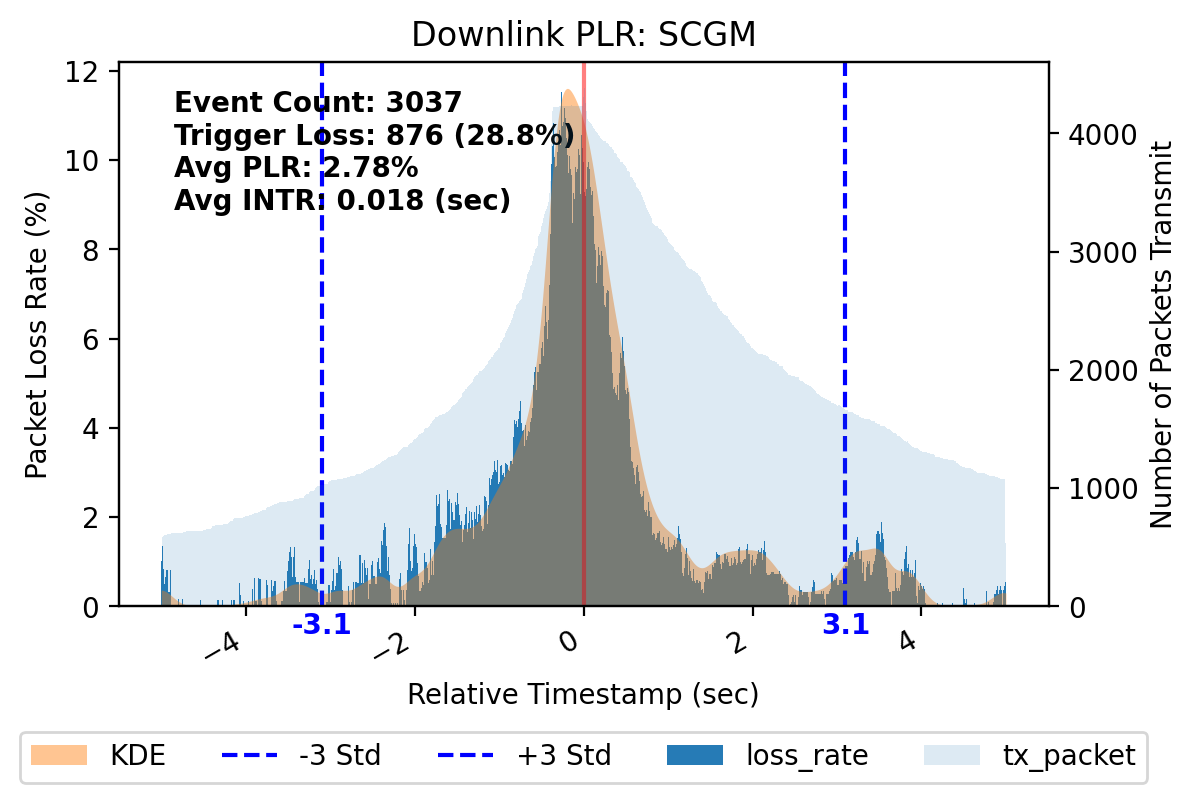

./models/20240312_150032342e/plot/SCGA_A_prior.png


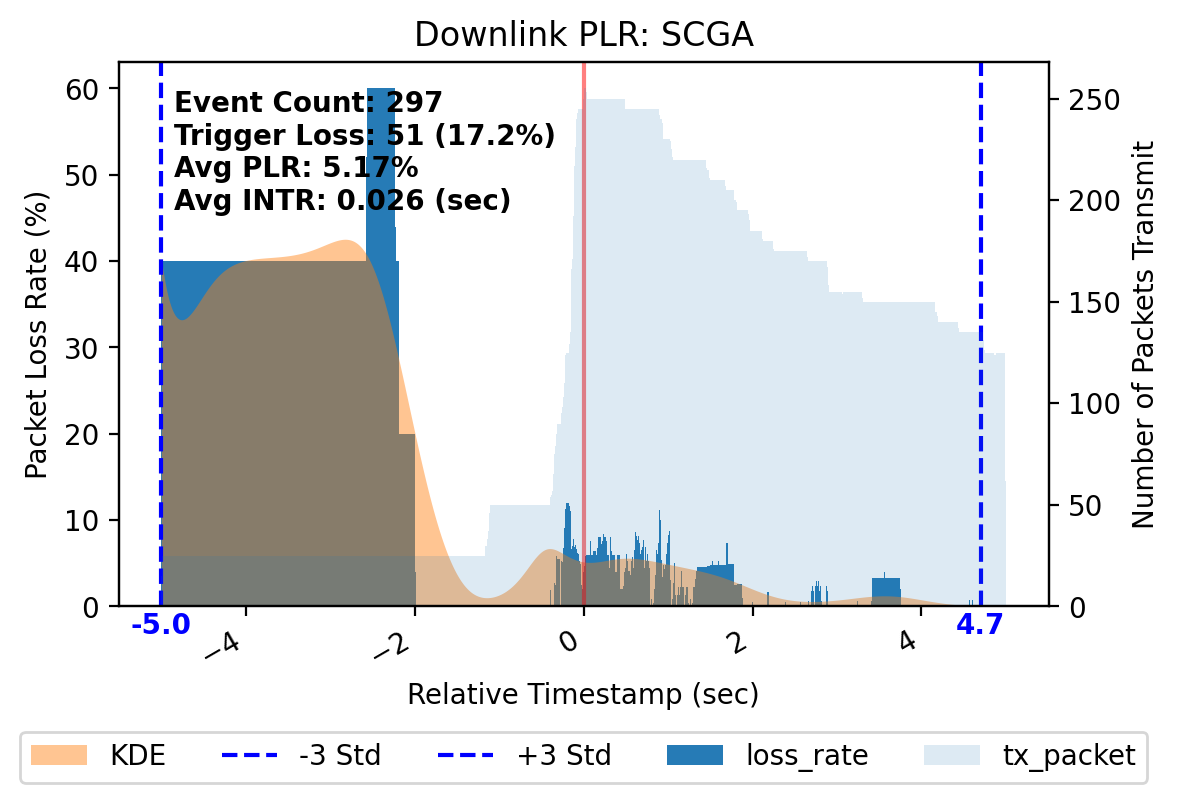

./models/20240312_150032342e/plot/SCGR-I_A_prior.png


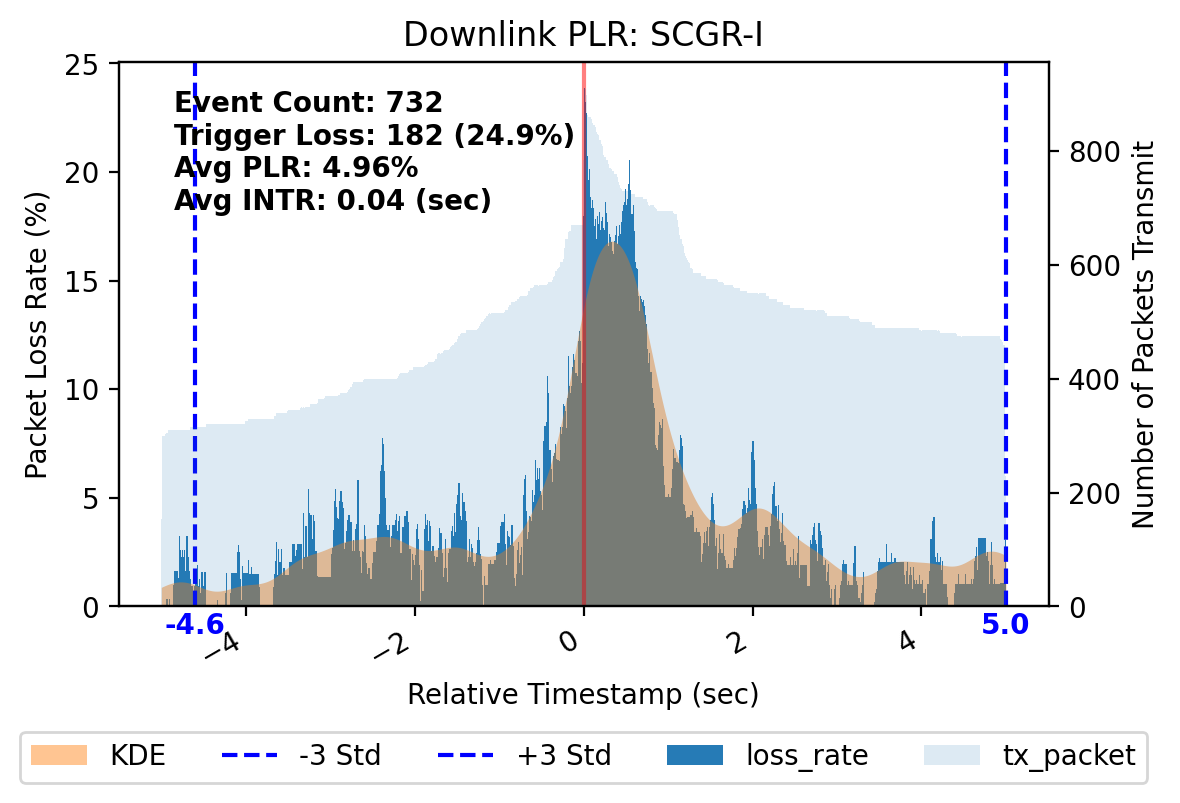

./models/20240312_150032342e/plot/SCGR-II_A_prior.png


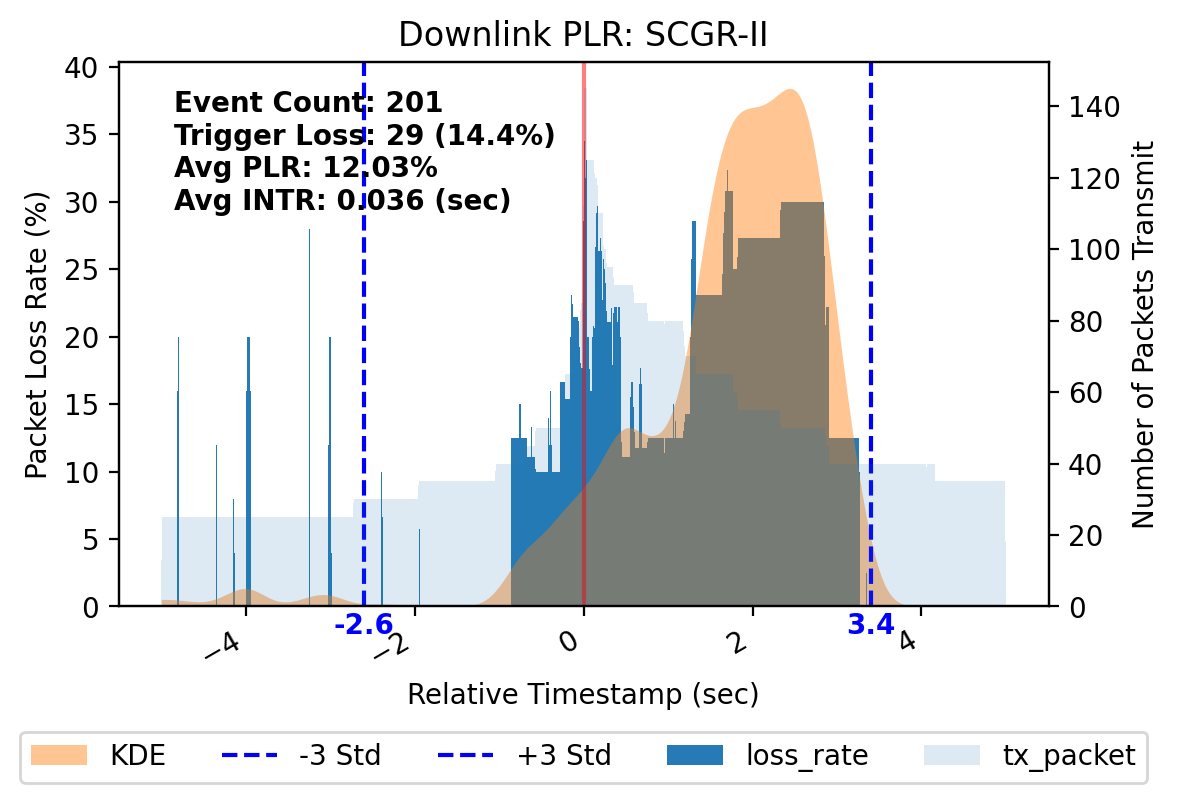

./models/20240312_150032342e/plot/SCGC-I_A_prior.png


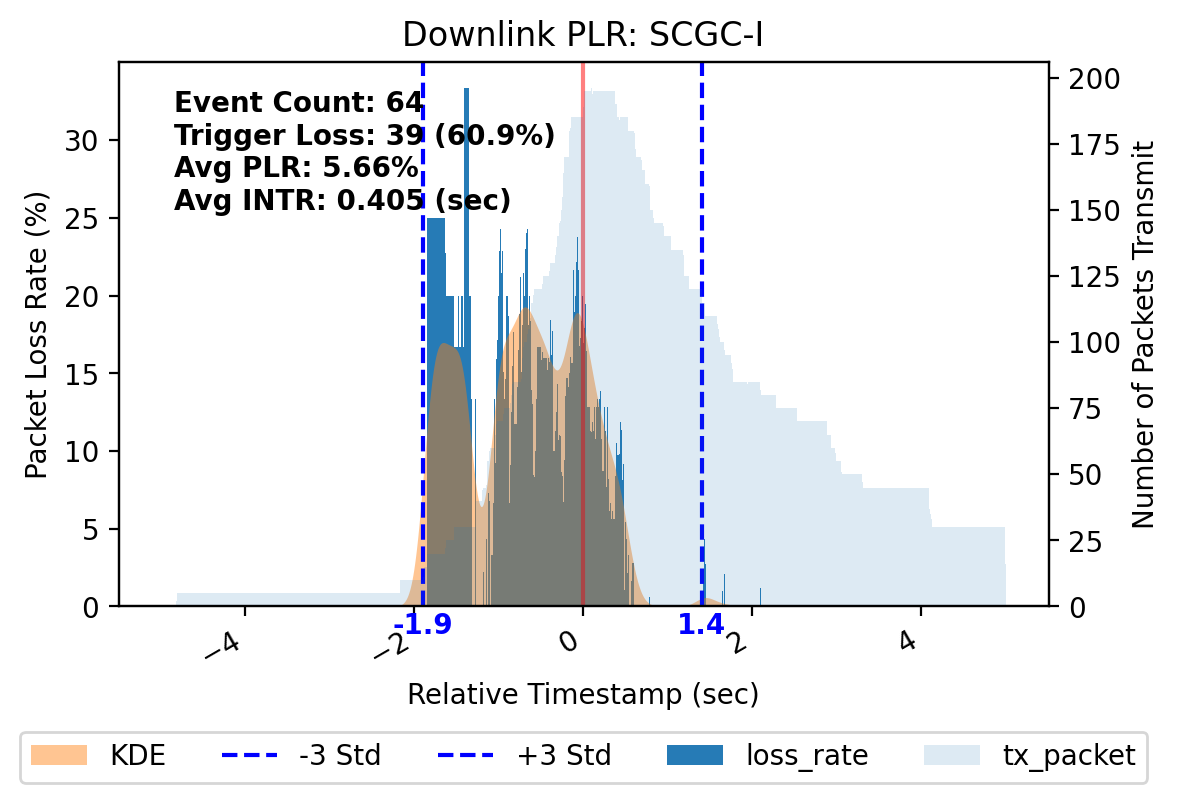

./models/20240312_150032342e/plot/SCGC-II_A_prior.png


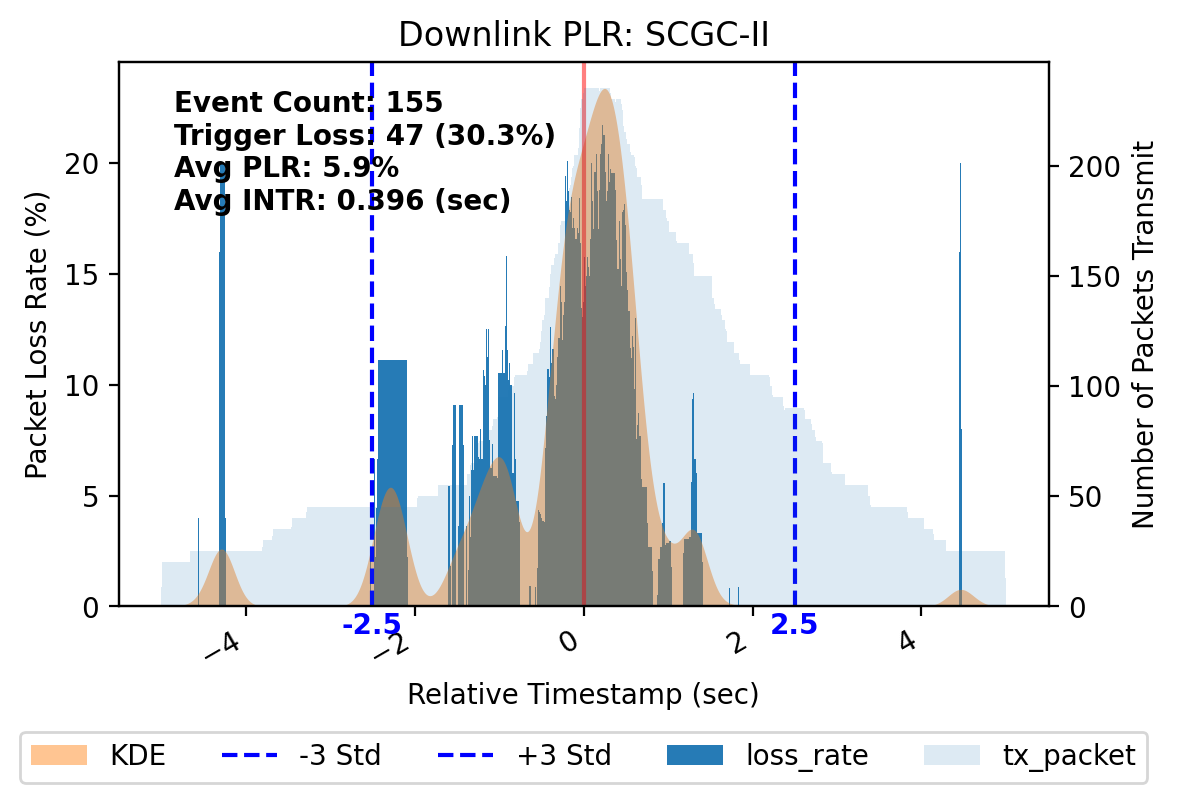

./models/20240312_150032342e/plot/SCGF_A_prior.png


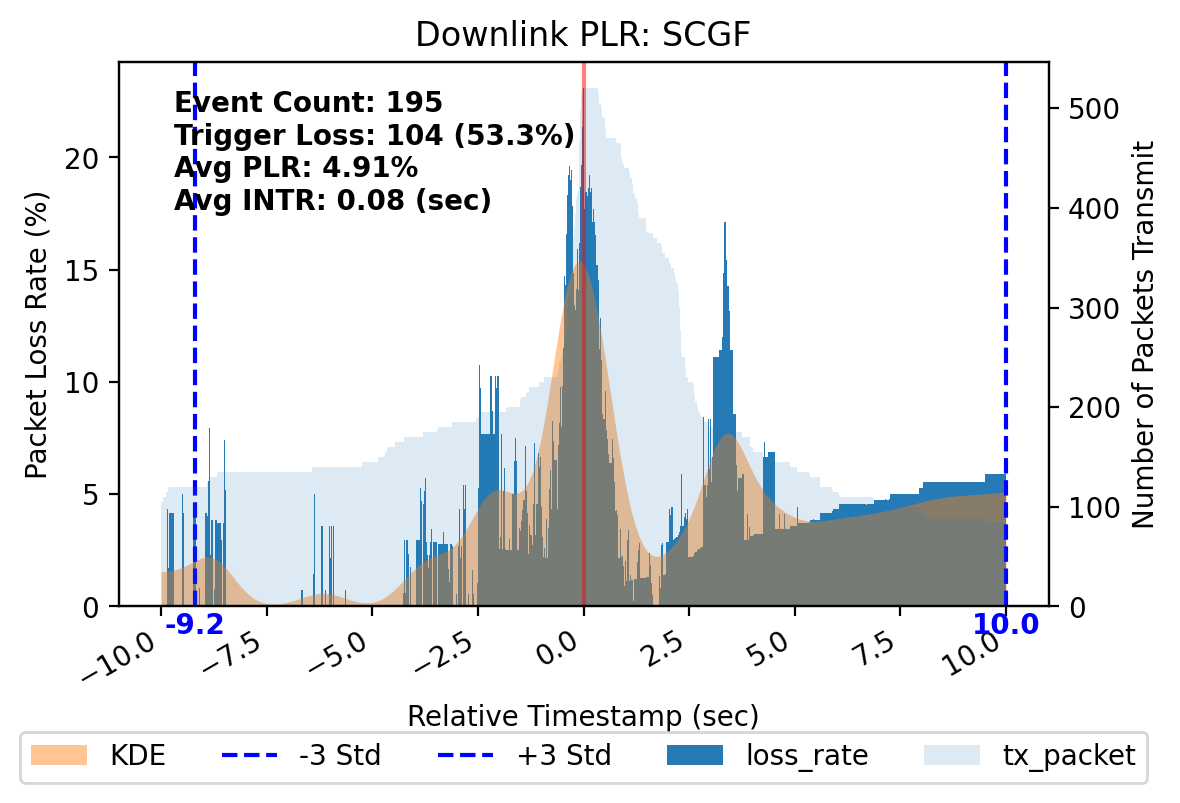

./models/20240312_150032342e/plot/MCGF_A_prior.png


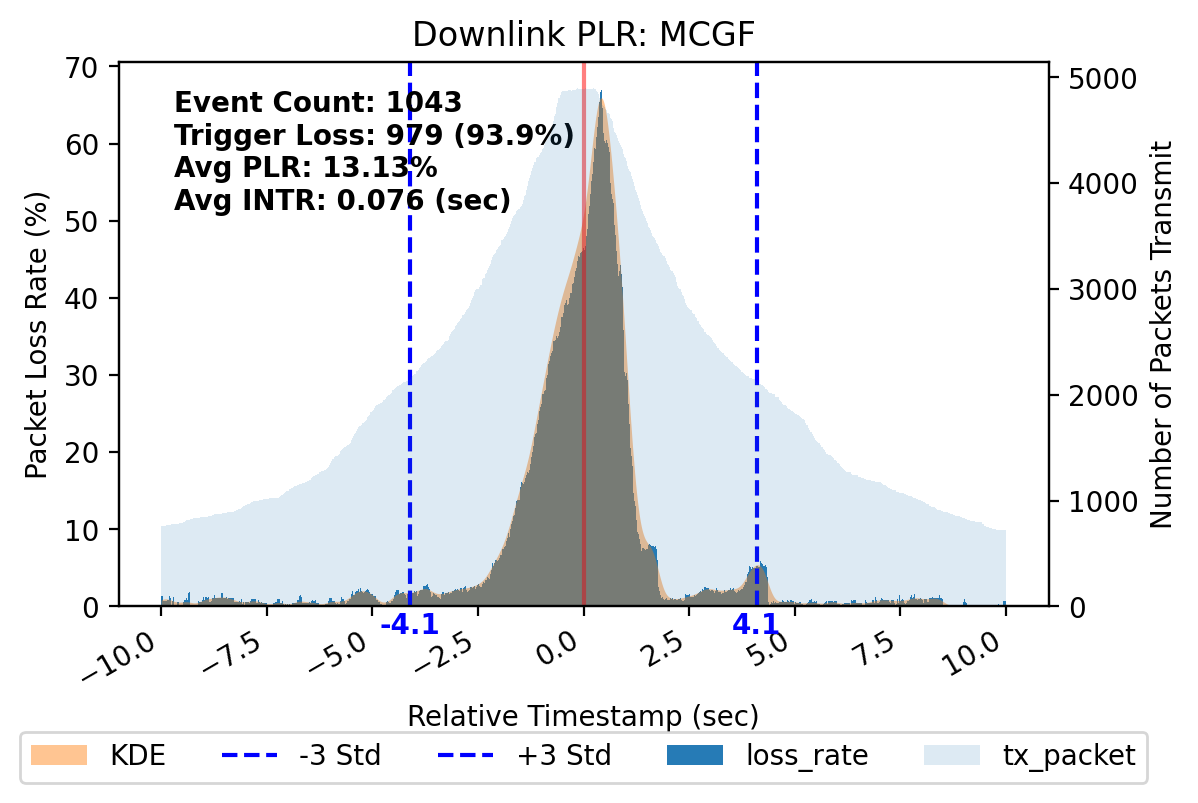

./models/20240312_150032342e/plot/NASR_A_prior.png


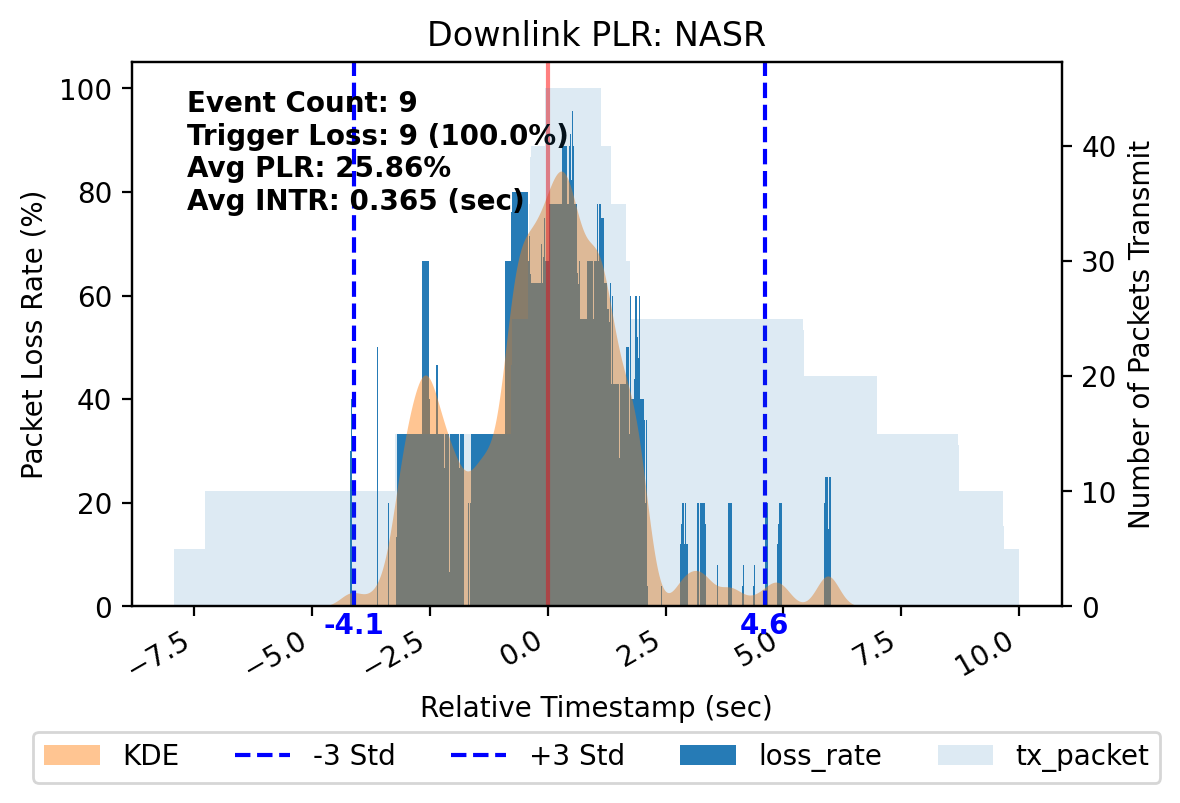

./models/20240312_150032342e/plot/Stable_A_prior.png


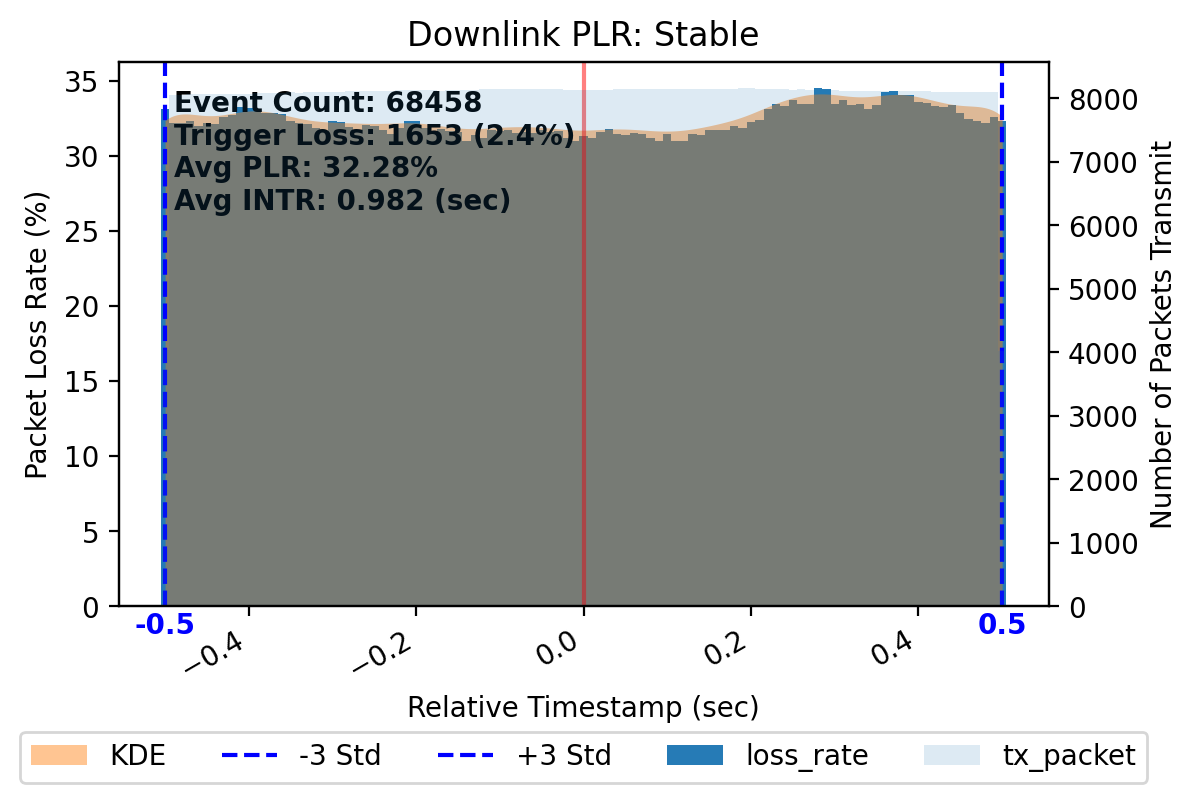

A
1/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
1/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv
1/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_uplk_loss_latency.csv
2/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
2/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv
2/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_uplk_loss_latency.csv
3/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
3/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv
3/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#

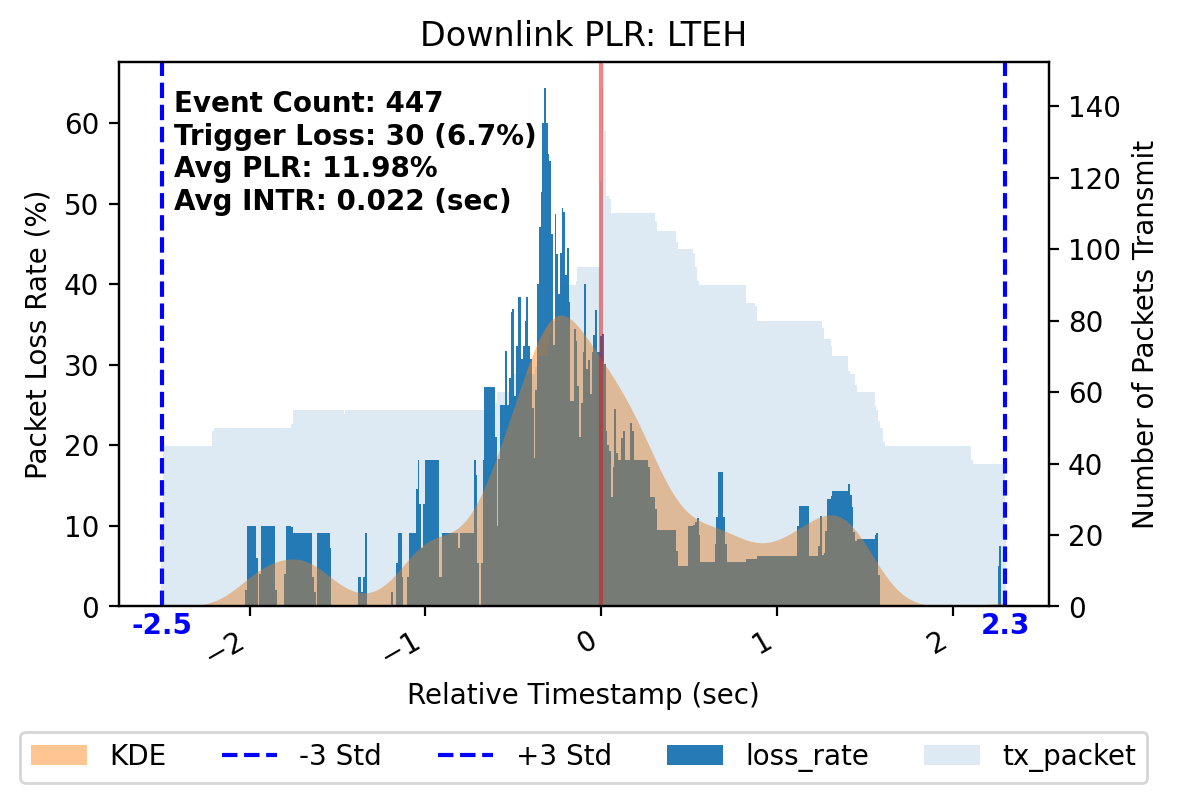

./models/20240312_150032342e/plot/ENBH_A.png


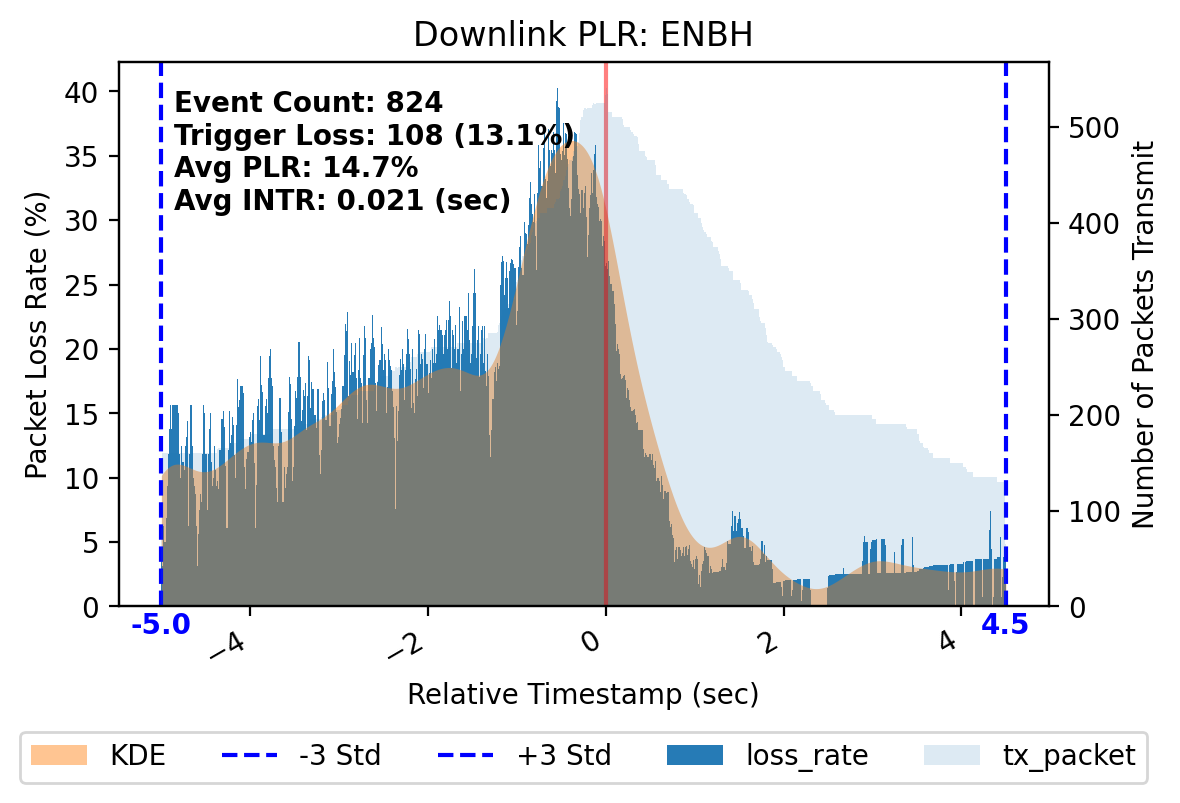

./models/20240312_150032342e/plot/MCGH_A.png


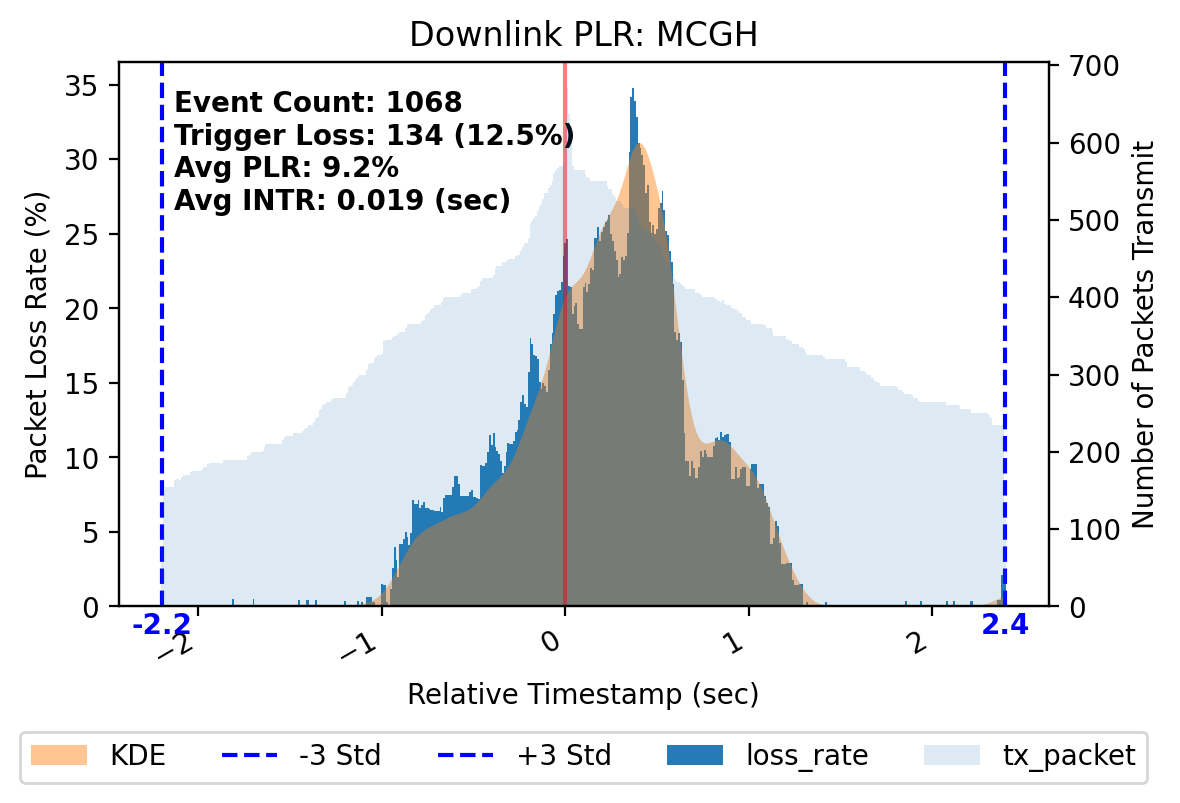

./models/20240312_150032342e/plot/MNBH_A.png


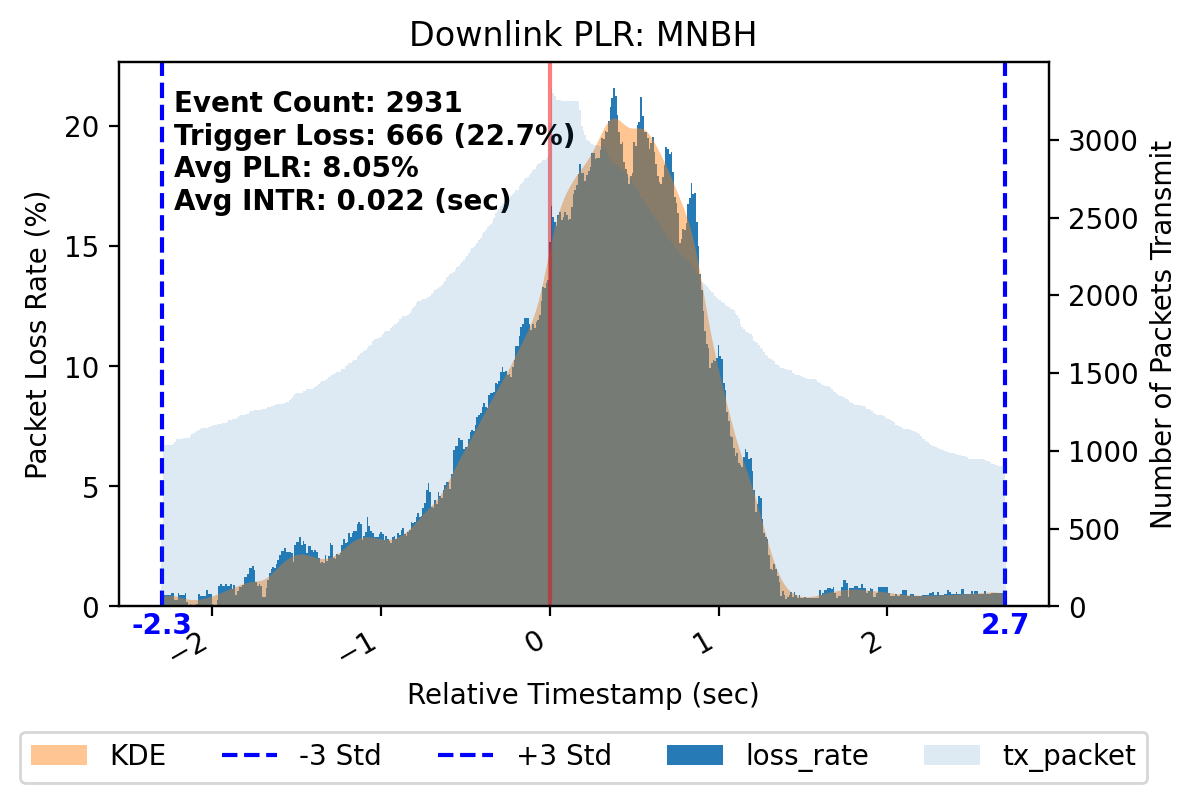

./models/20240312_150032342e/plot/SCGM_A.png


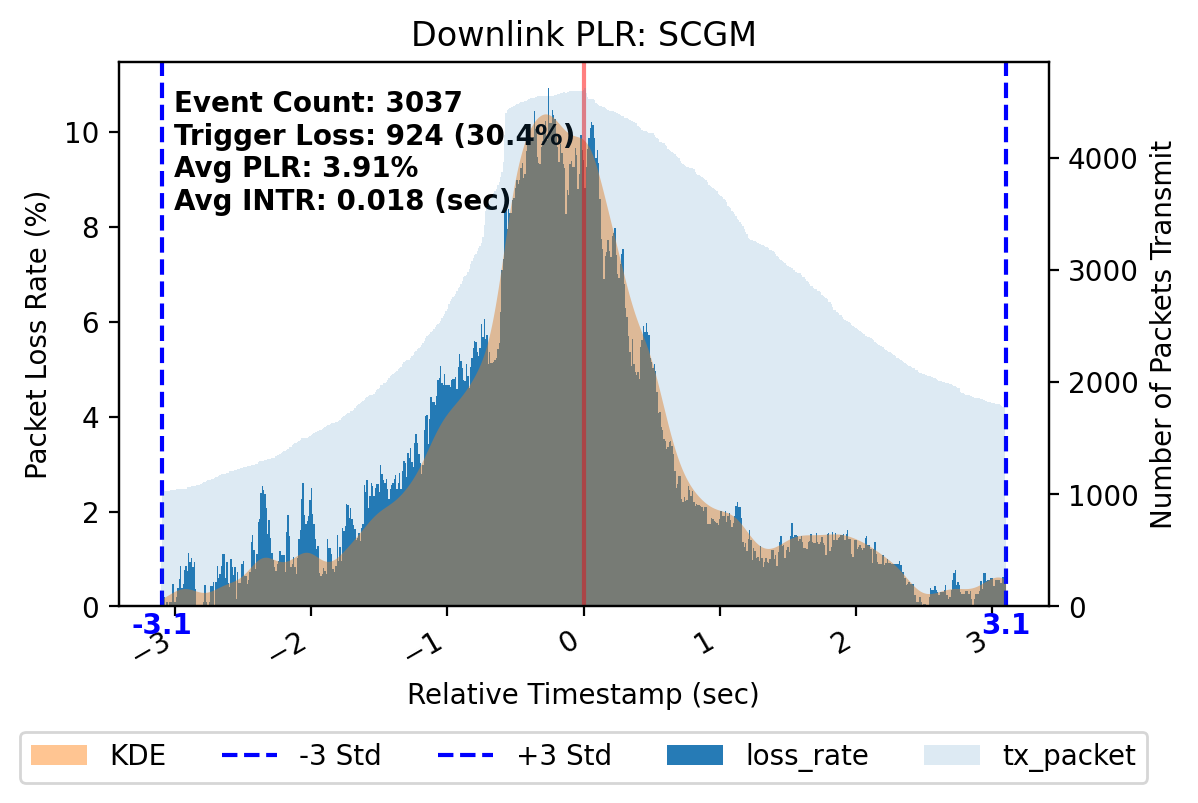

./models/20240312_150032342e/plot/SCGA_A.png


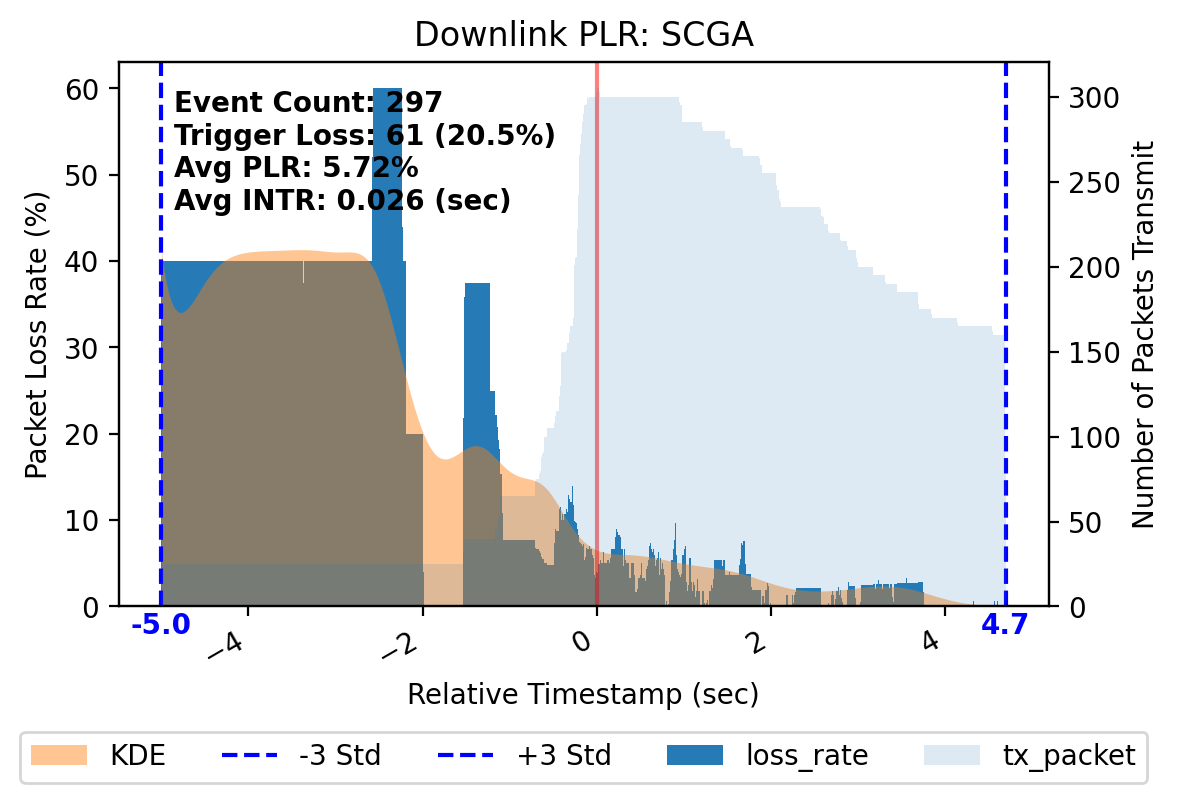

./models/20240312_150032342e/plot/SCGR-I_A.png


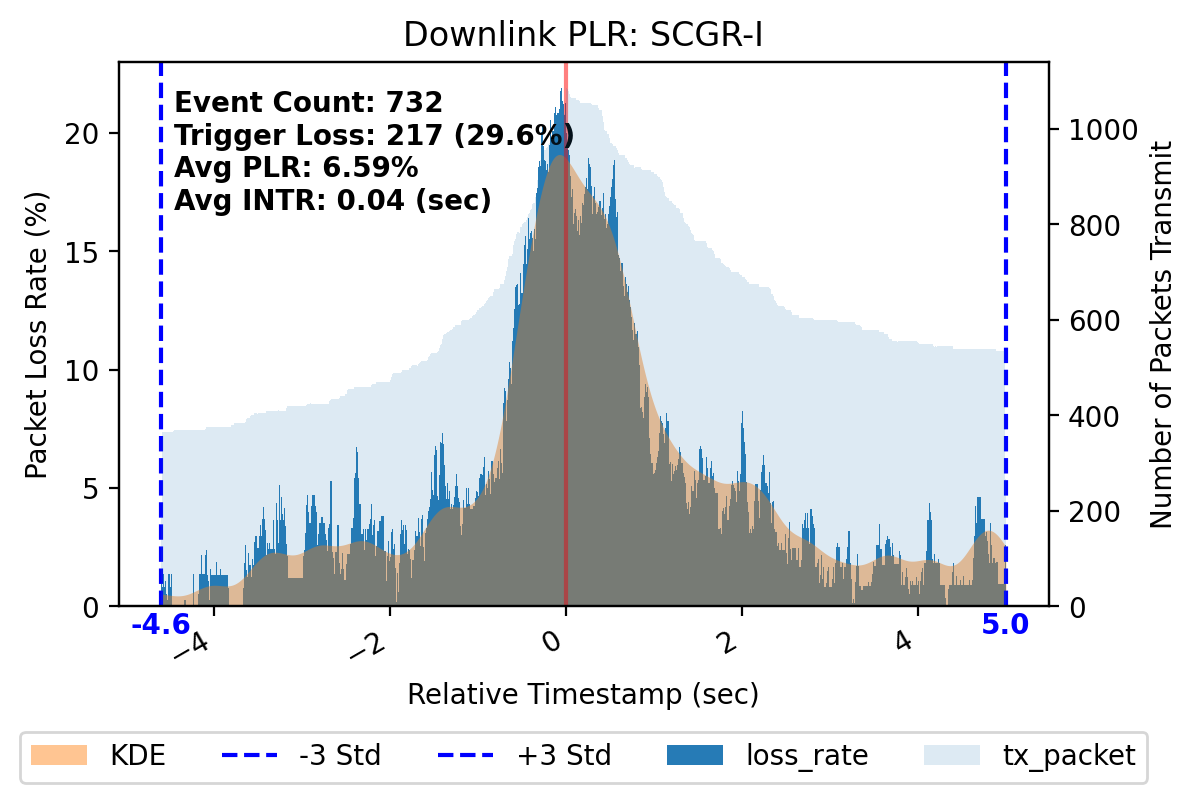

./models/20240312_150032342e/plot/SCGR-II_A.png


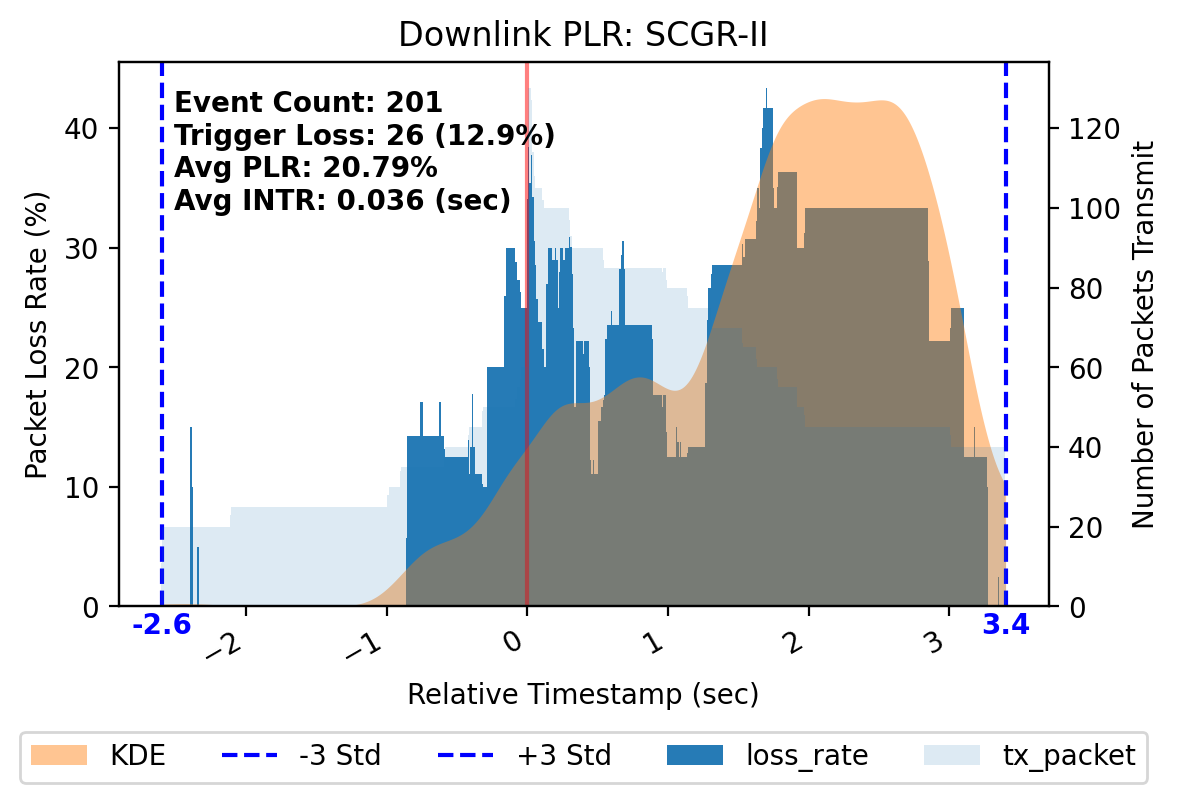

./models/20240312_150032342e/plot/SCGC-I_A.png


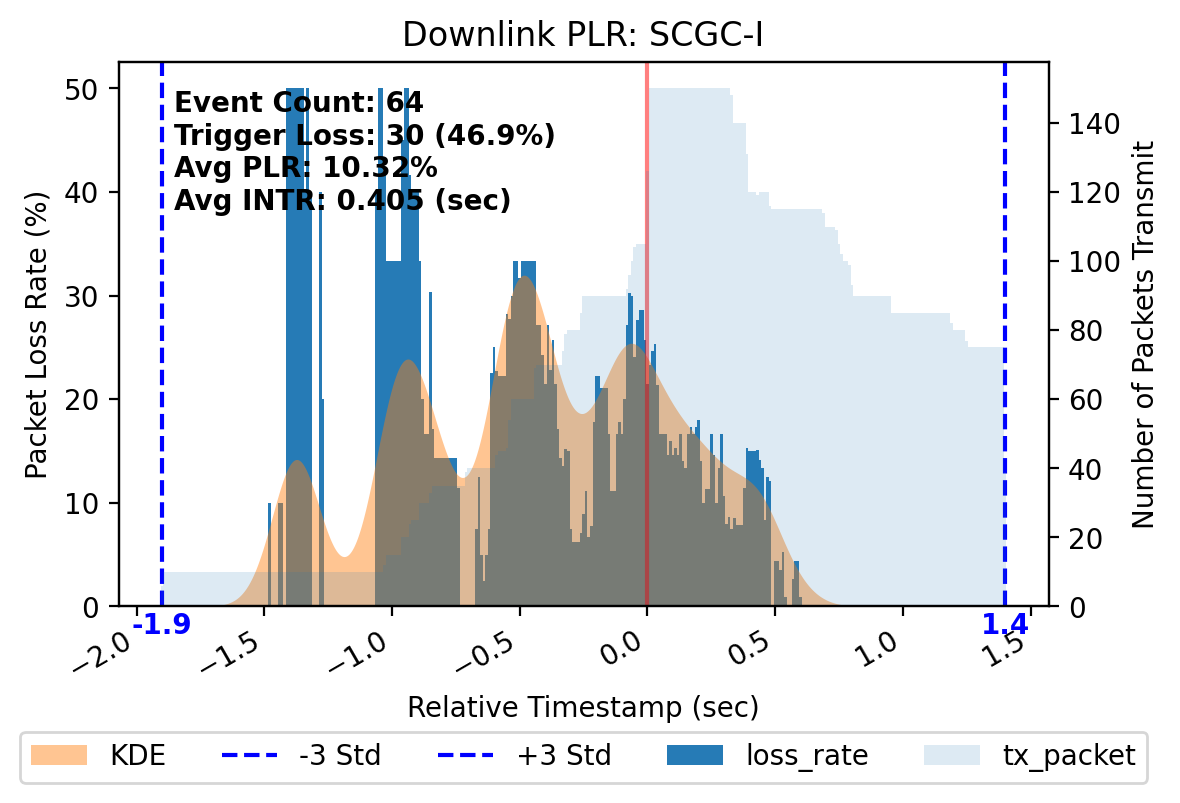

./models/20240312_150032342e/plot/SCGC-II_A.png


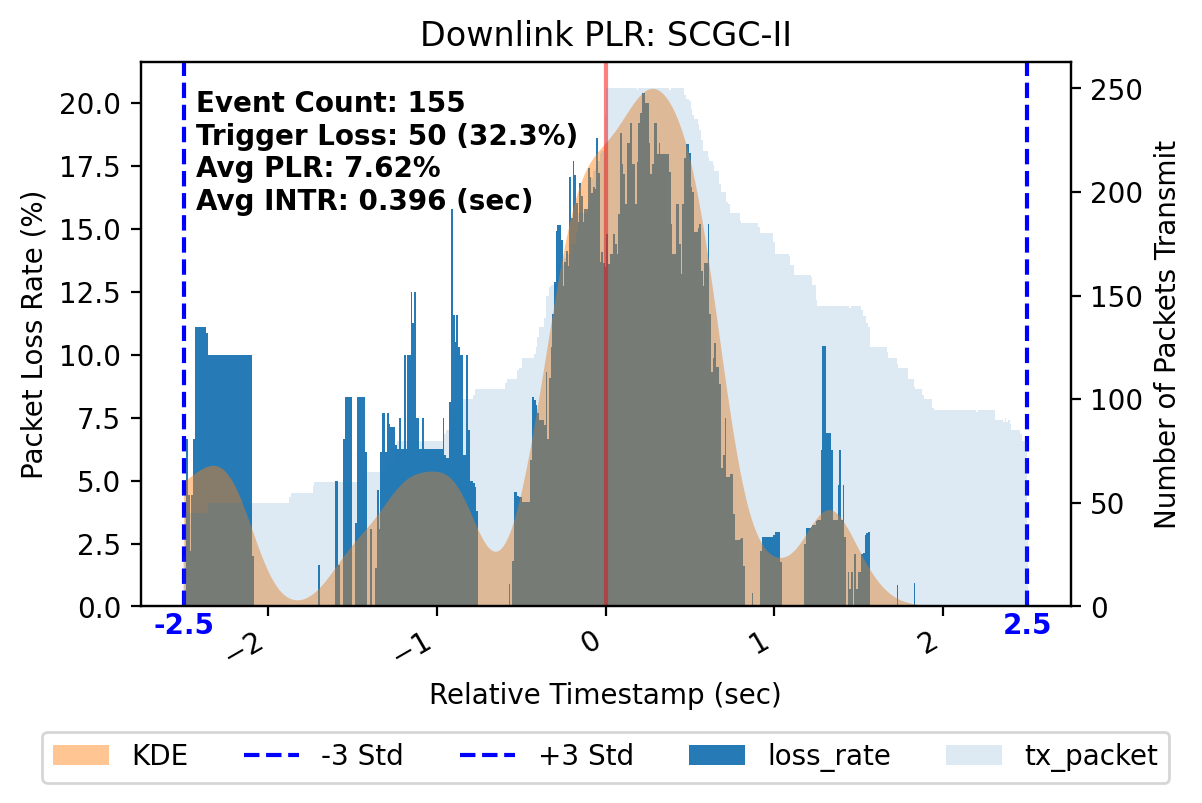

./models/20240312_150032342e/plot/SCGF_A.png


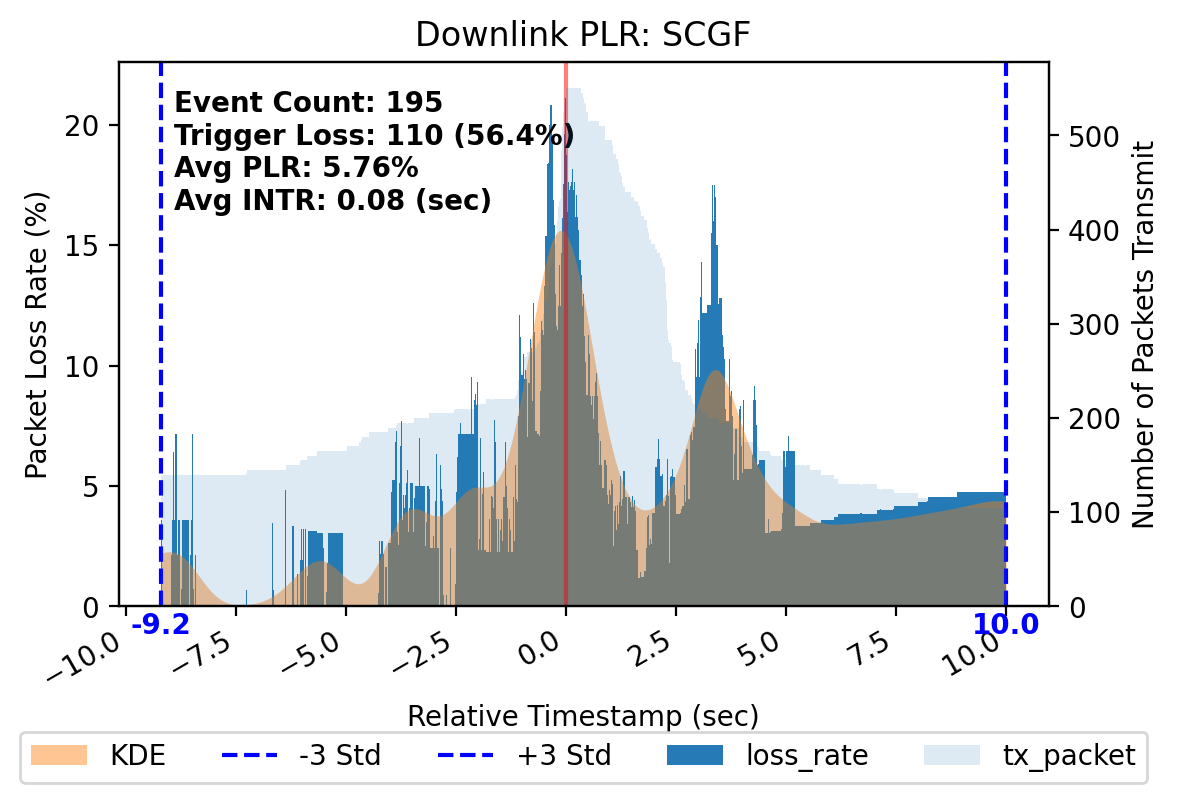

./models/20240312_150032342e/plot/MCGF_A.png


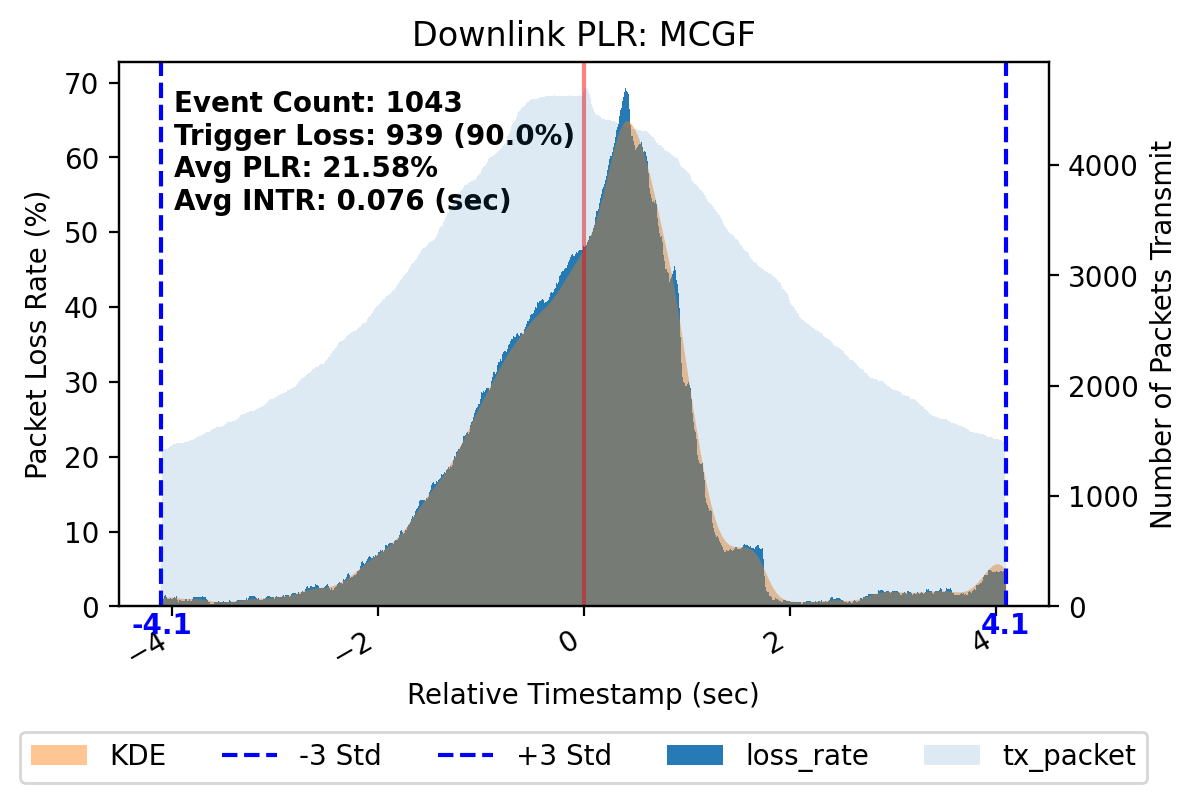

./models/20240312_150032342e/plot/NASR_A.png


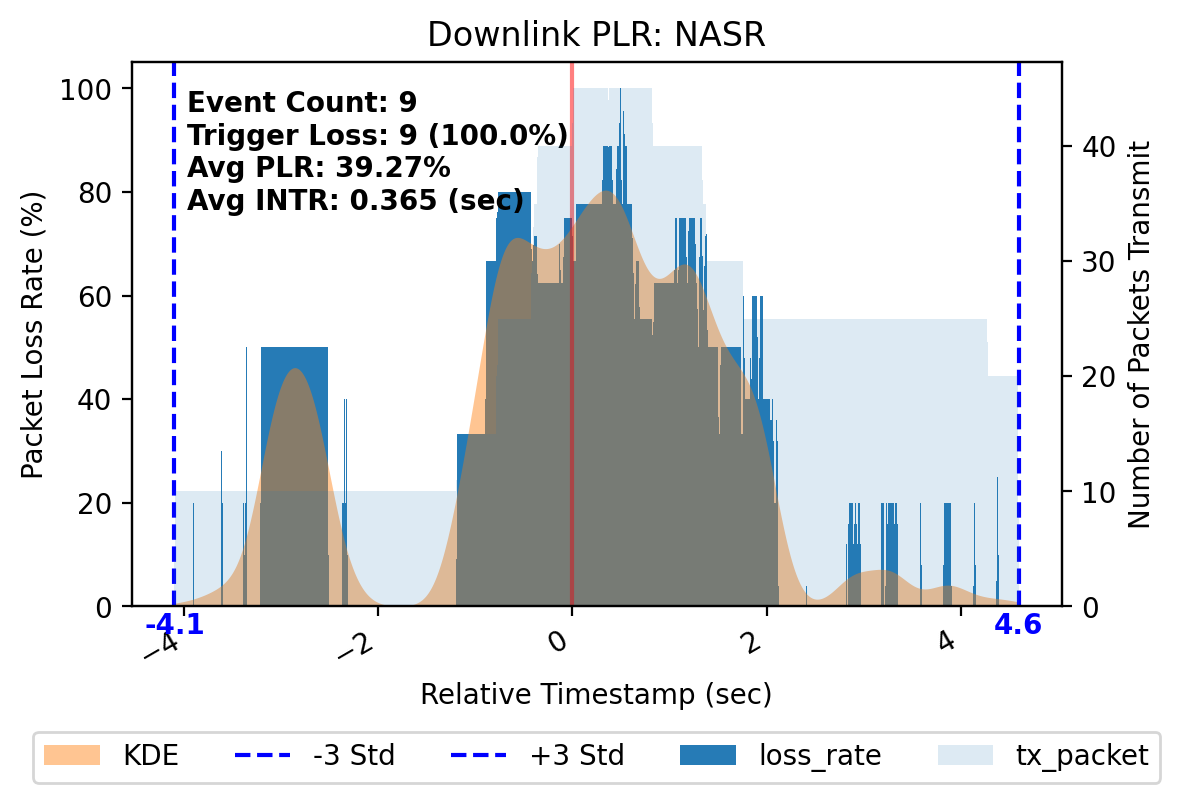

./models/20240312_150032342e/plot/Stable_A.png


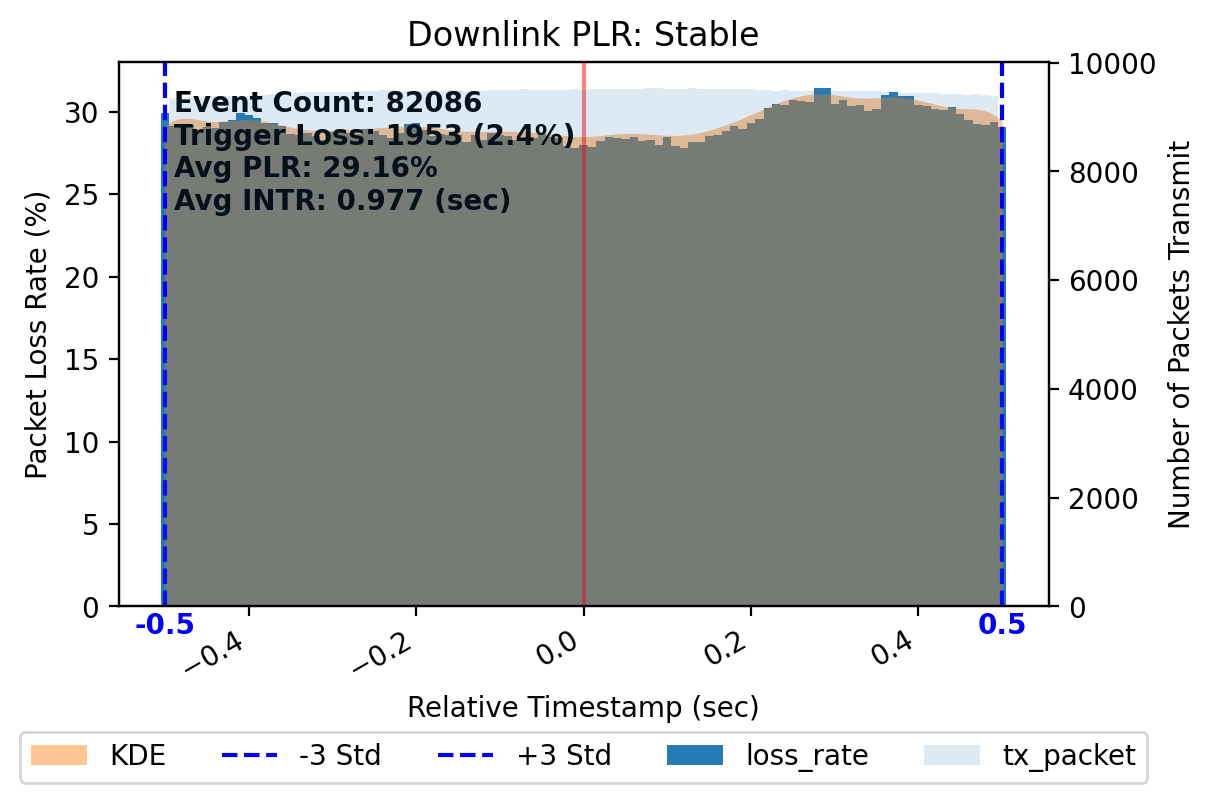

./models/20240312_150032342e/A



In [27]:
model = Profile(filepaths, 'A_prior', model_id, metrics=['dl_lost'])
model.plot()
model = Profile(filepaths, 'A', model_id, 'last', metrics=['dl_lost'], scope_agg=model.scope_models)
model.plot()
model.save_models()

# Single Radio Evaluation

In [28]:
class Eval:
    def __init__(self, filepaths, model_name='Test', model_id=None, load_path='./models',
                 sp_columns=['type'], ts_column='Timestamp',
                 metrics=['dl_lost', 'dl_excl', 'ul_lost', 'ul_excl']):
        # Initialize instance variables
        self.filepaths = copy.deepcopy(filepaths)
        if model_id is None:
            self.model_id = model_prefix()
        else:
            self.model_id = model_id
        self.model_name = model_name
        # self.load_path = os.path.join(load_path, self.model_id, model_add_prefix(self.model_name, self.model_id))
        self.load_path = os.path.join(load_path, self.model_id, self.model_name)
        print(self.load_path)
        with open(f'{self.load_path}_kde_models.pkl', 'rb') as f:
            self.kde_models = pickle.load(f)
        with open(f'{self.load_path}_hist_models.pkl', 'rb') as f:
            self.hist_models = pickle.load(f)
        with open(f'{self.load_path}_scope_models.pkl', 'rb') as f:
            self.scope_models = pickle.load(f)
        with open(f'{self.load_path}_plr_models.pkl', 'rb') as f:
            self.plr_models = pickle.load(f)
        with open(f'{self.load_path}_sr_prob_models.pkl', 'rb') as f:
            self.sr_prob_models = pickle.load(f)
        self.sp_columns = sp_columns[:]
        self.ts_column = ts_column
        self.metrics = metrics[:]
        
        # Sample data
        self.LOSS_GT = []
        self.LOSS_EV = []

        # Standard deviations for error bars
        self.LOSS_STD = []
        
        self.DEVICES = []
        self.TRACES = []
        
        # all records
        self.records = []

    @staticmethod
    def generate_random_boolean(probability_true):
        return random.random() < probability_true
    
    @staticmethod
    def interpolate(x, y, ratio=0.5):
        """
        Args:
            x, y (datetime.datetime): x < y
            ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
        Returns:
            (datetime.datetime): breakpoint of interpolation
        """
        return x + (y - x) * ratio
    
    def hist_method(self, df, ho_df, mode_mets, mets, RATE_TYPE):
        scope = self.scope_models[mode_mets]
        hist_model = self.hist_models[mode_mets]
        prob_model = self.sr_prob_models[mode_mets]
        plr_model = self.plr_models[mode_mets]
        
        this_df = df.copy()
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                # print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    left_bound = min(max(current_left_bound, Eval.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    left_bound = min(max(current_left_bound, Eval.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    right_bound = max(min(current_right_bound, Eval.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    right_bound = max(min(current_right_bound, Eval.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                right_bound = current_right_bound
            
            interval = P.closed(left_bound, right_bound)
            
            # Concatenate PLR from mapping list
            current_df = this_df[this_df['Timestamp'] < interval.upper].copy()
            plr_mapping = hist_model[tag].copy()
            
            current_df[f'relative_time'] = (current_df['Timestamp'] - start_ts).dt.total_seconds()
            current_df[f'window_id'] = ((current_df[f'relative_time'] + 0.005) // 0.01) * 0.01
            
            trigger_probability = prob_model[tag]
            
            if plr_mapping.empty:
                tmp = current_df.copy().rename(columns={mets: f'{mets}_x'})
            else:
                tmp = pd.merge(current_df, plr_mapping, on='window_id', how='left')
                tmp[RATE_TYPE] = tmp[RATE_TYPE].fillna(0)
                
                if not Eval.generate_random_boolean(trigger_probability):
                    tmp[RATE_TYPE] = 0
            
            if i == 0:
                answer = tmp.copy()
            else:
                answer = pd.concat([answer, tmp], axis=0)
            
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()
        
        answer = pd.concat([answer, this_df], axis=0)
        # display(answer)
        
        # Consider stable duration
        stable_df = answer[answer['tx_count'].isnull()].copy()[['seq', 'lost_x', 'excl', 'Timestamp']].rename(columns={'lost_x': 'lost'})

        stable_df['Timestamp_sec'] = stable_df['Timestamp'].dt.floor('S')
        stable_df['relative_time'] = (stable_df['Timestamp'] - stable_df['Timestamp_sec']).dt.total_seconds() - 0.5
        stable_df['window_id'] = ((stable_df['relative_time'] + 0.01 / 2) // 0.01) * 0.01

        plr_mapping = hist_model['Stable'].copy()
        stable_df = pd.merge(stable_df, plr_mapping, on='window_id', how='left').rename(columns={'PLR': 'PLR_trig'})

        trig_p_mapping = stable_df[~stable_df['Timestamp_sec'].duplicated()].reset_index(drop=True)
        triggered_p = prob_model['Stable']
        random_bool_array = [Eval.generate_random_boolean(triggered_p) for _ in range(len(trig_p_mapping))]
        trig_p_mapping['trigger'] = random_bool_array
        trig_p_mapping = trig_p_mapping[['Timestamp_sec', 'trigger']]

        stable_df = pd.merge(stable_df, trig_p_mapping, on='Timestamp_sec', how='left')
        stable_df['PLR'] = stable_df['PLR_trig'] * stable_df['trigger']

        del stable_df['Timestamp_sec'], stable_df['PLR_trig'], stable_df['trigger']
        
        answer = answer[answer['tx_count'].notnull()].copy()
        # display(answer)
        
        answer = pd.concat([answer, stable_df], axis=0)
        answer = answer.sort_values(by='Timestamp').reset_index(drop=True)
        answer['PLR'] = answer['PLR'] / 100
        answer['Y'] = answer['PLR'].apply(Eval.generate_random_boolean)
        
        eval_value = answer['Y'].mean() * 100
        ground_value = df['lost'].mean() * 100
        
        return answer, eval_value, ground_value
    
    
    def hist_method_all(self, N=5):
        n = len(self.filepaths)
        for mode_mets in ['dl_lost']:
            for i, filepath in enumerate(self.filepaths):
                
                # if i > 0:
                #     break
                
                ho_df = pd.read_csv(filepath[0], parse_dates=['start', 'end'])
                
                print(f'{i+1}/{n}', filepath[0]); print(f'{i+1}/{n}', filepath[1])
                
                if ho_df.empty:
                    print('******** Empty RRC Data ********')
                    continue
                
                df = pd.read_csv(filepath[1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
                df, ho_df, empty_data = data_aligner(df, ho_df)
                
                if empty_data:
                    print('******** Empty Data:', mode_mets, '********')
                    continue
                
                ho_df = ho_df[~np.in1d(ho_df['type'], ['SCGA'])].reset_index(drop=True)
                
                loss_rate_list = []
                for iter_round in tqdm(range(N), ncols=1000):
                    _, eval_value, ground_value = eval.hist_method(df, ho_df, mode_mets='dl_lost', mets='lost', RATE_TYPE='PLR')
                    loss_rate_list.append(eval_value)

                def remove_min_max(nums, epsilon=1e-9):
                    if len(nums) < 5:
                        return []
                    min_val = min(nums)
                    max_val = max(nums)
                    nums = [num for num in nums if abs(num - min_val) > epsilon and abs(num - max_val) > epsilon]
                    return nums
                
                loss_rate_list = remove_min_max(loss_rate_list)
                
                mean_value = np.mean(loss_rate_list)
                std_deviation = np.std(loss_rate_list)

                # print()
                # print("Mean:", mean_value)
                # print("Standard Deviation:", std_deviation)
                # print("Ground Truth:", ground_value)
                
                self.LOSS_GT.append(ground_value)
                self.LOSS_EV.append(mean_value)
                self.LOSS_STD.append(std_deviation)
                
                error = mean_value - ground_value
                path = filepath[1]
                
                self.records.append((mean_value, std_deviation, ground_value, error, path))

                # 找到 "sm" 的位置
                sm_index = path.index("sm")
                # 从 "sm" 的位置开始找到下一个斜杠 "/"
                next_slash_index = path.index("/", sm_index)
                # 截取 "sm00" 标签
                sm_label = path[sm_index:next_slash_index]
                # print("截取的标签为:", sm_label)
                
                self.DEVICES.append(sm_label)
                
                # 找到 "sm" 的位置
                sm_index = path.index("#")
                # 从 "sm" 的位置开始找到下一个斜杠 "/"
                next_slash_index = path.index("/", sm_index)
                # 截取 "sm00" 标签
                sm_label = path[sm_index:next_slash_index]
                # print("截取的标签为:", sm_label)
                
                self.TRACES.append(sm_label)
    
    
    def plot(self, save_name='plot_example', save_path='./figures'):
        # Sample data
        x = self.LOSS_GT.copy()
        y = self.LOSS_EV.copy()

        # Standard deviations for error bars
        y_error = self.LOSS_STD.copy()

        # Create figure and axes
        fig, ax = plt.subplots(figsize=(6, 4))

        # Scatter plot with error bars and horizontal caps
        ax.errorbar(x, y, yerr=y_error, linestyle='None', marker='o', color='tab:blue', capsize=5)
        ax.scatter([], [], linestyle='None', marker='o', color='tab:blue', label='Data Points')

        # Regression line
        coefficients = np.polyfit(x, y, 1)
        regression_line = np.poly1d(coefficients)
        ax.plot(ax.get_xlim(), regression_line(ax.get_xlim()), linestyle='--', linewidth=1.1, color='tab:blue', label='Regression Line')

        # Annotate the slope of the regression line
        # slope_annotation = f'Slope: {coefficients[0]:.2f}'
        # ax.annotate(slope_annotation, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

        # Annotate MSE From the regression line
        y_pred = regression_line(x)
        # mse = mean_squared_error(y, y_pred)
        mse = np.sqrt(mean_squared_error(x, y))
        mse_rate = mse / np.mean(x) * 100
        slope_annotation = f'RMSE: {mse:.3f} ({mse_rate:.1f} %)'
        ax.annotate(slope_annotation, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

        # 45-Degree Line
        ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)
        # ax.plot(ax.get_xlim(), 1.1 * ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)
        # ax.plot(ax.get_xlim(), 0.9 * ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)
        
        # 获取 x 的边界
        x_limits = ax.get_xlim()

        # 创建 x 值范围
        x_values = np.linspace(x_limits[0], x_limits[1], 100)  # 使用 x 的边界值作为范围

        # 计算 y = 1.1x 和 y = 0.9x 的值
        y_upper = 1.1 * x_values
        y_lower = 0.9 * x_values

        # 绘制 y = 1.1x 和 y = 0.9x 线
        ax.plot(x_values, y_upper, linestyle='-', linewidth=1.1, color='tab:orange')
        ax.plot(x_values, y_lower, linestyle='-', linewidth=1.1, color='tab:orange')

        # 在两条线之间填充颜色
        ax.fill_between(x_values, y_lower, y_upper, color='tab:orange', alpha=0.3)

        # Set labels and title
        ax.set_xlabel('PLR Ground Truth')
        ax.set_ylabel('PLR Evaluated')
        # ax.set_title('A Profile Evaluate 9 Traces From A5 Data: Single')

        for i, sm_label in enumerate(self.DEVICES):
            ax.annotate(sm_label, xy=(x[i], y[i]))
            
        # Add a legend
        ax.legend()
        
        save_path = os.path.join(save_path, self.model_id)
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
            
        date, hms_count, hex_string, _ = figure_identity()
        save_path = os.path.join(save_path, f'{date}_{save_name}_{hms_count}_{hex_string}.png')
        print(save_path)
        fig.savefig(save_path, dpi=300)

        # Show the plot
        plt.show()
    
    
    def calculate_mse(self):
        arr = np.array([item[3] for item in self.records])
        # Calculate RMS
        rms = np.sqrt(np.mean(arr**2))
        return rms

# BR Eval

In [29]:
# Single Radio Example
dates = data_loader(query_dates=True)

selected_dates = [s for s in dates if s >= '2023-09-12']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['BR']
# excluded_routes = []
filepaths = data_loader(mode='sr', selected_dates=selected_dates, selected_routes=selected_routes)

# print(len(filepaths))
# pprint(filepaths)

./models/20240312_150032342e/BR
1/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv
1/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

2/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv
2/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

3/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/handover_info_log.csv
3/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

4/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm03/#01/data/handover_info_log.csv
4/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm03/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

5/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm04/#01/data/handover_info_log.csv
5/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm04/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

6/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm05/#01/data/handover_info_log.csv
6/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm05/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

7/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm06/#01/data/handover_info_log.csv
7/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm06/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

8/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm07/#01/data/handover_info_log.csv
8/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm07/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

9/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm08/#01/data/handover_info_log.csv
9/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm08/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

10/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#02/data/handover_info_log.csv
10/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm00/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

11/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#02/data/handover_info_log.csv
11/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm01/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

12/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#02/data/handover_info_log.csv
12/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm02/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

13/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm03/#02/data/handover_info_log.csv
13/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm03/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

14/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm04/#02/data/handover_info_log.csv
14/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm04/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

15/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm05/#02/data/handover_info_log.csv
15/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm05/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

16/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm06/#02/data/handover_info_log.csv
16/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm06/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

17/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm07/#02/data/handover_info_log.csv
17/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm07/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

18/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm08/#02/data/handover_info_log.csv
18/54 /home/wmnlab/jackbedford/data/2023-09-12-2/UDP_Bandlock_9S_Phone_Brown/sm08/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

19/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv
19/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

20/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv
20/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

21/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/handover_info_log.csv
21/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

22/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm03/#01/data/handover_info_log.csv
22/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm03/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

23/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm04/#01/data/handover_info_log.csv
23/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm04/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

24/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm05/#01/data/handover_info_log.csv
24/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm05/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

25/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm06/#01/data/handover_info_log.csv
25/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm06/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

26/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm07/#01/data/handover_info_log.csv
26/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm07/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

27/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm08/#01/data/handover_info_log.csv
27/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm08/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

28/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm00/#02/data/handover_info_log.csv
28/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm00/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

29/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm01/#02/data/handover_info_log.csv
29/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm01/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

30/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm02/#02/data/handover_info_log.csv
30/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm02/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

31/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm03/#02/data/handover_info_log.csv
31/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm03/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

32/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm04/#02/data/handover_info_log.csv
32/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm04/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

33/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm05/#02/data/handover_info_log.csv
33/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm05/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

34/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm06/#02/data/handover_info_log.csv
34/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm06/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

35/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm07/#02/data/handover_info_log.csv
35/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm07/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

36/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm08/#02/data/handover_info_log.csv
36/54 /home/wmnlab/jackbedford/data/2023-09-21/UDP_Bandlock_9S_Phone_Brown/sm08/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

37/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/handover_info_log.csv
37/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

38/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/handover_info_log.csv
38/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm01/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

39/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/handover_info_log.csv
39/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm02/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

40/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm03/#01/data/handover_info_log.csv
40/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm03/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

41/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm04/#01/data/handover_info_log.csv
41/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm04/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

42/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm05/#01/data/handover_info_log.csv
42/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm05/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

43/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm06/#01/data/handover_info_log.csv
43/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm06/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

44/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm07/#01/data/handover_info_log.csv
44/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm07/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

45/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm08/#01/data/handover_info_log.csv
45/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm08/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

46/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#02/data/handover_info_log.csv
46/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm00/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

47/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm01/#02/data/handover_info_log.csv
47/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm01/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

48/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm02/#02/data/handover_info_log.csv
48/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm02/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

49/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm03/#02/data/handover_info_log.csv
49/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm03/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

50/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm04/#02/data/handover_info_log.csv
50/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm04/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

51/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm05/#02/data/handover_info_log.csv
51/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm05/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

52/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm06/#02/data/handover_info_log.csv
52/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm06/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

53/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm07/#02/data/handover_info_log.csv
53/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm07/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

54/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm08/#02/data/handover_info_log.csv
54/54 /home/wmnlab/jackbedford/data/2023-11-09/UDP_Bandlock_9S_Phone_Brown/sm08/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

./figures/20240312_150032342e/20240312_BR_17353100000_e2c63fd105078934.png


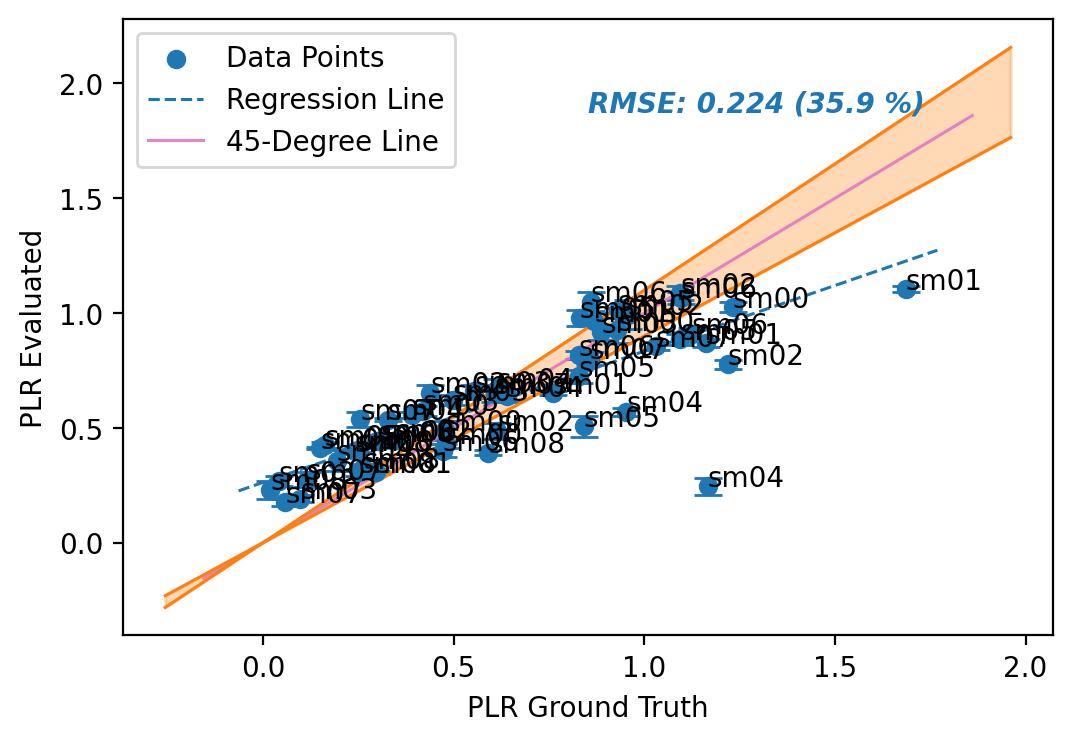

In [30]:
eval = Eval(filepaths, 'BR', model_id)
eval.hist_method_all()
eval.plot('BR')

# A Eval

In [31]:
# Single Radio Example
dates = data_loader(query_dates=True)

selected_dates = [s for s in dates if s >= '2023-09-12']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['A']
# excluded_routes = []
filepaths = data_loader(mode='sr', selected_dates=selected_dates, selected_routes=selected_routes)

# print(len(filepaths))
# pprint(filepaths)

./models/20240312_150032342e/A
1/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
1/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

2/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
2/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

3/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
3/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

4/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
4/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv
******** Empty RRC Data ********
5/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/handover_info_log.csv
5/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

6/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/handover_info_log.csv
6/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

7/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/handover_info_log.csv
7/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

8/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
8/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

9/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/handover_info_log.csv
9/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

10/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
10/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

11/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
11/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

12/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
12/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

13/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
13/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

14/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
14/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

15/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
15/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

16/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
16/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

17/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
17/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

18/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
18/54 /home/wmnlab/jackbedford/data/2023-10-26/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

19/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
19/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

20/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
20/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

21/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
21/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

22/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
22/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

23/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/handover_info_log.csv
23/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

24/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/handover_info_log.csv
24/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

25/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/handover_info_log.csv
25/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

26/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
26/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

27/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/handover_info_log.csv
27/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

28/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
28/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

29/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
29/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

30/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
30/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

31/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
31/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

32/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
32/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

33/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
33/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

34/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
34/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

35/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
35/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

36/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
36/54 /home/wmnlab/jackbedford/data/2023-11-01/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

37/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/handover_info_log.csv
37/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

38/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/handover_info_log.csv
38/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

39/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/handover_info_log.csv
39/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

40/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/handover_info_log.csv
40/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

41/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/handover_info_log.csv
41/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#01/data/udp_dnlk_loss_latency.csv
******** Empty RRC Data ********
42/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/handover_info_log.csv
42/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#01/data/udp_dnlk_loss_latency.csv
******** Empty RRC Data ********
43/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/handover_info_log.csv
43/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

44/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/handover_info_log.csv
44/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#01/data/udp_dnlk_loss_latency.csv
******** Empty RRC Data ********
45/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/handover_info_log.csv
45/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#01/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

46/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/handover_info_log.csv
46/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm00/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

47/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/handover_info_log.csv
47/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm01/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

48/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/handover_info_log.csv
48/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm02/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

49/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/handover_info_log.csv
49/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm03/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

50/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/handover_info_log.csv
50/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm04/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

51/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/handover_info_log.csv
51/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm05/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

52/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/handover_info_log.csv
52/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm06/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

53/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/handover_info_log.csv
53/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm07/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

54/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/handover_info_log.csv
54/54 /home/wmnlab/jackbedford/data/2023-11-02/UDP_Bandlock_9S_Phone_Airport/sm08/#02/data/udp_dnlk_loss_latency.csv


  0%|                                                                                                         …

./figures/20240312_150032342e/20240312_A_17353100001_327846b01abfe6cb.png


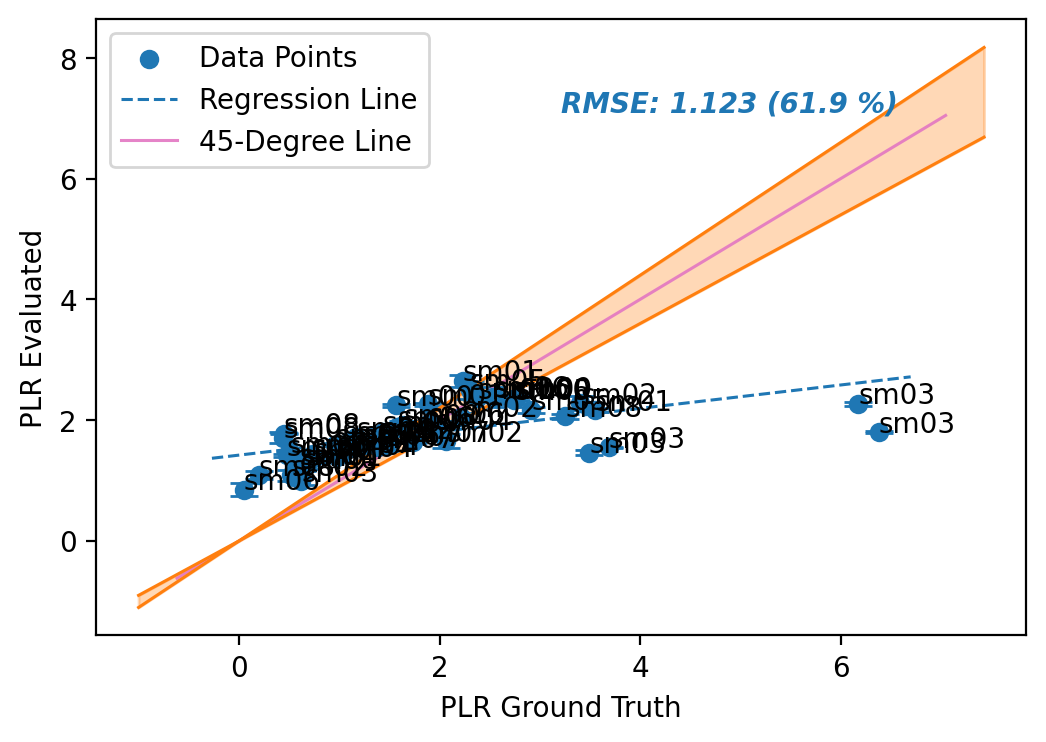

In [32]:
eval = Eval(filepaths, 'A', model_id)
eval.hist_method_all()
eval.plot('A')

# Show Model ID

In [33]:
print(model_id)

20240312_150032342e
